In [39]:
#%reset
import seaborn as sb
import matplotlib.pyplot as plt
import pandas as pd
import sklearn as sk
import numpy as np
import eli5

from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import cross_validate, RandomizedSearchCV, RepeatedStratifiedKFold
from sklearn.inspection import permutation_importance
from scipy.stats import loguniform
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import confusion_matrix
from eli5.sklearn import PermutationImportance
from sklearn.metrics import f1_score, matthews_corrcoef
from Functions_AMR_gonorrhea import effective_unnecessary_threshold, get_best_hyperparameters, get_best_features, get_test_train_data, get_feature_effects, f1_mcc_score_threshold

hfont = {'fontname':'Helvetica'}

## read data 
CIP_data = pd.read_csv("CIP_data_encode_prev.csv")
CIP_data_no_drop = pd.read_csv("CIP_data_encode_prev_not_dropped.csv")
print(CIP_data_no_drop.columns)

Index(['Unnamed: 0.4', 'Unnamed: 0.3', 'Unnamed: 0.2', 'Unnamed: 0.1',
       'Unnamed: 0', 'CLINIC', 'YEAR', 'GENDERSP', 'Susceptible', 'MSM',
       'MSMW', 'MSW', 'Oth/Unk/Missing', 'REGION', 'Midwest', 'Northeast',
       'Southeast', 'Southwest', 'West', 'PREV_REGION', 'PREV_CLINIC',
       'DELTA_REGION', 'DELTA_CLINIC'],
      dtype='object')


In [40]:
### Get demographic data 
##### CIP resistance
## To get summary stats, use original data 
CIP_data_full = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010])]

print(CIP_data_full.columns)
total_obs = len(CIP_data_full)
print(total_obs)
#####
## initial stats for regional data 
#####
west = ['POR', 'PHX', 'HON', 'SDG', 'SFO', 'ANC', 'SEA', 'DEN', 'LVG', 'ORA', 'LBC', 'SLC', 'LAX']
southwest = ['OKC','MIN', 'ALB', 'DAL']
midwest = ['KCY','CHI', 'PON', 'CIN', 'JAC', 'IND', 'STL','DTR', 'MIL', 'COL', 'CLE']
southeast = ['GRB', 'NOR','WDC','MIA', 'BHM','FBG','ATL', 'RIC']
northeast = ['BUF','BOS', 'CAM', 'NYC', 'BAL', 'PHI']

CIP_data_full['REGION'] = CIP_data_full['CLINIC'].apply(lambda x: 
    'West' if (x in west) else (
        'Southwest' if (x in southwest) else(
            'Midwest' if (x in midwest) else(
                'Southeast' if (x in southeast) else(
                    'Northeast' if (x in northeast) else 'Other'))))) #drug_combinations = ['TetI']



regions = CIP_data_full['REGION'].unique()
regional_average = []
for region in regions:
    regional_data =len(CIP_data_full.loc[CIP_data_full['REGION'] == region])
    regional_average.append({region,(regional_data/total_obs)*100}) 
 
print(regional_average)
#####
## initial stats for gender data
#####

gendersps = CIP_data_full['GENDERSP'].unique()
gendersp_average = []
for gendersp in gendersps:
    gendersp_data =len(CIP_data_full.loc[CIP_data_full['GENDERSP'] == gendersp])
    gendersp_average.append({gendersp,(gendersp_data/total_obs)*100}) 
 
print(gendersp_average)



Index(['Unnamed: 0.4', 'Unnamed: 0.3', 'Unnamed: 0.2', 'Unnamed: 0.1',
       'Unnamed: 0', 'CLINIC', 'YEAR', 'GENDERSP', 'Susceptible', 'MSM',
       'MSMW', 'MSW', 'Oth/Unk/Missing', 'REGION', 'Midwest', 'Northeast',
       'Southeast', 'Southwest', 'West', 'PREV_REGION', 'PREV_CLINIC',
       'DELTA_REGION', 'DELTA_CLINIC'],
      dtype='object')
64445
[{'Southwest', 13.94056947784933}, {35.52331445418574, 'West'}, {'Southeast', 18.456047792691443}, {10.88525098921561, 'Northeast'}, {'Midwest', 21.19481728605788}]
[{'MSW', 76.11761967569245}, {16.967957172782995, 'MSM'}, {'MSMW', 3.556521064473582}, {3.3579020870509737, 'Oth/Unk/Missing'}]


/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_2648/2209338190.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  CIP_data_full['REGION'] = CIP_data_full['CLINIC'].apply(lambda x:


In [41]:
############# data

#nn_data 

best_hyperparameters_by_year_lr = {2005: {'solver': 'liblinear', 'penalty': 'l1', 'C': 54.85}, 2006: {'solver': 'liblinear', 'penalty': 'l1', 'C': 8.65}, 2007: {'solver': 'liblinear', 'penalty': 'l1', 'C': 35.730000000000004}, 2008: {'solver': 'liblinear', 'penalty': 'l1', 'C': 35.730000000000004}, 2009: {'solver': 'liblinear', 'penalty': 'l1', 'C': 8.65}, 2010: {'solver': 'liblinear', 'penalty': 'l1', 'C': 8.65}}
best_hyperparameters_by_year_rf ={2005: {'n_estimators': 181, 'min_samples_split': 20, 'min_samples_leaf': 5, 'max_depth': 99}, 2006: {'n_estimators': 181, 'min_samples_split': 20, 'min_samples_leaf': 5, 'max_depth': 99}, 2007: {'n_estimators': 181, 'min_samples_split': 20, 'min_samples_leaf': 5, 'max_depth': 99}, 2008: {'n_estimators': 181, 'min_samples_split': 20, 'min_samples_leaf': 5, 'max_depth': 99}, 2009: {'n_estimators': 181, 'min_samples_split': 20, 'min_samples_leaf': 5, 'max_depth': 99}, 2010: {'n_estimators': 181, 'min_samples_split': 20, 'min_samples_leaf': 5, 'max_depth': 99}}
best_hyperparameters_by_year_nn ={2005: {'solver': 'adam', 'learning_rate': 'adaptive', 'hidden_layer_sizes': (13,), 'alpha': 0.12080421346773286, 'activation': 'relu'}, 2006: {'solver': 'adam', 'learning_rate': 'adaptive', 'hidden_layer_sizes': (13,), 'alpha': 0.12080421346773286, 'activation': 'relu'}, 2007: {'solver': 'adam', 'learning_rate': 'adaptive', 'hidden_layer_sizes': (13,), 'alpha': 0.12080421346773286, 'activation': 'relu'}, 2008: {'solver': 'adam', 'learning_rate': 'adaptive', 'hidden_layer_sizes': (13,), 'alpha': 0.12080421346773286, 'activation': 'relu'}, 2009: {'solver': 'adam', 'learning_rate': 'adaptive', 'hidden_layer_sizes': (13,), 'alpha': 0.12080421346773286, 'activation': 'relu'}, 2010: {'solver': 'adam', 'learning_rate': 'adaptive', 'hidden_layer_sizes': (13,), 'alpha': 0.12080421346773286, 'activation': 'relu'}}
best_features_by_year_lr = {2005: ['PREV_CLINIC', 'MSW', 'DELTA_CLINIC', 'PREV_REGION', 'MSM', 'Northeast', 'Oth/Unk/Missing'], 2006: ['DELTA_REGION', 'PREV_CLINIC', 'DELTA_CLINIC', 'MSW', 'PREV_REGION', 'Oth/Unk/Missing', 'MSM', 'Southwest', 'Southeast'], 2007: ['MSW', 'PREV_CLINIC', 'MSM', 'Oth/Unk/Missing'], 2008: ['PREV_CLINIC', 'DELTA_CLINIC', 'West', 'MSW', 'MSM', 'PREV_REGION', 'MSMW', 'Oth/Unk/Missing'], 2009: ['PREV_CLINIC', 'Oth/Unk/Missing', 'DELTA_CLINIC'], 2010: ['MSW', 'MSM', 'DELTA_CLINIC', 'PREV_CLINIC', 'Oth/Unk/Missing', 'West', 'Southwest', 'MSMW', 'DELTA_REGION', 'Southeast', 'PREV_REGION', 'Northeast']}
best_features_by_year_rf ={2005: ['MSW', 'DELTA_CLINIC', 'MSM', 'PREV_CLINIC', 'West', 'PREV_REGION', 'DELTA_REGION', 'Oth/Unk/Missing', 'MSMW'], 2006: ['MSW', 'MSM', 'DELTA_CLINIC', 'PREV_CLINIC', 'MSMW', 'Northeast', 'Southeast', 'Oth/Unk/Missing'], 2007: ['MSW', 'PREV_CLINIC', 'MSM', 'Oth/Unk/Missing', 'DELTA_CLINIC', 'Southeast', 'MSMW', 'Northeast'], 2008: ['MSW', 'PREV_CLINIC', 'MSM', 'West', 'Northeast', 'DELTA_CLINIC', 'Oth/Unk/Missing', 'DELTA_REGION', 'Southwest'], 2009: ['PREV_CLINIC', 'MSW', 'DELTA_REGION', 'Oth/Unk/Missing', 'West', 'Northeast', 'Southeast'], 2010: ['MSW', 'DELTA_CLINIC', 'MSM', 'PREV_CLINIC', 'PREV_REGION', 'Oth/Unk/Missing', 'West', 'Southeast', 'MSMW', 'DELTA_REGION', 'Northeast']}
best_features_by_year_nn ={2005: ['MSM', 'DELTA_CLINIC', 'MSW', 'Southwest', 'MSMW', 'DELTA_REGION', 'Oth/Unk/Missing'], 2006: ['DELTA_CLINIC', 'MSM', 'PREV_CLINIC', 'MSW', 'DELTA_REGION', 'PREV_REGION', 'MSMW', 'Northeast', 'Oth/Unk/Missing'], 2007: ['PREV_CLINIC', 'MSW', 'MSM', 'Southwest', 'MSMW'], 2008: ['MSM', 'DELTA_CLINIC', 'PREV_CLINIC', 'Northeast', 'MSW', 'MSMW'], 2009: ['PREV_CLINIC', 'MSM', 'DELTA_CLINIC', 'Southeast', 'DELTA_REGION', 'Oth/Unk/Missing', 'Southwest', 'West', 'Northeast'], 2010: ['MSM', 'MSW', 'PREV_CLINIC', 'DELTA_CLINIC', 'PREV_REGION', 'Southeast', 'MSMW', 'Southwest', 'Oth/Unk/Missing', 'Northeast', 'West']}
ROC_by_year_lr = {2005: 0.7322853685805495, 2006: 0.7423710317796873, 2007: 0.7048918256421187, 2008: 0.6968498187602681, 2009: 0.639172181709682, 2010: 0.6797716960932587}
ROC_by_year_rf ={2005: 0.7586099894081821, 2006: 0.7418094620985698, 2007: 0.7033306886765269, 2008: 0.6939654992567867, 2009: 0.679491422061069, 2010: 0.6840913725423555}
ROC_by_year_nn ={2005: 0.7372748012808253, 2006: 0.7324350027761852, 2007: 0.6936770334581981, 2008: 0.7043116801835867, 2009: 0.6705138326697341, 2010: 0.6835202587500921}


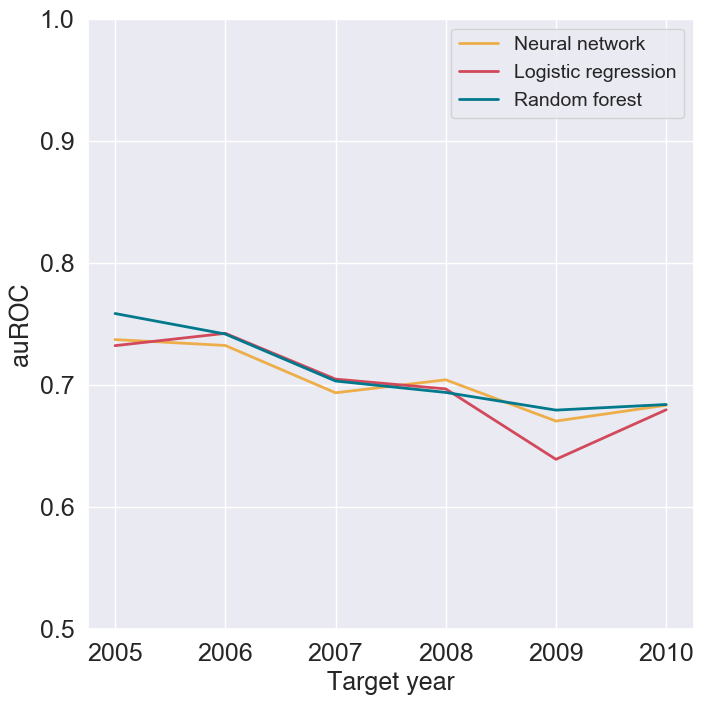

In [42]:
############# Graph 1: auROC by year 2005-2010, trained on previous 5 years' data, for nn, rf and lr 
fig, axs = plt.subplots(figsize=(7.5, 7.5), facecolor='w', edgecolor='k', sharex = 'all', sharey = 'all')
years = np.array(range(2005, 2011))
axs.tick_params(axis='both', which='major', labelsize=18)
axs.set_xticks(np.array(range(2005, 2011)))
#axs.set_xticks([2005, 2007, 2010])

axs.plot(years, ROC_by_year_nn.values(),linewidth = 2, label = "Neural network", color = "#edae49")
axs.plot(years, ROC_by_year_lr.values(),linewidth = 2, label = "Logistic regression", color = "#d1495b")
axs.plot(years, ROC_by_year_rf.values(),linewidth = 2, label = "Random forest", color = "#00798c")
axs.set_ylabel("auROC", fontsize = 18, **hfont)
axs.set_xlabel("Target year",  fontsize = 18,**hfont)
axs.set_ylim([0.5,1])
axs.legend(prop={'size':14})
plt.tight_layout()

#plt.savefig('Graphs/auROC_by_year_all_models.png', dpi = 300)


In [49]:
## Data for all figures 
labels = ["A", "B", "C", "D", "E", "F" ]
years = [2005, 2006, 2007, 2008, 2009, 2010]
threshold_seq = np.linspace(0,1,1001)

Oversample
Oversample
Oversample
Oversample
Oversample
Oversample


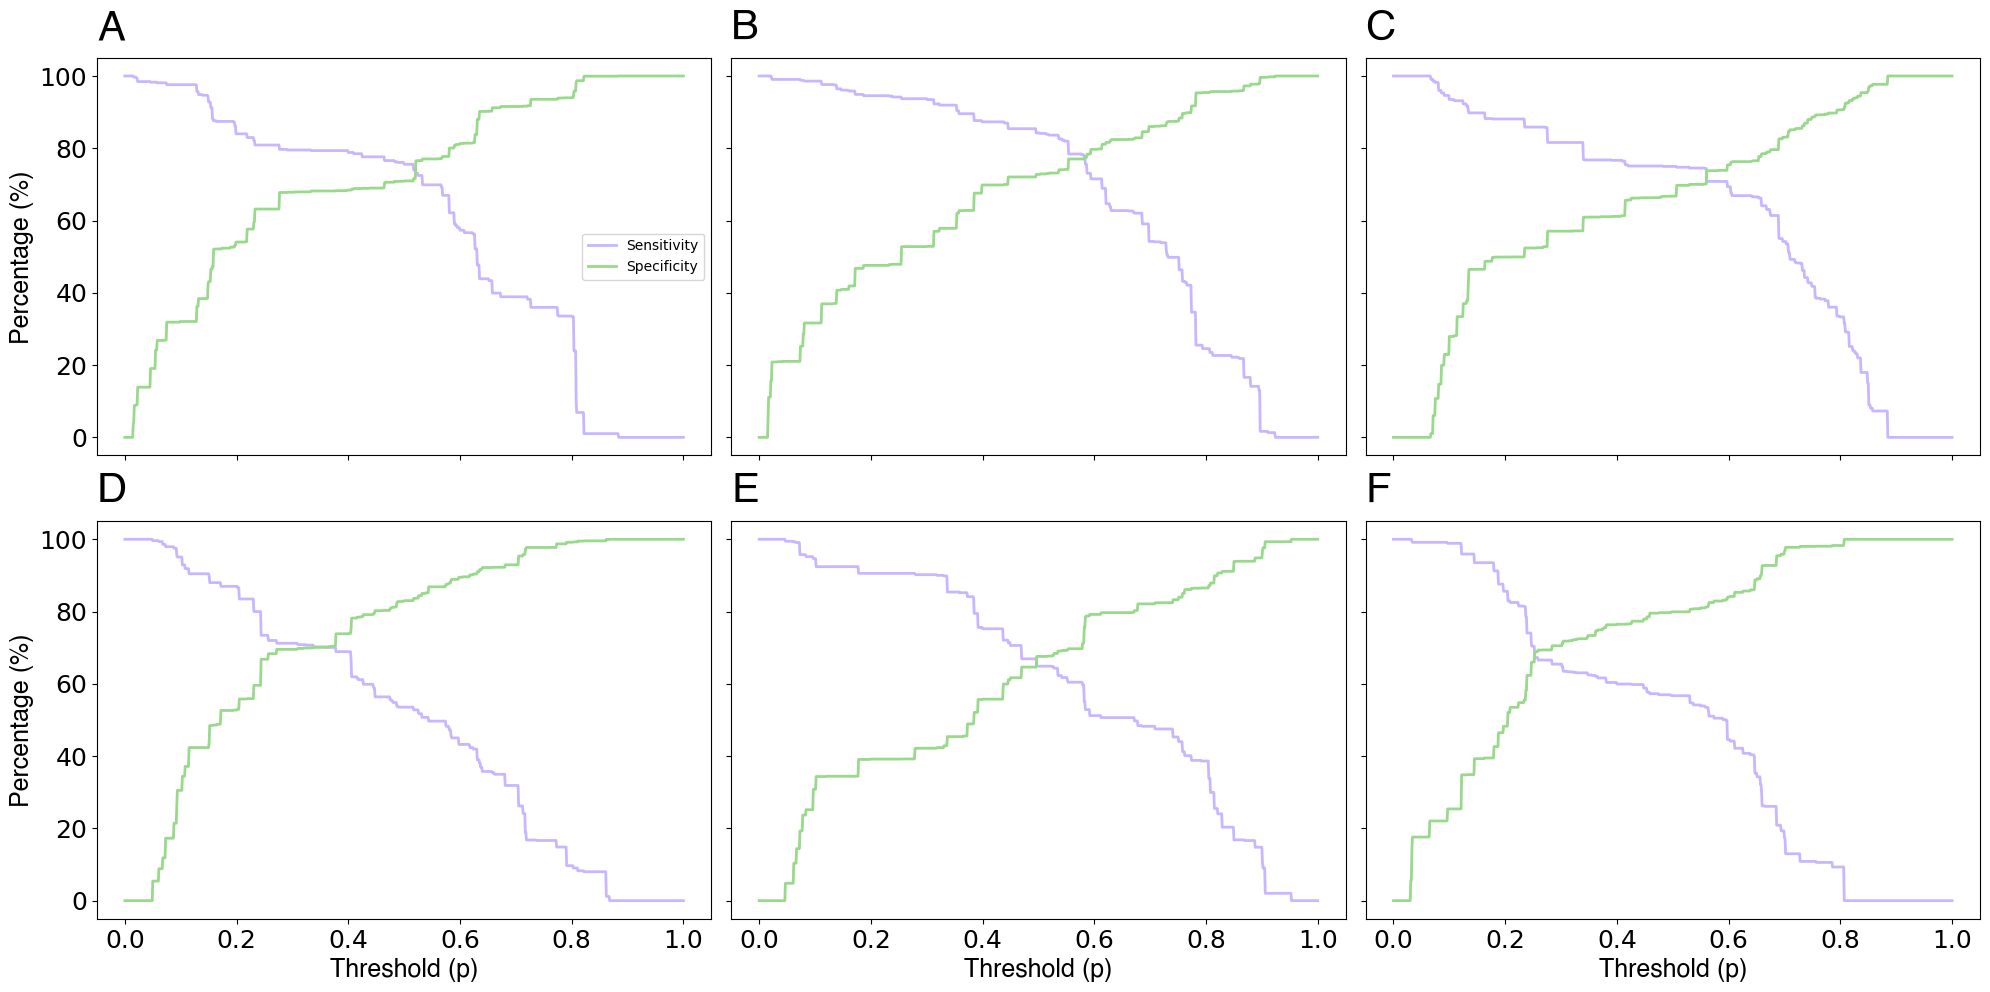

In [16]:
### Do the sensitivity by year, too... Neural network 
fig, axs = plt.subplots(2,3, figsize=(20, 10), facecolor='w', edgecolor='k', sharex = 'all', sharey = 'all')
labels = ["A", "B", "C", "D", "E", "F" ]
years = [2005, 2006, 2007, 2008, 2009, 2010]
axs[0,0].set_ylabel('Percentage (%)', fontsize=18,**hfont)
axs[1,0].set_ylabel('Percentage (%)', fontsize=18,**hfont)
axs[1,0].set_xlabel('Threshold (p)', fontsize=18,**hfont)
axs[1,1].set_xlabel('Threshold (p)', fontsize=18,**hfont)
axs[1,2].set_xlabel('Threshold (p)', fontsize=18,**hfont)

axs[0,0].set_yticks(np.linspace(0,100,6), fontsize=18,**hfont)
axs[1,0].set_yticks(np.linspace(0,100,6), fontsize=18,**hfont)
axs[1,0].set_xticks(np.linspace(0,1,6), fontsize=18,**hfont)
axs[1,1].set_xticks(np.linspace(0,1,6), fontsize=18,**hfont)
axs[1,2].set_xticks(np.linspace(0,1,6), fontsize=18,**hfont)

axs[0,0].tick_params(axis='both', which='major', labelsize=18)
axs[1,0].tick_params(axis='both', which='major', labelsize=18)
axs[1,1].tick_params(axis='both', which='major', labelsize=18)
axs[1,2].tick_params(axis='both', which='major', labelsize=18)
axs = axs.ravel()

threshold_seq = np.linspace(0,1,1001)
i = 0
for year in years:
    model_type = 2
    years_train = np.array(range(year - 5, year))
    
    test_data, train_data, X_train, y_train, X_test, y_test, cipro_R_prev  =  get_test_train_data(CIP_data_no_drop = CIP_data_no_drop, year = year, feature_names = best_features_by_year_nn[year],years_train = years_train, model_type = 1)

    model_nn = MLPClassifier(solver = best_hyperparameters_by_year_nn[year]['solver'], activation = best_hyperparameters_by_year_nn[year]['activation'], max_iter = 3000 ,hidden_layer_sizes= best_hyperparameters_by_year_nn[year]['hidden_layer_sizes'], alpha =  best_hyperparameters_by_year_nn[year]['alpha'], random_state=10, learning_rate = best_hyperparameters_by_year_nn[year]['learning_rate'] )
    
    ## fit model
    model_fit_train = model_nn.fit(X_train, y_train)
    y_predict_test = model_fit_train.predict(X_test)
    y_predict_proba = model_fit_train.predict_proba(X_test)
    
    ## get sesnitivity and specificity
    sensitivity_threshold, specificity_threshold, get_effective_threshold, incorrectly_get_X_threshold = effective_unnecessary_threshold(threshold_seq, y_predict_proba, y_test, cipro_R_prev)

    #plot
    axs[i].plot(threshold_seq, sensitivity_threshold, color = "#c8b6ff", label = r"Sensitivity", linewidth = 2)
    axs[i].plot(threshold_seq, specificity_threshold, color = "#99d98c", label = r"Specificity", linewidth = 2)
    axs[i].text(axs[i].get_xlim()[0] , axs[i].get_ylim()[1] + 5, labels[i], fontsize = 30, **hfont)
    i += 1
axs[0].legend()
plt.tight_layout()

#plt.savefig("Graphs/Sensitivity_specificity_all_workflow_paper_neural_network_2005_2010.png", dpi = 300)


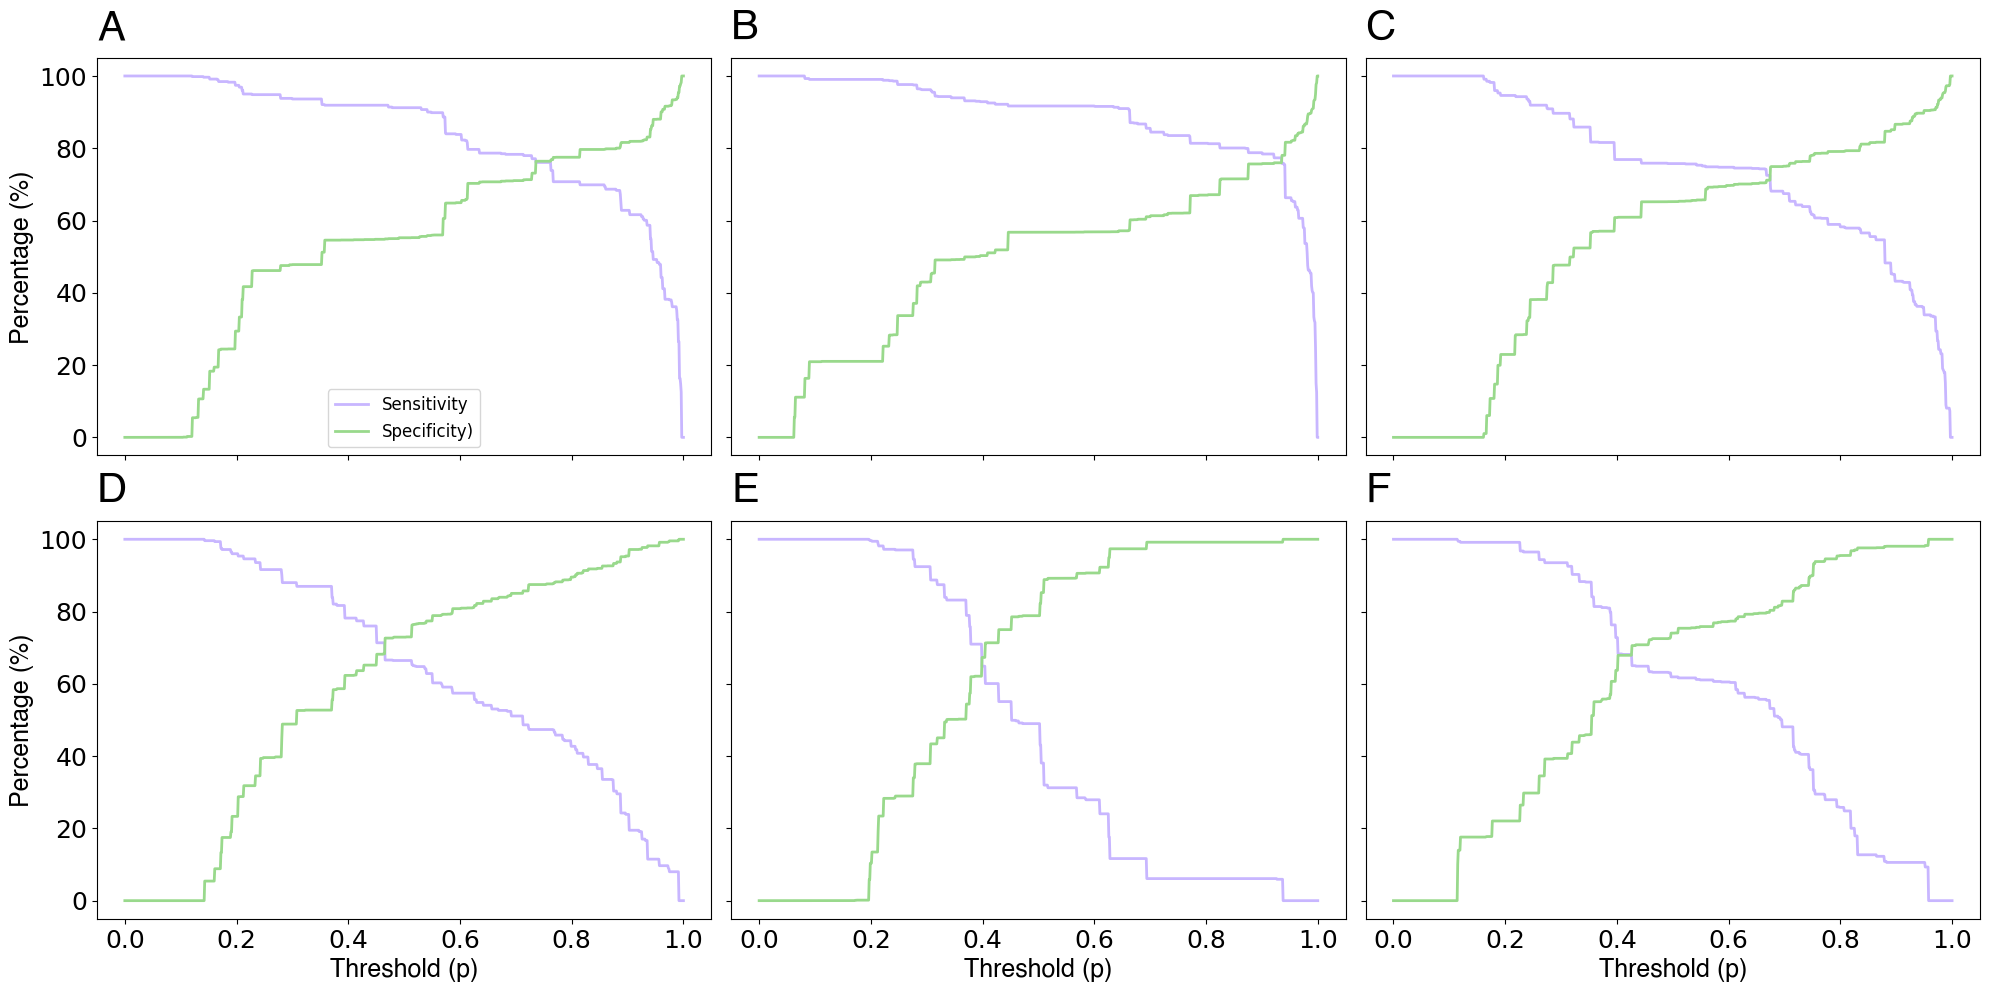

In [17]:
### Do the sensitivity by year, too... logistic regression
fig, axs = plt.subplots(2,3, figsize=(20, 10), facecolor='w', edgecolor='k', sharex = 'all', sharey = 'all')
axs[0,0].set_ylabel('Percentage (%)', fontsize = 18, **hfont)
axs[1,0].set_ylabel('Percentage (%)', fontsize = 18, **hfont)
axs[1,0].set_xlabel('Threshold (p)', fontsize = 18, **hfont)
axs[1,1].set_xlabel('Threshold (p)', fontsize = 18, **hfont)
axs[1,2].set_xlabel('Threshold (p)', fontsize = 18, **hfont)

axs[0,0].set_yticks(np.linspace(0,100,6), fontsize = 18, **hfont)
axs[1,0].set_yticks(np.linspace(0,100,6), fontsize = 18, **hfont)
axs[1,0].set_xticks(np.linspace(0,1,6), fontsize=18,**hfont)
axs[1,1].set_xticks(np.linspace(0,1,6), fontsize=18,**hfont)
axs[1,2].set_xticks(np.linspace(0,1,6), fontsize=18,**hfont)

axs[0,0].tick_params(axis='both', labelsize=18)
axs[0,1].tick_params(axis='both', labelsize=18)
axs[0,2].tick_params(axis='both', labelsize=18)
axs[1,0].tick_params(axis='both', labelsize=18)
axs[1,1].tick_params(axis='both', labelsize=18)
axs[1,2].tick_params(axis='both', labelsize=18)
axs = axs.ravel()

threshold_seq = np.linspace(0,1,1001)
i = 0
for year in years:
    years_train = np.array(range(year - 5, year))
    model_type = 0
    test_data, train_data, X_train, y_train, X_test, y_test, cipro_R_prev  =  get_test_train_data(CIP_data_no_drop = CIP_data_no_drop, year = year, feature_names = best_features_by_year_lr[year],years_train = years_train, model_type = 0)

    model_lr = LogisticRegression(class_weight = 'balanced', max_iter=4000, solver = best_hyperparameters_by_year_lr[year]['solver'], C = best_hyperparameters_by_year_lr[year]['C'], penalty = best_hyperparameters_by_year_lr[year]['penalty'])
    cipro_R_prev = y_test.sum()/len(y_test)
    ## fit model
    model_fit_train = model_lr.fit(X_train, y_train)
    y_predict_test = model_fit_train.predict(X_test)
    y_predict_proba = model_fit_train.predict_proba(X_test)
    
    ## get sesnitivity and specificity
    sensitivity_threshold, specificity_threshold, get_effective_threshold, incorrectly_get_X_threshold = effective_unnecessary_threshold(threshold_seq, y_predict_proba, y_test, cipro_R_prev)

    #plot
    axs[i].plot(threshold_seq, sensitivity_threshold, color = "#c8b6ff", label = r"Sensitivity", linewidth = 2)
    axs[i].plot(threshold_seq, specificity_threshold, color = "#99d98c", label = r"Specificity)", linewidth = 2)
    axs[i].text(axs[i].get_xlim()[0] , axs[i].get_ylim()[1] + 5, labels[i], fontsize = 30, **hfont)
    i += 1

axs[0].legend(prop={'size': 12})
plt.tight_layout()

#plt.savefig("Graphs/Sensitivity_specificity_all_workflow_paper_logistic_regression_2005_2010.png", dpi = 300)

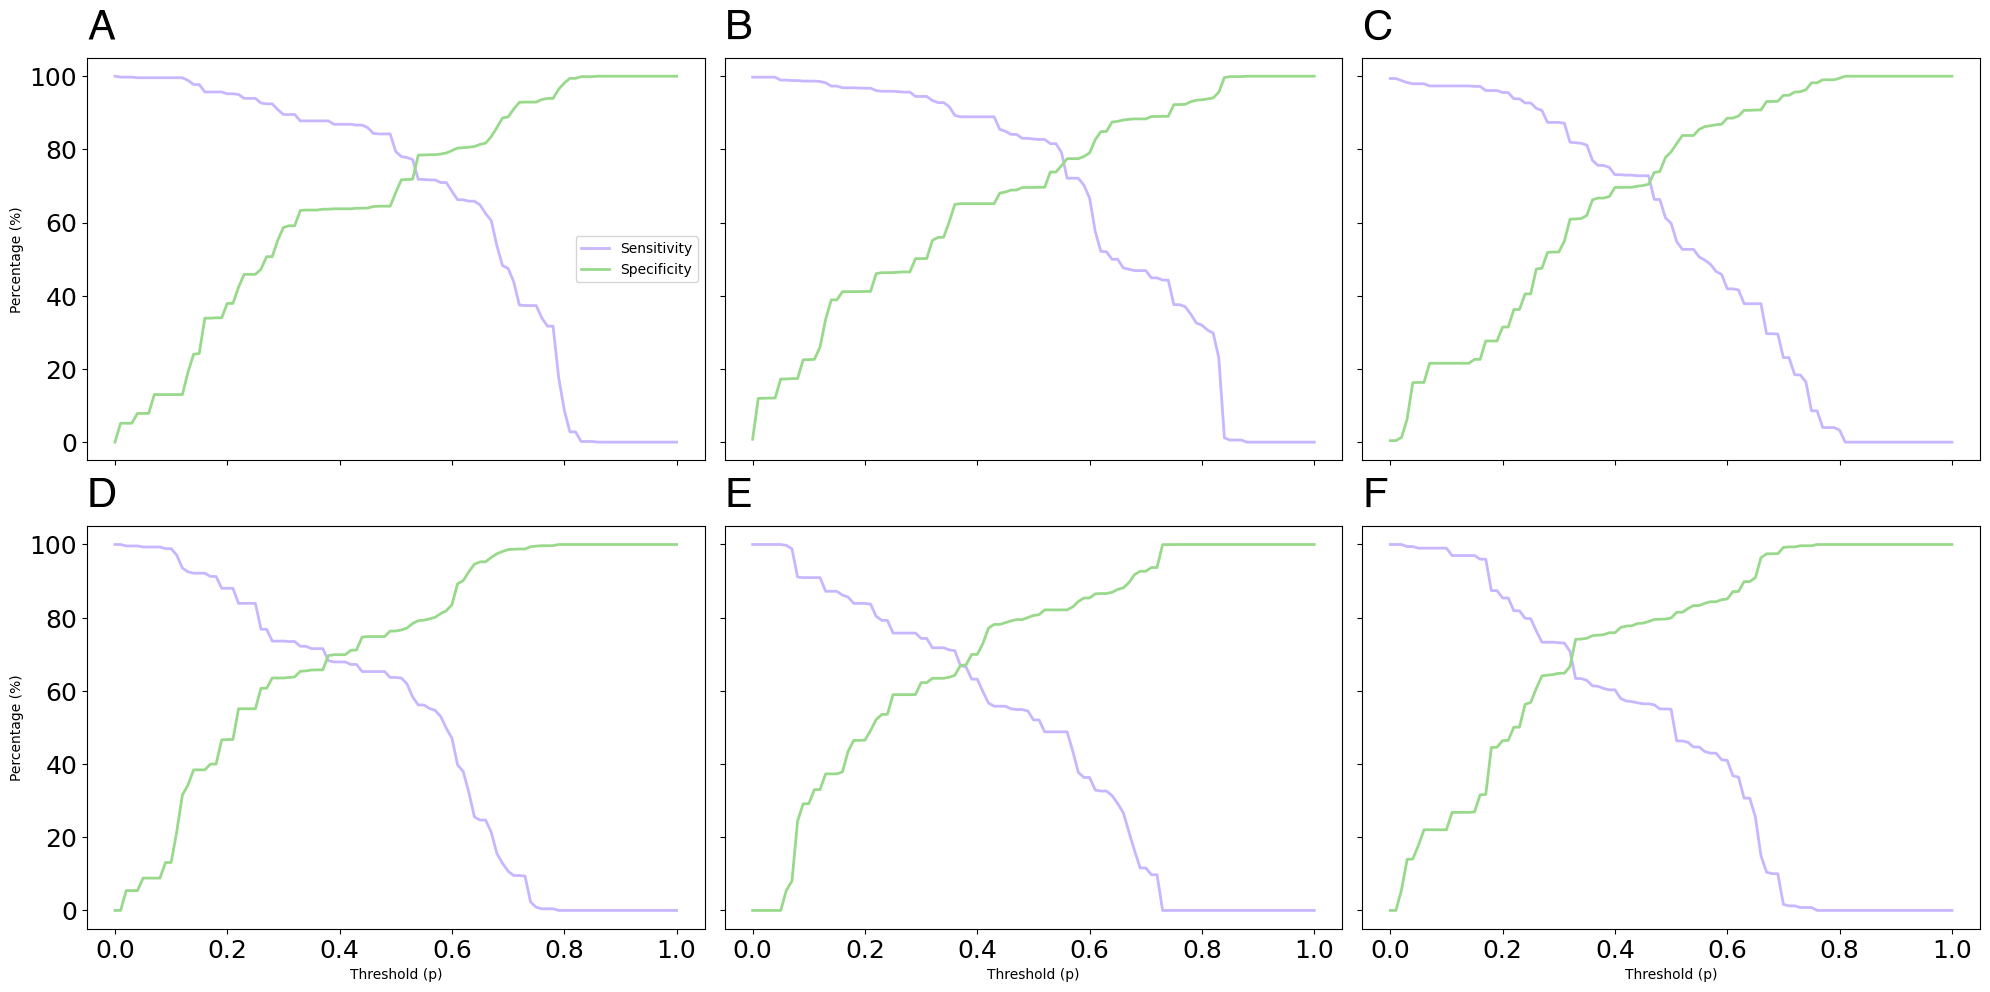

In [18]:
### Do the sensitivity by year, too... random forest 

### Do the sensitivity by year, too... logistic regression
fig, axs = plt.subplots(2,3, figsize=(20, 10), facecolor='w', edgecolor='k', sharex = 'all', sharey = 'all')
axs[0,0].set_ylabel('Percentage (%)')
axs[1,0].set_ylabel('Percentage (%)')
axs[1,0].set_xlabel('Threshold (p)')
axs[1,1].set_xlabel('Threshold (p)')
axs[1,2].set_xlabel('Threshold (p)')

axs[0,0].tick_params(axis='both', labelsize=18)
axs[0,1].tick_params(axis='both', labelsize=18)
axs[0,2].tick_params(axis='both', labelsize=18)
axs[1,0].tick_params(axis='both', labelsize=18)
axs[1,1].tick_params(axis='both', labelsize=18)
axs[1,2].tick_params(axis='both', labelsize=18)

axs[0,0].set_yticks(np.linspace(0,100,6), fontsize=14,**hfont)
axs[1,0].set_yticks(np.linspace(0,100,6), fontsize=14,**hfont)
axs[1,0].set_xticks(np.linspace(0,1,6), fontsize=14,**hfont)
axs[1,1].set_xticks(np.linspace(0,1,6), fontsize=14,**hfont)
axs[1,2].set_xticks(np.linspace(0,1,6), fontsize=14,**hfont)
axs = axs.ravel()

threshold_seq = np.linspace(0,1,1001)
i = 0
for year in years:
    model_type = 1
    years_train = np.array(range(year - 5, year))
    
    test_data, train_data, X_train, y_train, X_test, y_test, cipro_R_prev =  get_test_train_data_overfit(CIP_data_no_drop = CIP_data_no_drop, year = year, feature_names = best_features_by_year_rf[year], oversample_size = 0.5)

    model_rf = RandomForestClassifier(n_estimators = best_hyperparameters_by_year_rf[year]['n_estimators'], min_samples_split = best_hyperparameters_by_year_rf[year]['min_samples_split'], min_samples_leaf=best_hyperparameters_by_year_rf[year]['min_samples_leaf'], max_features = 'sqrt', max_depth = best_hyperparameters_by_year_rf[year]['max_depth'], random_state = 10)
    
    ## fit model
    model_fit_train = model_rf.fit(X_train, y_train)
    y_predict_test = model_fit_train.predict(X_test)
    y_predict_proba = model_fit_train.predict_proba(X_test)
    
    ## get sesnitivity and specificity
    sensitivity_threshold, specificity_threshold, get_effective_threshold, incorrectly_get_X_threshold = effective_unnecessary_threshold(threshold_seq, y_predict_proba, y_test, cipro_R_prev)

    #plot
    axs[i].plot(threshold_seq, sensitivity_threshold, color = "#c8b6ff", label = r"Sensitivity", linewidth = 2)
    axs[i].plot(threshold_seq, specificity_threshold, color = "#99d98c", label = r"Specificity", linewidth = 2)
    axs[i].text(axs[i].get_xlim()[0] , axs[i].get_ylim()[1] + 5, labels[i], fontsize = 30, **hfont)
    i += 1
axs[0].legend()
plt.tight_layout()

#plt.savefig("Graphs/Sensitivity_specificity_all_workflow_paper_random_forest_2005_2010.png", dpi = 300)

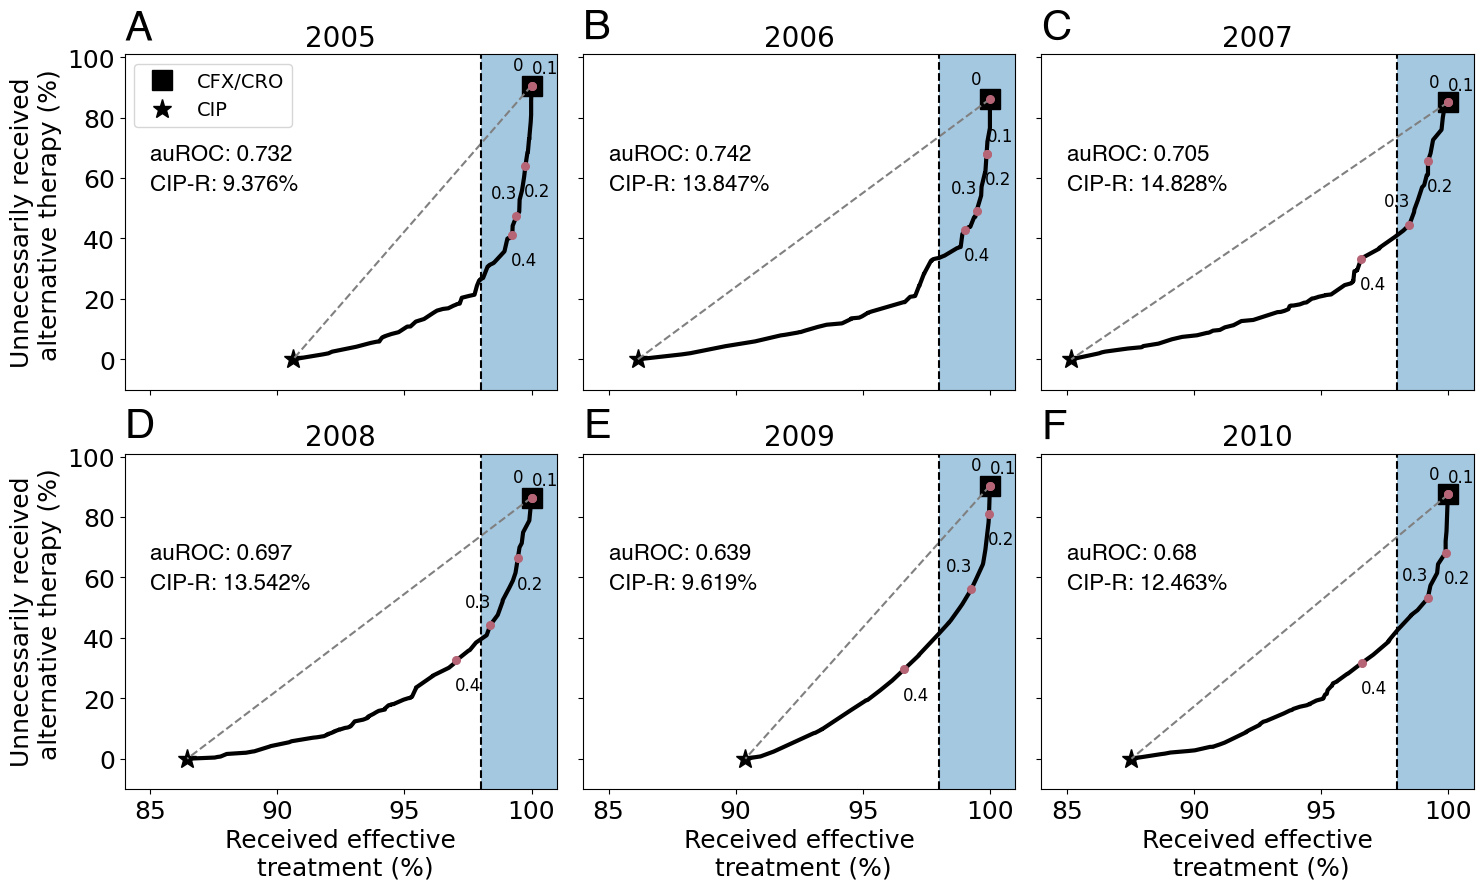

In [17]:
###### Effect of threshold on year-by-year for logistic regression
from matplotlib.patches import Polygon
polygon_important0 = Polygon([(98,110), (110,110), (110,-10), (98,-10)], alpha = 0.4)
polygon_important1 = Polygon([(98,110), (110,110), (110,-10), (98,-10)], alpha = 0.4)
polygon_important2 = Polygon([(98,110), (110,110), (110,-10), (98,-10)], alpha = 0.4)
polygon_important3 = Polygon([(98,110), (110,110), (110,-10), (98,-10)], alpha = 0.4)
polygon_important4 = Polygon([(98,110), (110,110), (110,-10), (98,-10)], alpha = 0.4)
polygon_important5 = Polygon([(98,110), (110,110), (110,-10), (98,-10)], alpha = 0.4)

fig, axs = plt.subplots(2,3, figsize=(15, 9), facecolor='w', edgecolor='k', sharex = 'all', sharey = 'all')

text_for_graph = ['0', '0.1', '0.2', '0.3', '0.4'] #, '0.5', '0.6', '0.7', '0.8', '0.9', '1']
indices = [0, 100, 200, 300, 400] #, 500, 600, 700, 800, 900, 1000]
axs[0,0].tick_params(axis='both', which='major', labelsize=18)
axs[1,0].tick_params(axis='both', which='major', labelsize=18)
axs[1,1].tick_params(axis='both', which='major', labelsize=18)
axs[1,2].tick_params(axis='both', which='major', labelsize=18)

axs[0,0].set_ylabel("Unnecessarily received\n  alternative therapy (%)", fontsize = 18)
axs[1,0].set_ylabel("Unnecessarily received\n  alternative therapy (%)", fontsize = 18)
axs[1,0].set_xlabel("Received effective\n treatment (%)", fontsize = 18)
axs[1,1].set_xlabel("Received effective\n treatment (%)", fontsize = 18)
axs[1,2].set_xlabel("Received effective\n treatment (%)", fontsize = 18)

axs[0,0].set_yticks(np.linspace(0,100,6), labelsize=18,**hfont)
axs[1,0].set_yticks(np.linspace(0,100,6), fontsize=18,**hfont)
axs[1,0].set_xticks([85, 90, 95, 100], fontsize=18,**hfont)
axs[1,1].set_xticks([85, 90, 95, 100], fontsize=18,**hfont)
axs[1,2].set_xticks([85, 90, 95, 100], fontsize=18,**hfont)


axs[0,0].set_ylim([0-10,101])
axs[0,0].set_xlim([84, 101])
axs = axs.ravel()
unneccessary_treatment_98_efficacy_lr = []
threshold_seq = np.linspace(0,1,1001)
i = 0
for year in years:
    years_train = np.array(range(year - 5, year))
    
    model_lr = LogisticRegression(class_weight = 'balanced', max_iter=4000, solver = best_hyperparameters_by_year_lr[year]['solver'], C = best_hyperparameters_by_year_lr[year]['C'], penalty = best_hyperparameters_by_year_lr[year]['penalty'])

    test_data, train_data, X_train, y_train, X_test, y_test, cipro_R_prev  =  get_test_train_data(CIP_data_no_drop = CIP_data_no_drop, year = year, feature_names = best_features_by_year_lr[year],years_train = years_train, model_type = 0)
    ## fit model
    model_fit_train = model_lr.fit(X_train, y_train)
    y_predict_test = model_fit_train.predict(X_test)
    y_predict_proba = model_fit_train.predict_proba(X_test)
    
    ## get sesnitivity and specificity
    sensitivity_threshold, specificity_threshold, get_effective_threshold, incorrectly_get_X_threshold = effective_unnecessary_threshold(threshold_seq, y_predict_proba, y_test, cipro_R_prev)
    unneccessary_treatment_98_efficacy_lr.append(incorrectly_get_X_threshold[get_effective_threshold.index(min([x for x in get_effective_threshold if x >= 98]))] )

    #plot
    axs[i].plot(get_effective_threshold, incorrectly_get_X_threshold, color = "black", linewidth = 3)
    axs[i].plot(100, (1 - cipro_R_prev)*100, marker='s', ls='none', ms=14, color = "black", label = "CRO/CFX")
    axs[i].plot((1-cipro_R_prev)*100, 0, marker='*', ls='none', ms=14, color = "black", label = "CIP")
    axs[i].plot([100, (1-cipro_R_prev)*100], [(1-cipro_R_prev)*100, 0], color = "#808080", linestyle="--")
    axs[i].text(axs[i].get_xlim()[0] , axs[i].get_ylim()[1] + 5, labels[i], fontsize = 30, **hfont)
    axs[i].set_title(year,fontsize=20)  
    axs[i].text(axs[i].get_xlim()[0] + 1 , axs[i].get_ylim()[1] - 35, f'auROC: {round(ROC_by_year_lr[year], 3)}', fontsize = 16, **hfont)
    axs[i].text(axs[i].get_xlim()[0] + 1 , axs[i].get_ylim()[1] - 45, f'CIP-R: {round(cipro_R_prev*100, 3)}%', fontsize = 16, **hfont)
    axs[i].axvline(x = 98, color = 'black', linestyle="--")
    x = 0
    for index in indices:
        axs[i].plot(get_effective_threshold[index], incorrectly_get_X_threshold[index], marker='.', ls='none', ms=11, color = "#b56576")
        if index in (300, 500, 700, 900):
            if year == 2009 & index == 700:
                axs[i].text(get_effective_threshold[index] , incorrectly_get_X_threshold[index] + 6, text_for_graph[x], size = 12)
            else:
                axs[i].text(get_effective_threshold[index] - 1, incorrectly_get_X_threshold[index] + 6, text_for_graph[x], size = 12)
        elif index in (200, 400, 800, 1000):
            axs[i].text(get_effective_threshold[index] - 0.05, incorrectly_get_X_threshold[index] - 10, text_for_graph[x], size = 12)
        elif index == 600:
            axs[i].text(get_effective_threshold[index] - 0.25, incorrectly_get_X_threshold[index] - 7, text_for_graph[x], size = 12)
        elif index == 100:
            axs[i].text(get_effective_threshold[index] , incorrectly_get_X_threshold[index]  +4, text_for_graph[x], size = 12)
        elif index == 0:
            axs[i].text(get_effective_threshold[index] - 0.75, incorrectly_get_X_threshold[index] + 5, text_for_graph[x], size = 12)
        
        x = x+1
    i += 1

plt.tight_layout()
axs[0].legend(prop={'size':14})
axs[0].add_patch(polygon_important0)
axs[1].add_patch(polygon_important1)
axs[2].add_patch(polygon_important2)
axs[3].add_patch(polygon_important3)
axs[4].add_patch(polygon_important4)
axs[5].add_patch(polygon_important5)
#plt.savefig('Graphs/Percent_effective_unnecessary_all_logistic_regression_2005_2010.png', dpi = 300)
#

Oversample
Oversample
Oversample
Oversample
Oversample
Oversample


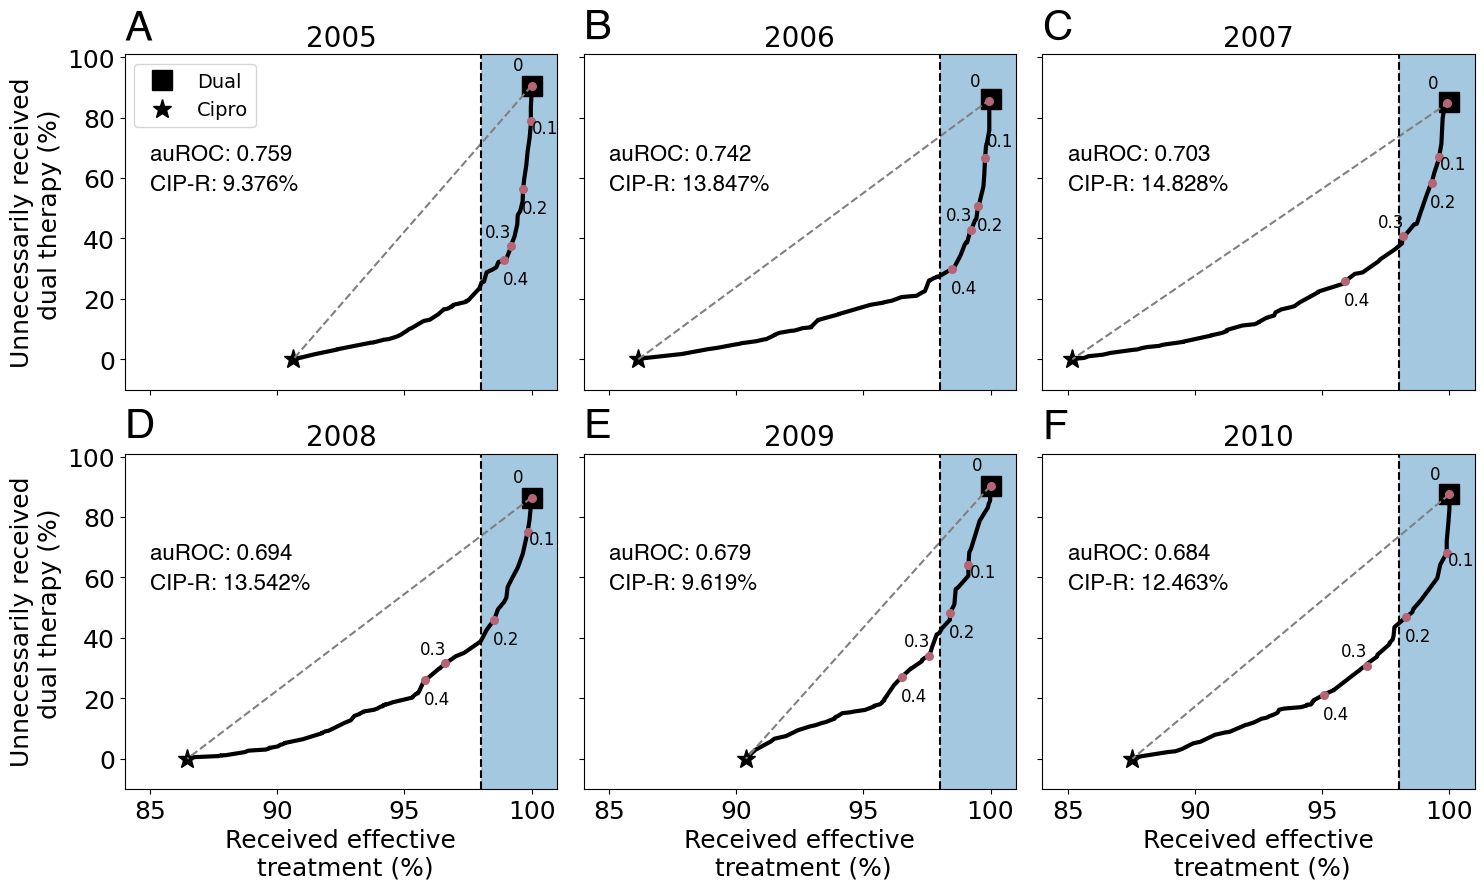

In [74]:
###### Effect of threshold on year-by-year for random forest model 
from matplotlib.patches import Polygon

fig, axs = plt.subplots(2,3, figsize=(15, 9), facecolor='w', edgecolor='k', sharex = 'all', sharey = 'all')
polygon_important0 = Polygon([(98,110), (110,110), (110,-10), (98,-10)], alpha = 0.4)
polygon_important1 = Polygon([(98,110), (110,110), (110,-10), (98,-10)], alpha = 0.4)
polygon_important2 = Polygon([(98,110), (110,110), (110,-10), (98,-10)], alpha = 0.4)
polygon_important3 = Polygon([(98,110), (110,110), (110,-10), (98,-10)], alpha = 0.4)
polygon_important4 = Polygon([(98,110), (110,110), (110,-10), (98,-10)], alpha = 0.4)
polygon_important5 = Polygon([(98,110), (110,110), (110,-10), (98,-10)], alpha = 0.4)

axs[0,0].tick_params(axis='both', which='major', labelsize=18)
axs[1,0].tick_params(axis='both', which='major', labelsize=18)
axs[1,1].tick_params(axis='both', which='major', labelsize=18)
axs[1,2].tick_params(axis='both', which='major', labelsize=18)

axs[0,0].set_ylabel("Unnecessarily received\n  CRO/CFX (%)", fontsize = 18)
axs[1,0].set_ylabel("Unnecessarily received\n  CRO/CFX (%)", fontsize = 18)
axs[1,0].set_xlabel("Received effective\n treatment (%)", fontsize = 18)
axs[1,1].set_xlabel("Received effective\n treatment (%)", fontsize = 18)
axs[1,2].set_xlabel("Received effective\n treatment (%)", fontsize = 18)

axs[0,0].set_yticks(np.linspace(0,100,6), labelsize=18,**hfont)
axs[1,0].set_yticks(np.linspace(0,100,6), fontsize=18,**hfont)
axs[1,0].set_xticks([85, 90, 95, 100], fontsize=18,**hfont)
axs[1,1].set_xticks([85, 90, 95, 100], fontsize=18,**hfont)
axs[1,2].set_xticks([85, 90, 95, 100], fontsize=18,**hfont)

axs[0,0].set_ylim([0-10,101])
axs[0,0].set_xlim([84, 101])

axs = axs.ravel()

cip_R_all_years = []
threshold_seq = np.linspace(0,1,1001)
unneccessary_treatment_98_efficacy_rf = []
i = 0
for year in years:
    years_train = np.array(range(year - 5, year))
    
    test_data, train_data, X_train, y_train, X_test, y_test, cipro_R_prev  =  get_test_train_data(CIP_data_no_drop = CIP_data_no_drop, year = year, feature_names = best_features_by_year_rf[year],years_train = years_train, model_type = 1)
    cip_R_all_years.append(cipro_R_prev)
    model_rf = RandomForestClassifier(n_estimators = best_hyperparameters_by_year_rf[year]['n_estimators'], min_samples_split = best_hyperparameters_by_year_rf[year]['min_samples_split'], min_samples_leaf=best_hyperparameters_by_year_rf[year]['min_samples_leaf'], max_features = 'sqrt', max_depth = best_hyperparameters_by_year_rf[year]['max_depth'], random_state = 10)
    
    ## fit model
    model_fit_train = model_rf.fit(X_train, y_train)
    y_predict_test = model_fit_train.predict(X_test)
    y_predict_proba = model_fit_train.predict_proba(X_test)
    
    ## get sesnitivity and specificity
    sensitivity_threshold, specificity_threshold, get_effective_threshold, incorrectly_get_X_threshold = effective_unnecessary_threshold(threshold_seq, y_predict_proba, y_test, cipro_R_prev)
    unneccessary_treatment_98_efficacy_rf.append(incorrectly_get_X_threshold[get_effective_threshold.index(min([x for x in get_effective_threshold if x >= 98]))] )

    #plot
    axs[i].plot(get_effective_threshold, incorrectly_get_X_threshold, color = "black", linewidth = 3)
    axs[i].plot(100, (1 - cipro_R_prev)*100, marker='s', ls='none', ms=14, color = "black", label = "CRO/CFX")
    axs[i].plot((1-cipro_R_prev)*100, 0, marker='*', ls='none', ms=14, color = "black", label = "CIP")
    axs[i].plot([100, (1-cipro_R_prev)*100], [(1-cipro_R_prev)*100, 0], color = "#808080", linestyle="--")
    axs[i].text(axs[i].get_xlim()[0] , axs[i].get_ylim()[1] + 5, labels[i], fontsize = 30, **hfont)
    axs[i].set_title(year,fontsize=20)  
    axs[i].text(axs[i].get_xlim()[0] + 1 , axs[i].get_ylim()[1] - 35, f'auROC: {round(ROC_by_year_rf[year], 3)}', fontsize = 16, **hfont)
    axs[i].text(axs[i].get_xlim()[0] + 1 , axs[i].get_ylim()[1] - 45, f'CIP-R: {round(cipro_R_prev*100, 3)}%', fontsize = 16, **hfont)
    axs[i].axvline(x = 98, color = 'black', linestyle="--")
    x = 0
    for index in indices:
        axs[i].plot(get_effective_threshold[index], incorrectly_get_X_threshold[index], marker='.', ls='none', ms=11, color = "#b56576")
        if index in (300, 500, 700, 900):
            if year == 2009 & index == 700:
                axs[i].text(get_effective_threshold[index] , incorrectly_get_X_threshold[index] + 3, text_for_graph[x], size = 12)
            else:
                axs[i].text(get_effective_threshold[index] - 1, incorrectly_get_X_threshold[index] + 3, text_for_graph[x], size = 12)
        elif index in (200, 400, 800, 1000):
            axs[i].text(get_effective_threshold[index] - 0.05, incorrectly_get_X_threshold[index] - 8, text_for_graph[x], size = 12)
        elif index == 600:
            axs[i].text(get_effective_threshold[index] - 0.25, incorrectly_get_X_threshold[index] - 7, text_for_graph[x], size = 12)
        elif index == 100:
            if year == 2006:
                axs[i].text(get_effective_threshold[index] + 0.075, incorrectly_get_X_threshold[index]  +4, text_for_graph[x], size = 12)
            else:
                axs[i].text(get_effective_threshold[index] + 0.05 , incorrectly_get_X_threshold[index] -4, text_for_graph[x], size = 12)
        elif index == 0:
            axs[i].text(get_effective_threshold[index] - 0.75, incorrectly_get_X_threshold[index] + 5, text_for_graph[x], size = 12)
        
        x = x+1
    i += 1

plt.tight_layout()

axs[0].legend(prop={'size':14})
axs[0].add_patch(polygon_important0)
axs[1].add_patch(polygon_important1)
axs[2].add_patch(polygon_important2)
axs[3].add_patch(polygon_important3)
axs[4].add_patch(polygon_important4)
axs[5].add_patch(polygon_important5)
#plt.savefig('Graphs/Percent_effective_unnecessary_all_random_forest_2005_2010.png', dpi = 300)
#

Oversample
Oversample
Oversample
Oversample
Oversample
Oversample


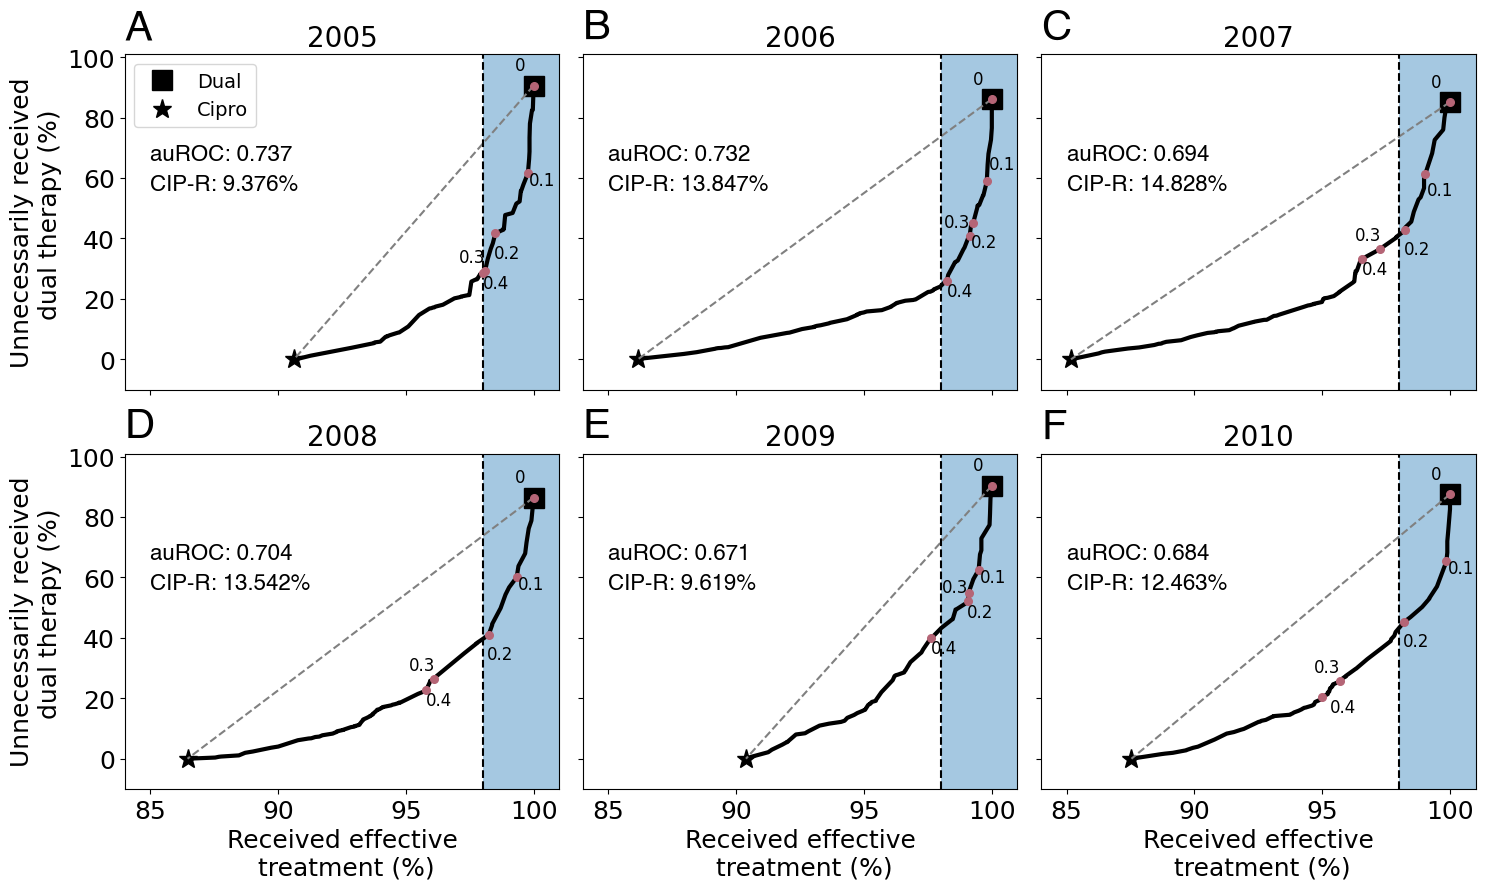

In [94]:
###### Effect of threshold on year-by-year for neural network
fig, axs = plt.subplots(2,3, figsize=(15, 9), facecolor='w', edgecolor='k', sharex = 'all', sharey = 'all')
#text_for_graph = ['0', '0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8', '0.9', '1']
#indices = [0,10,20,30,40,50,60,70,80,90,100]
polygon_important0 = Polygon([(98,110), (110,110), (110,-10), (98,-10)], alpha = 0.4)
polygon_important1 = Polygon([(98,110), (110,110), (110,-10), (98,-10)], alpha = 0.4)
polygon_important2 = Polygon([(98,110), (110,110), (110,-10), (98,-10)], alpha = 0.4)
polygon_important3 = Polygon([(98,110), (110,110), (110,-10), (98,-10)], alpha = 0.4)
polygon_important4 = Polygon([(98,110), (110,110), (110,-10), (98,-10)], alpha = 0.4)
polygon_important5 = Polygon([(98,110), (110,110), (110,-10), (98,-10)], alpha = 0.4)

axs[0,0].tick_params(axis='both', which='major', labelsize=18)
axs[1,0].tick_params(axis='both', which='major', labelsize=18)
axs[1,1].tick_params(axis='both', which='major', labelsize=18)
axs[1,2].tick_params(axis='both', which='major', labelsize=18)

axs[0,0].set_ylabel("Unnecessarily received\n  CRO/CFX (%)", fontsize = 18)
axs[1,0].set_ylabel("Unnecessarily received\n  CRO/CFX (%)", fontsize = 18)
axs[1,0].set_xlabel("Received effective\n treatment (%)", fontsize = 18)
axs[1,1].set_xlabel("Received effective\n treatment (%)", fontsize = 18)
axs[1,2].set_xlabel("Received effective\n treatment (%)", fontsize = 18)

axs[0,0].set_yticks(np.linspace(0,100,6), labelsize=18,**hfont)
axs[1,0].set_yticks(np.linspace(0,100,6), fontsize=18,**hfont)
axs[1,0].set_xticks([85, 90, 95, 100], fontsize=18,**hfont)
axs[1,1].set_xticks([85, 90, 95, 100], fontsize=18,**hfont)
axs[1,2].set_xticks([85, 90, 95, 100], fontsize=18,**hfont)

axs[0,0].set_ylim([0-10,101])
axs[0,0].set_xlim([84, 101])

axs = axs.ravel()

unneccessary_treatment_98_efficacy_nn = []
years = [2005, 2006, 2007, 2008, 2009, 2010]
i = 0
for year in years:
    years_train = np.array(range(year - 5, year))
    
    model_nn = MLPClassifier(solver = best_hyperparameters_by_year_nn[year]['solver'], activation = best_hyperparameters_by_year_nn[year]['activation'], max_iter = 3000 ,hidden_layer_sizes= best_hyperparameters_by_year_nn[year]['hidden_layer_sizes'], alpha =  best_hyperparameters_by_year_nn[year]['alpha'], random_state=10, learning_rate = best_hyperparameters_by_year_nn[year]['learning_rate'] )

    test_data, train_data, X_train, y_train, X_test, y_test, cipro_R_prev  =  get_test_train_data(CIP_data_no_drop = CIP_data_no_drop, year = year, feature_names = best_features_by_year_nn[year],years_train = years_train, model_type = 2)
   
    ## fit model
    model_fit_train = model_nn.fit(X_train, y_train)
    y_predict_test = model_fit_train.predict(X_test)
    y_predict_proba = model_fit_train.predict_proba(X_test)
    
    ## get sesnitivity and specificity
    sensitivity_threshold, specificity_threshold, get_effective_threshold, incorrectly_get_X_threshold = effective_unnecessary_threshold(threshold_seq, y_predict_proba, y_test, cipro_R_prev)
    unneccessary_treatment_98_efficacy_nn.append(incorrectly_get_X_threshold[get_effective_threshold.index(min([x for x in get_effective_threshold if x >= 98]))] )
    #plot
    axs[i].plot(get_effective_threshold, incorrectly_get_X_threshold, color = "black", linewidth = 3)
    axs[i].plot(100, (1 - cipro_R_prev)*100, marker='s', ls='none', ms=14, color = "black", label = "CRO/CFX")
    axs[i].plot((1-cipro_R_prev)*100, 0, marker='*', ls='none', ms=14, color = "black", label = "CIP")
    axs[i].plot([100, (1-cipro_R_prev)*100], [(1-cipro_R_prev)*100, 0], color = "#808080", linestyle="--")
    axs[i].text(axs[i].get_xlim()[0] , axs[i].get_ylim()[1] + 5, labels[i], fontsize = 30, **hfont)
    axs[i].set_title(year,fontsize=20)  
    axs[i].text(axs[i].get_xlim()[0] + 1 , axs[i].get_ylim()[1] - 35, f'auROC: {round(ROC_by_year_nn[year], 3)}', fontsize = 16, **hfont)
    axs[i].text(axs[i].get_xlim()[0] + 1 , axs[i].get_ylim()[1] - 45, f'CIP-R: {round(cipro_R_prev*100, 3)}%', fontsize = 16, **hfont)
    axs[i].axvline(x = 98, color = 'black', linestyle="--")
    x = 0
    for index in indices:
        axs[i].plot(get_effective_threshold[index], incorrectly_get_X_threshold[index], marker='.', ls='none', ms=11, color = "#b56576")
        if index in (300, 500, 700, 900):
            if year == 2009 & index == 700:
                axs[i].text(get_effective_threshold[index] , incorrectly_get_X_threshold[index] + 3, text_for_graph[x], size = 12)
            else:
                axs[i].text(get_effective_threshold[index] - 1, incorrectly_get_X_threshold[index] + 3, text_for_graph[x], size = 12)
        elif index in (200, 800, 1000):
            axs[i].text(get_effective_threshold[index] - 0.05, incorrectly_get_X_threshold[index] - 8, text_for_graph[x], size = 12)
        elif index == 400:
            if year == 2010:
                axs[i].text(get_effective_threshold[index] +0.3, incorrectly_get_X_threshold[index] - 5, text_for_graph[x], size = 12)

            else:
                axs[i].text(get_effective_threshold[index] , incorrectly_get_X_threshold[index] - 5, text_for_graph[x], size = 12)
        elif index == 100:
            if year == 2006:
                axs[i].text(get_effective_threshold[index] + 0.075, incorrectly_get_X_threshold[index]  +4, text_for_graph[x], size = 12)
            elif year == 2007:
                axs[i].text(get_effective_threshold[index] + 0.075, incorrectly_get_X_threshold[index]  -7, text_for_graph[x], size = 12)
            else:
                axs[i].text(get_effective_threshold[index] + 0.05 , incorrectly_get_X_threshold[index] -4, text_for_graph[x], size = 12)
        elif index == 0:
            axs[i].text(get_effective_threshold[index] - 0.75, incorrectly_get_X_threshold[index] + 5, text_for_graph[x], size = 12)
        
        x = x+1
    i += 1

plt.tight_layout()
axs[0].legend(prop={'size':14})
axs[0].add_patch(polygon_important0)
axs[1].add_patch(polygon_important1)
axs[2].add_patch(polygon_important2)
axs[3].add_patch(polygon_important3)
axs[4].add_patch(polygon_important4)
axs[5].add_patch(polygon_important5)
#plt.savefig('Graphs/Percent_effective_unnecessary_all_neural_network_2005_2010.png', dpi = 300)

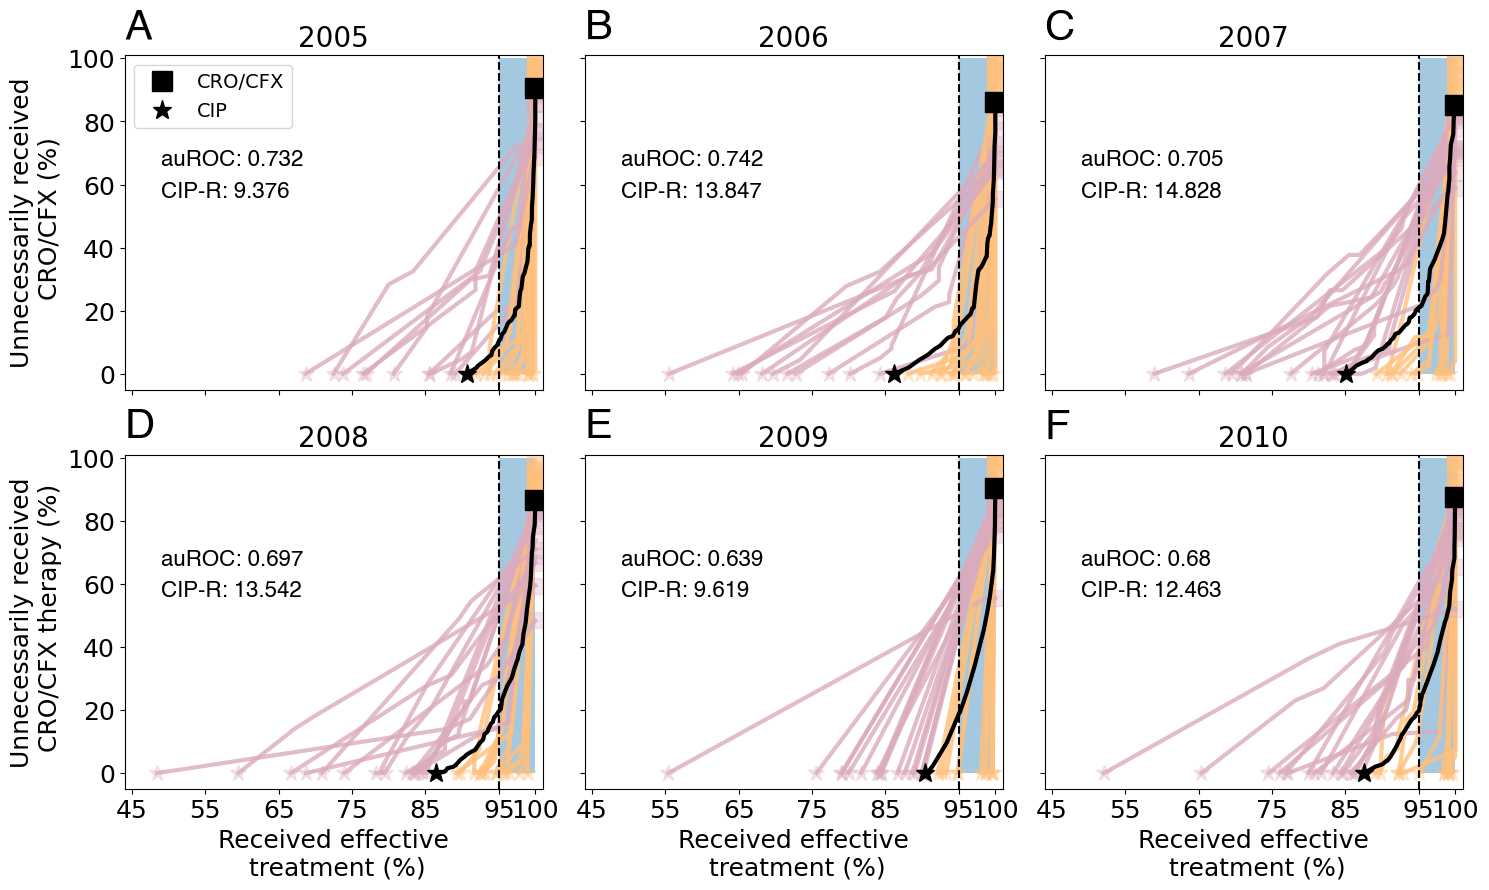

In [22]:
### Leave one out validation for logistic regression 
from matplotlib.patches import Polygon
polygon_important0 = Polygon([(95,100), (100,100), (100,0), (95,0)], alpha = 0.4)
polygon_important1 = Polygon([(95,100), (100,100), (100,0), (95,0)], alpha = 0.4)
polygon_important2 = Polygon([(95,100), (100,100), (100,0), (95,0)], alpha = 0.4)
polygon_important3 = Polygon([(95,100), (100,100), (100,0), (95,0)], alpha = 0.4)
polygon_important4 = Polygon([(95,100), (100,100), (100,0), (95,0)], alpha = 0.4)
polygon_important5 = Polygon([(95,100), (100,100), (100,0), (95,0)], alpha = 0.4)

fig, axs = plt.subplots(2,3, figsize=(15, 9), facecolor='w', edgecolor='k', sharex = 'all', sharey = 'all')

labels = ["A", "B", "C", "D", "E", "F" ]

axs[0,0].tick_params(axis='both', which='major', labelsize=18)
axs[1,0].tick_params(axis='both', which='major', labelsize=18)
axs[1,1].tick_params(axis='both', which='major', labelsize=18)
axs[1,2].tick_params(axis='both', which='major', labelsize=18)
axs[0,0].set_ylabel("Unnecessarily received\n CRO/CFX (%)", fontsize = 18)
axs[1,0].set_ylabel("Unnecessarily received\n CRO/CFX therapy (%)", fontsize = 18)
axs[1,0].set_xlabel("Received effective\n treatment (%)", fontsize = 18)
axs[1,1].set_xlabel("Received effective\n treatment (%)", fontsize = 18)
axs[1,2].set_xlabel("Received effective\n treatment (%)", fontsize = 18)
axs[0,0].set_yticks(np.linspace(0,100,6), labelsize=18,**hfont)
axs[1,0].set_yticks(np.linspace(0,100,6), fontsize=18,**hfont)
axs[1,0].set_xticks([45, 55, 65, 75, 85, 95, 100], fontsize=17,**hfont)
axs[1,1].set_xticks([45, 55, 65, 75, 85, 95, 100], fontsize=17,**hfont)
axs[1,2].set_xticks([45, 55, 65, 75, 85, 95, 100], fontsize=17,**hfont)


axs[0,0].set_ylim([0-5,101])
axs[0,0].set_xlim([44, 101])
axs[0,1].set_ylim([0-5,101])
axs[0,1].set_xlim([44, 101])
axs[0,2].set_ylim([0-5,101])
axs[0,2].set_xlim([44, 101])
axs[1,0].set_ylim([0-5,101])
axs[1,0].set_xlim([44, 101])
axs[1,1].set_ylim([0-5,101])
axs[1,1].set_xlim([44, 101])
axs[1,2].set_ylim([0-5,101])
axs[1,2].set_xlim([44, 101])
fig.subplots_adjust(hspace = .15, wspace=.1)
axs = axs.ravel()
i = 0
threshold_seq = np.linspace(0,1,1001)

years = [2005, 2006, 2007, 2008, 2009, 2010]
for year in years: 
    years_train = np.array(range(year - 5, year))

    # first do for all clinics 

    CIP_data_training_years = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin(years_train)]
    CIP_data_testing_years = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([year])]


    test_data, train_data, X_train, y_train, X_test, y_test, cipro_R_prev  =  get_test_train_data(CIP_data_no_drop = CIP_data_no_drop, year = year, feature_names = best_features_by_year_lr[year],years_train = years_train, model_type = 0)
    model_lr = LogisticRegression(class_weight = 'balanced', max_iter=4000, solver = best_hyperparameters_by_year_lr[year]['solver'], C = best_hyperparameters_by_year_lr[year]['C'], penalty = best_hyperparameters_by_year_lr[year]['penalty'])
    
    ## fit model
    model_fit_train = model_lr.fit(X_train, y_train)
    y_predict_test = model_fit_train.predict(X_test)
    y_predict_proba = model_fit_train.predict_proba(X_test)
 
    senstivitity_threshold_all, specificity_threshold_all, get_effective_threshold_all, incorrectly_get_X_threshold_all = effective_unnecessary_threshold(threshold_seq, y_predict_proba, y_test, cipro_R_prev)


    clinics = CIP_data_testing_years["CLINIC"].unique()
    for clinic in clinics: 
        train_data = CIP_data_training_years.loc[CIP_data_training_years['CLINIC'] != clinic]

          #train data - does not have clinic
        X_train = train_data[best_features_by_year_lr[year]]
        y_train = 1 - train_data['Susceptible']

          #test data - has clinic 
        test_data = CIP_data_testing_years.loc[CIP_data_testing_years['CLINIC'] == clinic]
        X_test = test_data[best_features_by_year_lr[year]]
        y_test = 1 - test_data['Susceptible']
        cipro_R = y_test.sum()/len(y_test)

        if cipro_R > 0: 
          try:
          # test 
            
              model_fit_train = model_lr.fit(X_train, y_train)
              y_predict_test = model_fit_train.predict(X_test)
              y_predict_proba = model_fit_train.predict_proba(X_test)
              senstivitity_threshold_clinic, specificity_threshold_clinic, get_effective_threshold_clinic, incorrectly_get_X_threshold_clinic = effective_unnecessary_threshold(threshold_seq, y_predict_proba, y_test, cipro_R)
              if cipro_R_prev < cipro_R:
                col = '#DBABBE'
                alpha_graph = 0.8
              else:
                 col = '#ffc07c'
                 alpha_graph = 0.8
              axs[i].plot(get_effective_threshold_clinic, incorrectly_get_X_threshold_clinic,color = col, linewidth = 3, alpha=alpha_graph)
              #axs[i].plot(get_effective_threshold_clinic[0:index_for_plot], incorrectly_get_X_threshold_clinic[0:index_for_plot],color = "#457b9d", linewidth = 3, alpha=0.7)

              axs[i].plot(100, (1 - cipro_R)*100, marker='s', ls='none', ms=12, color = col, alpha=0.3)
              axs[i].plot((1-cipro_R)*100, 0, marker='*', ls='none', ms=12, color = col, alpha=0.3)
   

          
          except ValueError:

              pass

    index_for_plot = np.max(np.where(np.array(get_effective_threshold_all)>95))

    axs[i].plot(get_effective_threshold_all, incorrectly_get_X_threshold_all,color = "black", linewidth = 3)
    #axs[i].plot(get_effective_threshold_all[0:index_for_plot], incorrectly_get_X_threshold_all[0:index_for_plot],color = "#457b9d", linewidth = 3)

    axs[i].plot(100, (1 - cipro_R_prev)*100, marker='s', ls='none', ms=14, color = "black", label = "CRO/CFX")
    axs[i].plot((1-cipro_R_prev)*100, 0, marker='*', ls='none', ms=14, color = "black", label = "CIP")
    axs[i].text(axs[i].get_xlim()[0] , axs[i].get_ylim()[1] + 5, labels[i], fontsize = 30, **hfont)
    axs[i].axvline(x = 95, color = 'black', linestyle="--")

    axs[i].set_ylim([0-5,101])
    axs[i].set_xlim([44, 101])
    axs[i].text(axs[i].get_xlim()[0] + 5 , axs[i].get_ylim()[1] - 35, f'auROC: {round(ROC_by_year_lr[year], 3)}', fontsize = 16, **hfont)
    axs[i].text(axs[i].get_xlim()[0] + 5 , axs[i].get_ylim()[1] - 45, f'CIP-R: {round(cipro_R_prev*100, 3)}', fontsize = 16, **hfont)
    axs[i].set_title(year,fontsize=20)   

    i += 1   #
axs[0].legend(prop={'size':14})

axs[0].add_patch(polygon_important0)
axs[1].add_patch(polygon_important1)
axs[2].add_patch(polygon_important2)
axs[3].add_patch(polygon_important3)
axs[4].add_patch(polygon_important4)
axs[5].add_patch(polygon_important5)

plt.tight_layout()
#plt.savefig("Graphs/LOOCV_effective_unnecessary_all_workflow_paper_logistic_regression_2005_2010_coloured.png", dpi = 300)

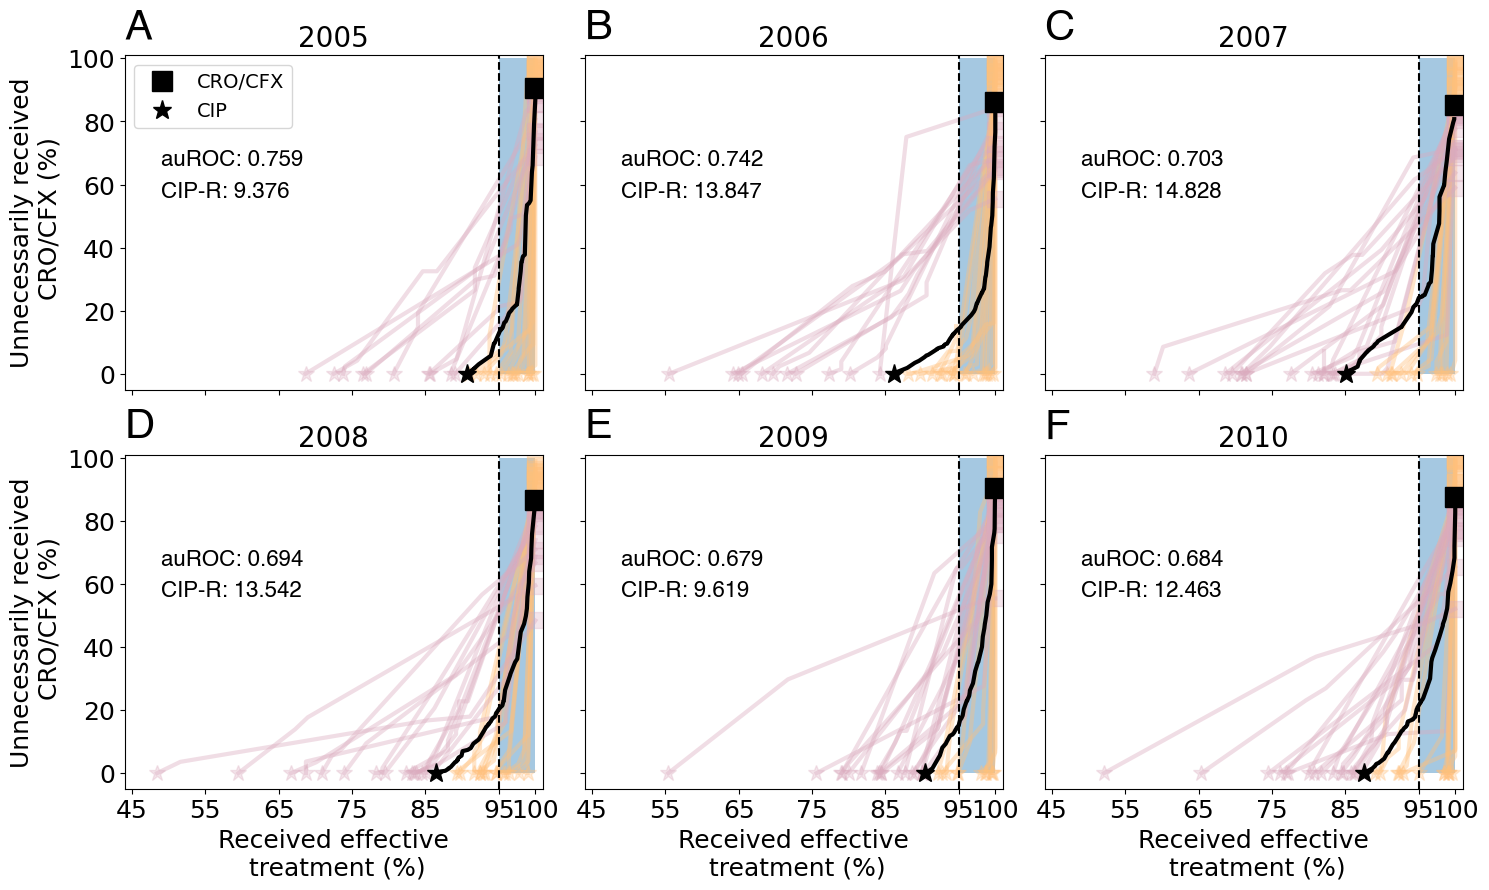

In [23]:
### Leave one out validation for random forest
polygon_important0 = Polygon([(95,100), (100,100), (100,0), (95,0)], alpha = 0.4)
polygon_important1 = Polygon([(95,100), (100,100), (100,0), (95,0)], alpha = 0.4)
polygon_important2 = Polygon([(95,100), (100,100), (100,0), (95,0)], alpha = 0.4)
polygon_important3 = Polygon([(95,100), (100,100), (100,0), (95,0)], alpha = 0.4)
polygon_important4 = Polygon([(95,100), (100,100), (100,0), (95,0)], alpha = 0.4)
polygon_important5 = Polygon([(95,100), (100,100), (100,0), (95,0)], alpha = 0.4)

##"full model"
fig, axs = plt.subplots(2,3, figsize=(15, 9), facecolor='w', edgecolor='k', sharex = 'all', sharey = 'all')


axs[0,0].tick_params(axis='both', which='major', labelsize=18)
axs[1,0].tick_params(axis='both', which='major', labelsize=18)
axs[1,1].tick_params(axis='both', which='major', labelsize=18)
axs[1,2].tick_params(axis='both', which='major', labelsize=18)

axs[0,0].set_ylabel("Unnecessarily received\n CRO/CFX (%)", fontsize = 18)
axs[1,0].set_ylabel("Unnecessarily received\n CRO/CFX (%)", fontsize = 18)
axs[1,0].set_xlabel("Received effective\n treatment (%)", fontsize = 18)
axs[1,1].set_xlabel("Received effective\n treatment (%)", fontsize = 18)
axs[1,2].set_xlabel("Received effective\n treatment (%)", fontsize = 18)

axs[0,0].set_yticks(np.linspace(0,100,6), labelsize=18,**hfont)
axs[1,0].set_yticks(np.linspace(0,100,6), fontsize=18,**hfont)
axs[1,0].set_xticks([45, 55, 65, 75, 85, 95, 100], fontsize=18,**hfont)
axs[1,1].set_xticks([45, 55, 65, 75, 85, 95, 100], fontsize=18,**hfont)
axs[1,2].set_xticks([45, 55, 65, 75, 85, 95, 100], fontsize=18,**hfont)

axs[0,0].set_ylim([0-5,101])
axs[0,0].set_xlim([44, 101])
axs[0,1].set_ylim([0-5,101])
axs[0,1].set_xlim([44, 101])
axs[0,2].set_ylim([0-5,101])
axs[0,2].set_xlim([44, 101])
axs[1,0].set_ylim([0-5,101])
axs[1,0].set_xlim([44, 101])
axs[1,1].set_ylim([0-5,101])
axs[1,1].set_xlim([44, 101])
axs[1,2].set_ylim([0-5,101])
axs[1,2].set_xlim([44, 101])
fig.subplots_adjust(hspace = .15, wspace=.1)
axs = axs.ravel()
i = 0

for year in years: 
    years_train = np.array(range(year - 5, year))

    # first do for all clinics 

    CIP_data_training_years = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin(years_train)]
    CIP_data_testing_years = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([year])]

    model_rf = RandomForestClassifier(n_estimators = best_hyperparameters_by_year_rf[year]['n_estimators'], min_samples_split = best_hyperparameters_by_year_rf[year]['min_samples_split'], min_samples_leaf=best_hyperparameters_by_year_rf[year]['min_samples_leaf'], max_features = 'sqrt', max_depth = best_hyperparameters_by_year_rf[year]['max_depth'], random_state = 10)

    test_data, train_data, X_train, y_train, X_test, y_test, cipro_R_prev  =  get_test_train_data(CIP_data_no_drop = CIP_data_no_drop, year = year, feature_names = best_features_by_year_nn[year],years_train = years_train, model_type = 0)

    ## fit model w/hyperparameters 
    model_fit = model_rf.fit(X_train, y_train)
 
    ## fit model w/hyperparameters 
    model_fit_train = model_rf.fit(X_train, y_train)
    y_predict_test = model_fit_train.predict(X_test)
    y_predict_proba = model_fit_train.predict_proba(X_test)
 
    senstivitity_threshold_all, specificity_threshold_all, get_effective_threshold_all, incorrectly_get_X_threshold_all = effective_unnecessary_threshold(threshold_seq, y_predict_proba, y_test, cipro_R_prev)
    get_effective_threshold_rf = get_effective_threshold
    incorrectly_get_X_threshold_rf = incorrectly_get_X_threshold

    clinics = CIP_data_testing_years["CLINIC"].unique()
    for clinic in clinics: 
        train_data = CIP_data_training_years.loc[CIP_data_training_years['CLINIC'] != clinic]
        oversample = RandomOverSampler(sampling_strategy = 0.5,random_state=42)

          #train data - does not have clinic
        X_train = train_data[best_features_by_year_rf[year]]
        y_train = 1 - train_data['Susceptible']
        X_train, y_train = oversample.fit_resample(X_train,y_train)

          #test data - has clinic 
        test_data = CIP_data_testing_years.loc[CIP_data_testing_years['CLINIC'] == clinic]
        X_test = test_data[best_features_by_year_rf[year]]
        y_test = 1 - test_data['Susceptible']
        cipro_R = y_test.sum()/len(y_test)

        if cipro_R > 0: 
          if cipro_R_prev < cipro_R:
              col = '#DBABBE'
              alpha_graph = 0.4
          else:
              col = '#ffc07c'
              alpha_graph = 0.4

          try:
          # test 
              X_test, y_test = oversample.fit_resample(X_test,y_test)

              model_fit_train = model_rf.fit(X_train, y_train)
              y_predict_test = model_fit_train.predict(X_test)
              y_predict_proba = model_fit_train.predict_proba(X_test)
              senstivitity_threshold_clinic, specificity_threshold_clinic, get_effective_threshold_clinic, incorrectly_get_X_threshold_clinic = effective_unnecessary_threshold(threshold_seq, y_predict_proba, y_test, cipro_R)

              axs[i].plot(get_effective_threshold_clinic, incorrectly_get_X_threshold_clinic,color = col, linewidth = 3, alpha=alpha_graph)
              #axs[i].plot(get_effective_threshold_clinic[0:index_for_plot], incorrectly_get_X_threshold_clinic[0:index_for_plot],color = "#457b9d", linewidth = 3, alpha=0.7)

              axs[i].plot(100, (1 - cipro_R)*100, marker='s', ls='none', ms=12, color = col, alpha=0.3)
              axs[i].plot((1-cipro_R)*100, 0, marker='*', ls='none', ms=12, color = col, alpha=0.3)
   

          
          except ValueError:
            try:
              oversample = RandomOverSampler(sampling_strategy = 'minority',random_state=42)
          #train data - does not have clinic
              X_train, y_train = oversample.fit_resample(X_train,y_train)

          #test data - has clinic 

              X_test, y_test = oversample.fit_resample(X_test,y_test)
            # test 
              model_fit_train = model_rf.fit(X_train, y_train)
              y_predict_test = model_fit_train.predict(X_test)
              y_predict_proba = model_fit_train.predict_proba(X_test)
              senstivitity_threshold_clinic, specificity_threshold_clinic, get_effective_threshold_clinic, incorrectly_get_X_threshold_clinic = effective_unnecessary_threshold(threshold_seq, y_predict_proba, y_test, cipro_R)

              axs[i].plot(get_effective_threshold_clinic, incorrectly_get_X_threshold_clinic,color = col, linewidth = 3, alpha=alpha_graph)
              axs[i].plot(100, (1 - cipro_R)*100, marker='s', ls='none', ms=12, color = col, alpha=0.3)
              axs[i].plot((1-cipro_R)*100, 0, marker='*', ls='none', ms=12, color = col, alpha=0.3) 
            except ValueError:
              print('x')
              pass

    index_for_plot = np.max(np.where(np.array(get_effective_threshold_all)>95))

    axs[i].plot(get_effective_threshold_all, incorrectly_get_X_threshold_all,color = "black", linewidth = 3)
    #axs[i].plot(get_effective_threshold_all[0:index_for_plot], incorrectly_get_X_threshold_all[0:index_for_plot],color = "#457b9d", linewidth = 3)
    axs[i].plot(100, (1 - cipro_R_prev)*100, marker='s', ls='none', ms=14, color = "black", label = "CRO/CFX")
    axs[i].plot((1-cipro_R_prev)*100, 0, marker='*', ls='none', ms=14, color = "black", label = "CIP")
    axs[i].text(axs[i].get_xlim()[0] , axs[i].get_ylim()[1] + 5, labels[i], fontsize = 30, **hfont)
    axs[i].axvline(x = 95, color = 'black', linestyle="--")

    axs[i].set_ylim([0-5,101])
    axs[i].set_xlim([44, 101])
    axs[i].text(axs[i].get_xlim()[0] + 5 , axs[i].get_ylim()[1] - 35, f'auROC: {round(ROC_by_year_rf[year], 3)}', fontsize = 16, **hfont)
    axs[i].text(axs[i].get_xlim()[0] + 5 , axs[i].get_ylim()[1] - 45, f'CIP-R: {round(cipro_R_prev*100, 3)}', fontsize = 16, **hfont)
    axs[i].set_title(year,fontsize=20)   

    i += 1   #

axs[0].legend(prop={'size':14})

axs[0].add_patch(polygon_important0)
axs[1].add_patch(polygon_important1)
axs[2].add_patch(polygon_important2)
axs[3].add_patch(polygon_important3)
axs[4].add_patch(polygon_important4)
axs[5].add_patch(polygon_important5)
plt.tight_layout()
#plt.savefig("Graphs/LOOCV_effective_unnecessary_all_workflow_paper_random_forest_2005_2010_coloured.png", dpi = 300)

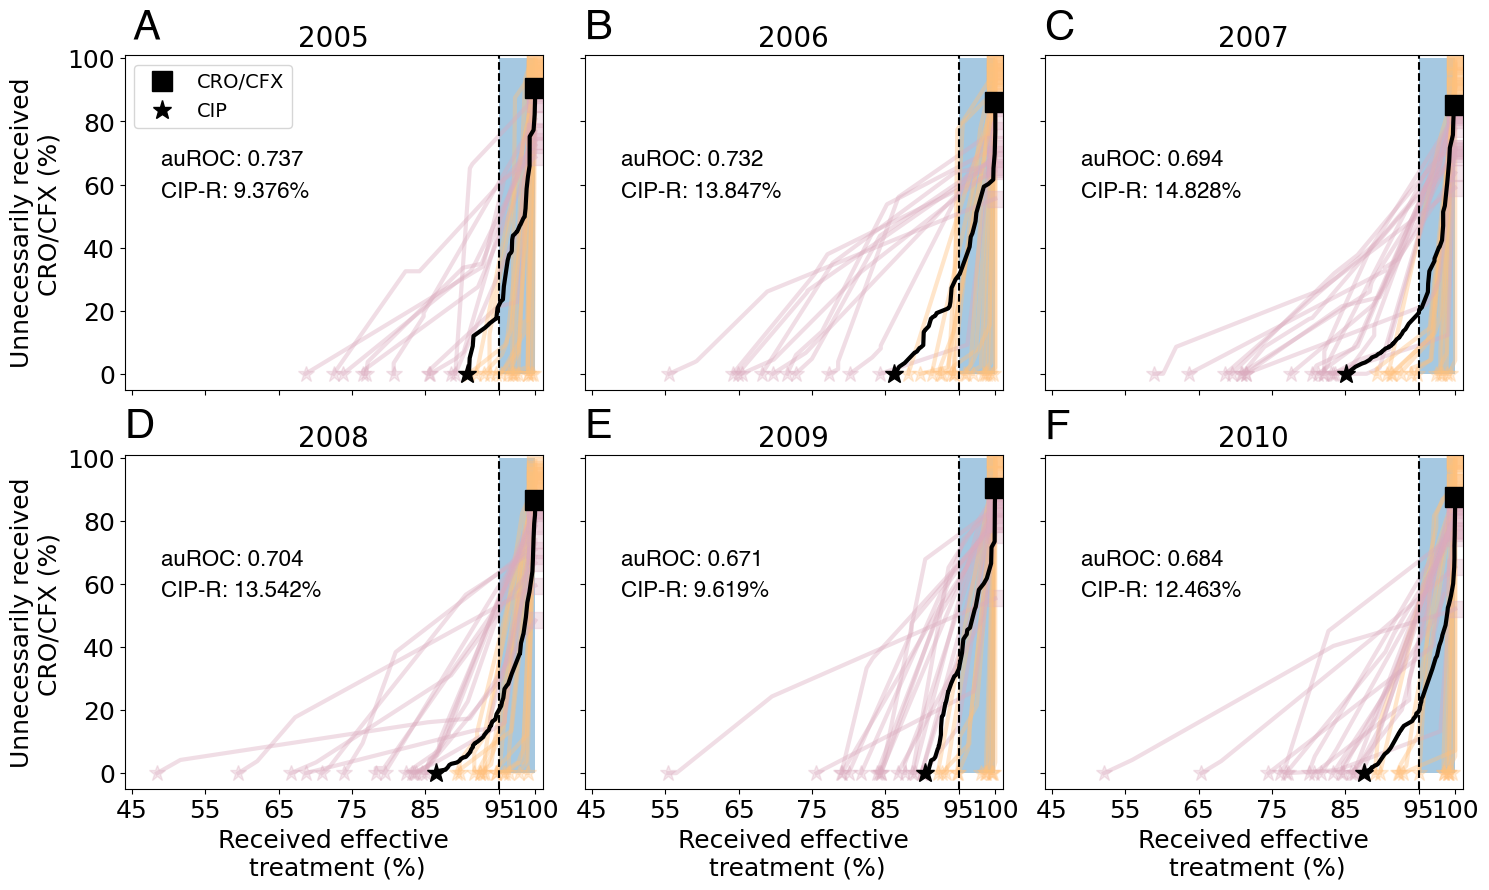

In [24]:
### Leave one out validation for MLP 
from matplotlib.patches import Polygon
oversample = RandomOverSampler(sampling_strategy = 0.5,random_state=42)
labels = ["A", "B", "C", "D", "E", "F" ]

polygon_important0 = Polygon([(95,100), (100,100), (100,0), (95,0)], alpha = 0.4)
polygon_important1 = Polygon([(95,100), (100,100), (100,0), (95,0)], alpha = 0.4)
polygon_important2 = Polygon([(95,100), (100,100), (100,0), (95,0)], alpha = 0.4)
polygon_important3 = Polygon([(95,100), (100,100), (100,0), (95,0)], alpha = 0.4)
polygon_important4 = Polygon([(95,100), (100,100), (100,0), (95,0)], alpha = 0.4)
polygon_important5 = Polygon([(95,100), (100,100), (100,0), (95,0)], alpha = 0.4)
threshold_seq = np.linspace(0,1,1001)

fig, axs = plt.subplots(2,3, figsize=(15, 9), facecolor='w', edgecolor='k', sharex = 'all', sharey = 'all')


axs[0,0].tick_params(axis='both', which='major', labelsize=18)
axs[1,0].tick_params(axis='both', which='major', labelsize=18)
axs[1,1].tick_params(axis='both', which='major', labelsize=18)
axs[1,2].tick_params(axis='both', which='major', labelsize=18)

axs[0,0].set_ylabel("Unnecessarily received\n  CRO/CFX (%)", fontsize = 18)
axs[1,0].set_ylabel("Unnecessarily received\n  CRO/CFX (%)", fontsize = 18)
axs[1,0].set_xlabel("Received effective\n treatment (%)", fontsize = 18)
axs[1,1].set_xlabel("Received effective\n treatment (%)", fontsize = 18)
axs[1,2].set_xlabel("Received effective\n treatment (%)", fontsize = 18)

axs[0,0].set_yticks(np.linspace(0,100,6), labelsize=18,**hfont)
axs[1,0].set_yticks(np.linspace(0,100,6), fontsize=18,**hfont)
axs[1,0].set_xticks([45, 55, 65, 75, 85, 95, 100], fontsize=18,**hfont)
axs[1,1].set_xticks([45, 55, 65, 75, 85, 95, 100], fontsize=18,**hfont)
axs[1,2].set_xticks([45, 55, 65, 75, 85, 95, 100], fontsize=18,**hfont)

axs[0,0].set_ylim([0-5,101])
axs[0,0].set_xlim([44, 101])
axs[0,1].set_ylim([0-5,101])
axs[0,1].set_xlim([44, 101])
axs[0,2].set_ylim([0-5,101])
axs[0,2].set_xlim([44, 101])
axs[1,0].set_ylim([0-5,101])
axs[1,0].set_xlim([44, 101])
axs[1,1].set_ylim([0-5,101])
axs[1,1].set_xlim([44, 101])
axs[1,2].set_ylim([0-5,101])
axs[1,2].set_xlim([44, 101])
test_years = [2005, 2006, 2007, 2008, 2009, 2010]
#test_years = [2005]
axs[0,0].set_ylim([0-10,101])
axs[0,0].set_xlim([45, 101])
fig.subplots_adjust(hspace = .15, wspace=.1)
axs = axs.ravel()
i = 0

for year in years: 
    years_train = np.array(range(year - 5, year))

    # first do for all clinics 

    CIP_data_training_years = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin(years_train)]
    CIP_data_testing_years = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([year])]


    test_data, train_data, X_train, y_train, X_test, y_test, cipro_R_prev  =  get_test_train_data(CIP_data_no_drop = CIP_data_no_drop, year = year, feature_names = best_features_by_year_nn[year],years_train = years_train, model_type = 0)

    model_nn = MLPClassifier(solver = 'lbfgs', activation = 'tanh', max_iter = 5000 ,hidden_layer_sizes= best_hyperparameters_by_year_nn[year]['hidden_layer_sizes'], alpha =  best_hyperparameters_by_year_nn[year]['alpha'], random_state=10, learning_rate = 'adaptive' )

    ## fit model
    model_fit_train = model_nn.fit(X_train, y_train)
    y_predict_test = model_fit_train.predict(X_test)
    y_predict_proba = model_fit_train.predict_proba(X_test)
 
    senstivitity_threshold_all, specificity_threshold_all, get_effective_threshold_all, incorrectly_get_X_threshold_all = effective_unnecessary_threshold(threshold_seq, y_predict_proba, y_test, cipro_R_prev)


    clinics = CIP_data_testing_years["CLINIC"].unique()
    for clinic in clinics: 
        train_data = CIP_data_training_years.loc[CIP_data_training_years['CLINIC'] != clinic]
          #train data - does not have clinic
        X_train = train_data[ best_features_by_year_nn[year]]
        y_train = 1 - train_data['Susceptible']
        X_train, y_train = oversample.fit_resample(X_train,y_train)

          #test data - has clinic 
        test_data = CIP_data_testing_years.loc[CIP_data_testing_years['CLINIC'] == clinic]
        X_test = test_data[ best_features_by_year_nn[year]]
        y_test = 1 - test_data['Susceptible']
        cipro_R = y_test.sum()/len(y_test)

        if cipro_R > 0: 
          if cipro_R_prev < cipro_R:
              col = '#DBABBE'
              alpha_graph = 0.4
          else:
              col = '#ffc07c'
              alpha_graph = 0.4
          try:
          # test 
              X_test, y_test = oversample.fit_resample(X_test,y_test)

              model_fit_train = model_nn.fit(X_train, y_train)
              y_predict_test = model_fit_train.predict(X_test)
              sensitivity_threshold_clinic, specificity_threshold_clinic, get_effective_threshold_clinic, incorrectly_get_X_threshold_clinic = effective_unnecessary_threshold(threshold_seq, y_predict_proba, y_test, cipro_R_prev)

              axs[i].plot(get_effective_threshold_clinic, incorrectly_get_X_threshold_clinic,color = col, linewidth = 3, alpha=alpha_graph)
              #axs[i].plot(get_effective_threshold_clinic[0:index_for_plot], incorrectly_get_X_threshold_clinic[0:index_for_plot],color = "#457b9d", linewidth = 3, alpha=0.7)

              axs[i].plot(100, (1 - cipro_R)*100, marker='s', ls='none', ms=12, color = col, alpha=0.3)
              axs[i].plot((1-cipro_R)*100, 0, marker='*', ls='none', ms=12, color = col, alpha=0.3) 
          
          except ValueError:
            #try:
              oversample = RandomOverSampler(sampling_strategy = 'minority',random_state=1)
          #train data - does not have clinic
              X_train, y_train = oversample.fit_resample(X_train,y_train)

          #test data - has clinic 

              X_test, y_test = oversample.fit_resample(X_test,y_test)
            # test 
              model_fit_train = model_nn.fit(X_train, y_train)
              y_predict_test = model_fit_train.predict(X_test)
              y_predict_proba = model_fit_train.predict_proba(X_test)
              #y_test.astype(y_predict_test.dtype)
              sensitivity_threshold_clinic, specificity_threshold_clinic, get_effective_threshold_clinic, incorrectly_get_X_threshold_clinic = effective_unnecessary_threshold(threshold_seq, y_predict_proba, y_test, cipro_R)

              axs[i].plot(get_effective_threshold_clinic, incorrectly_get_X_threshold_clinic,color = col, linewidth = 3, alpha=alpha_graph)
              axs[i].plot(100, (1 - cipro_R)*100, marker='s', ls='none', ms=12, color = col, alpha=0.3)
              axs[i].plot((1-cipro_R)*100, 0, marker='*', ls='none', ms=12, color = col, alpha=0.3) 
   


            #except ValueError:
              #print('x')
              #pass
    index_for_plot = np.max(np.where(np.array(get_effective_threshold_all)>95))

    axs[i].plot(get_effective_threshold_all, incorrectly_get_X_threshold_all,color = "black", linewidth = 3)
    #axs[i].plot(get_effective_threshold_all[0:index_for_plot], incorrectly_get_X_threshold_all[0:index_for_plot],color = "#457b9d", linewidth = 3)
    axs[i].plot(100, (1 - cipro_R_prev)*100, marker='s', ls='none', ms=14, color = "black", label = "CRO/CFX")
    axs[i].plot((1-cipro_R_prev)*100, 0, marker='*', ls='none', ms=14, color = "black", label = "CIP")
    axs[i].text(axs[i].get_xlim()[0] , axs[i].get_ylim()[1] + 5, labels[i], fontsize = 30, **hfont)
    axs[i].axvline(x = 95, color = 'black', linestyle="--")
    axs[i].set_ylim([0-5,101])
    axs[i].set_xlim([44, 101])
    axs[i].text(axs[i].get_xlim()[0] + 5 , axs[i].get_ylim()[1] - 35, f'auROC: {round(ROC_by_year_nn[year], 3)}', fontsize = 16, **hfont)
    axs[i].text(axs[i].get_xlim()[0] + 5 , axs[i].get_ylim()[1] - 45, f'CIP-R: {round(cipro_R_prev*100, 3)}%', fontsize = 16, **hfont)
    #for index in indices:
    #    axs[i].plot(get_effective_threshold_all[index], incorrectly_get_X_threshold_all[index], marker='.', ls='none', ms=11, color = "#b56576")
    axs[i].set_title(year,fontsize=20)

    i += 1   #
axs[0].legend(prop={'size':14})

axs[0].add_patch(polygon_important0)
axs[1].add_patch(polygon_important1)
axs[2].add_patch(polygon_important2)
axs[3].add_patch(polygon_important3)
axs[4].add_patch(polygon_important4)
axs[5].add_patch(polygon_important5)
plt.tight_layout()

plt.savefig("Graphs/LOOCV_effective_unnecessary_all_workflow_paper_neural_network_2005_2010_coloured.png", dpi = 300)

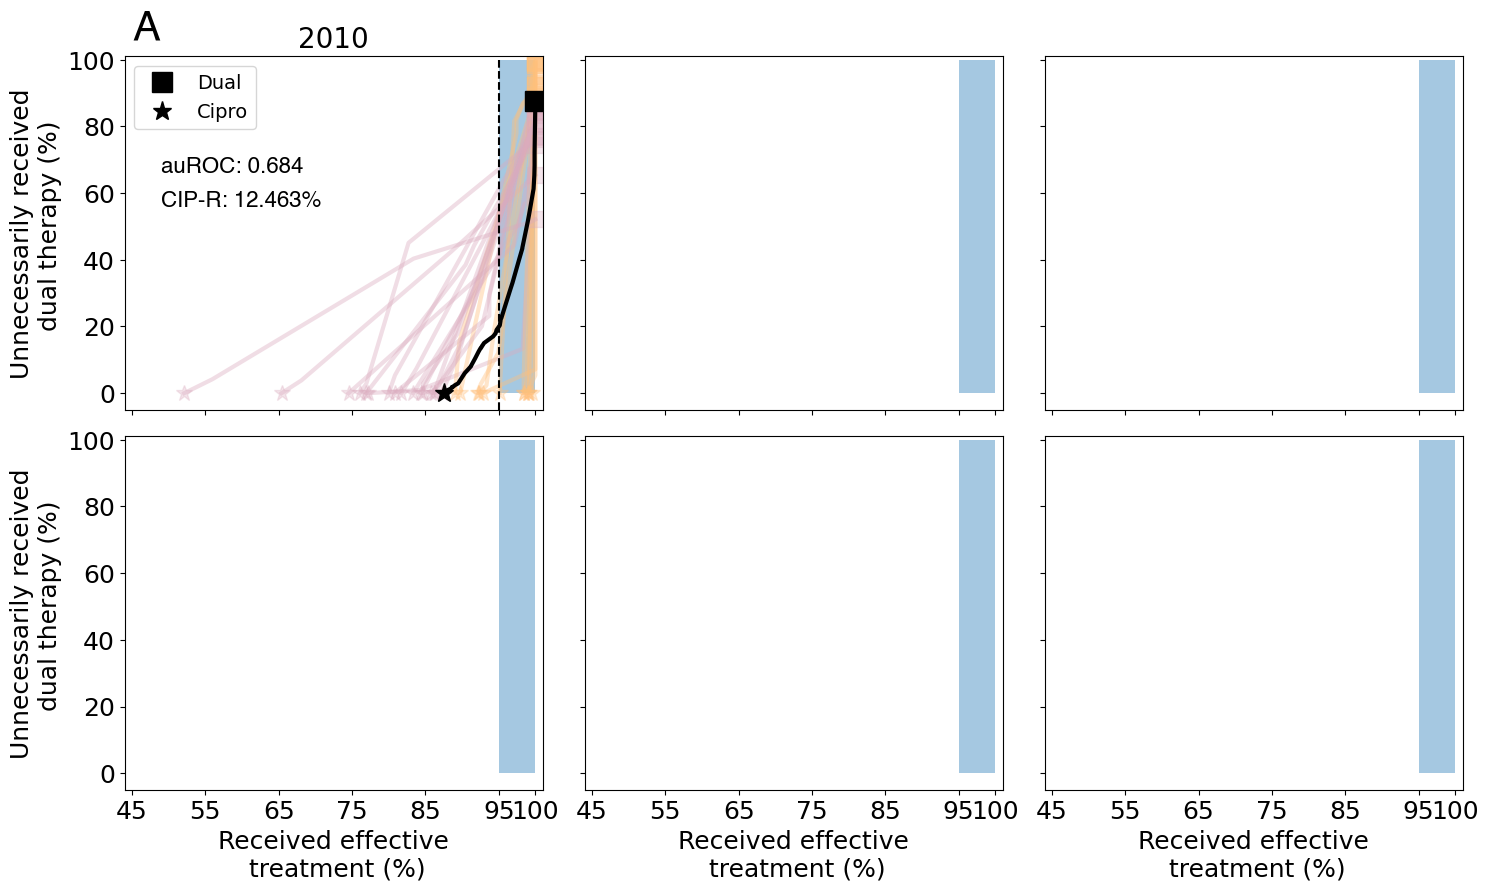

In [148]:
### SEE REDUCTION IN UNNECESSARY 
from matplotlib.patches import Polygon
oversample = RandomOverSampler(sampling_strategy = 0.5,random_state=42)
labels = ["A", "B", "C", "D", "E", "F" ]

polygon_important0 = Polygon([(95,100), (100,100), (100,0), (95,0)], alpha = 0.4)
polygon_important1 = Polygon([(95,100), (100,100), (100,0), (95,0)], alpha = 0.4)
polygon_important2 = Polygon([(95,100), (100,100), (100,0), (95,0)], alpha = 0.4)
polygon_important3 = Polygon([(95,100), (100,100), (100,0), (95,0)], alpha = 0.4)
polygon_important4 = Polygon([(95,100), (100,100), (100,0), (95,0)], alpha = 0.4)
polygon_important5 = Polygon([(95,100), (100,100), (100,0), (95,0)], alpha = 0.4)
threshold_seq = np.linspace(0,1,1001)

fig, axs = plt.subplots(2,3, figsize=(15, 9), facecolor='w', edgecolor='k', sharex = 'all', sharey = 'all')


axs[0,0].tick_params(axis='both', which='major', labelsize=18)
axs[1,0].tick_params(axis='both', which='major', labelsize=18)
axs[1,1].tick_params(axis='both', which='major', labelsize=18)
axs[1,2].tick_params(axis='both', which='major', labelsize=18)

axs[0,0].set_ylabel("Unnecessarily received\n  CRO/CFX (%)", fontsize = 18)
axs[1,0].set_ylabel("Unnecessarily received\n  CRO/CFX (%)", fontsize = 18)
axs[1,0].set_xlabel("Received effective\n treatment (%)", fontsize = 18)
axs[1,1].set_xlabel("Received effective\n treatment (%)", fontsize = 18)
axs[1,2].set_xlabel("Received effective\n treatment (%)", fontsize = 18)

axs[0,0].set_yticks(np.linspace(0,100,6), labelsize=18,**hfont)
axs[1,0].set_yticks(np.linspace(0,100,6), fontsize=18,**hfont)
axs[1,0].set_xticks([45, 55, 65, 75, 85, 95, 100], fontsize=18,**hfont)
axs[1,1].set_xticks([45, 55, 65, 75, 85, 95, 100], fontsize=18,**hfont)
axs[1,2].set_xticks([45, 55, 65, 75, 85, 95, 100], fontsize=18,**hfont)

axs[0,0].set_ylim([0-5,101])
axs[0,0].set_xlim([44, 101])
axs[0,1].set_ylim([0-5,101])
axs[0,1].set_xlim([44, 101])
axs[0,2].set_ylim([0-5,101])
axs[0,2].set_xlim([44, 101])
axs[1,0].set_ylim([0-5,101])
axs[1,0].set_xlim([44, 101])
axs[1,1].set_ylim([0-5,101])
axs[1,1].set_xlim([44, 101])
axs[1,2].set_ylim([0-5,101])
axs[1,2].set_xlim([44, 101])
#test_years = [2005, 2006, 2007, 2008, 2009, 2010]
years = [2010]
axs[0,0].set_ylim([0-10,101])
axs[0,0].set_xlim([45, 101])
fig.subplots_adjust(hspace = .15, wspace=.1)
axs = axs.ravel()
i = 0
differences_from_dual_2010 = []
for year in years: 
    years_train = np.array(range(year - 5, year))

    # first do for all clinics 

    CIP_data_training_years = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin(years_train)]
    CIP_data_testing_years = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([year])]


    test_data, train_data, X_train, y_train, X_test, y_test, cipro_R_prev  =  get_test_train_data(CIP_data_no_drop = CIP_data_no_drop, year = year, feature_names = best_features_by_year_nn[year],years_train = years_train, model_type = 0)

    model_nn = MLPClassifier(solver = 'lbfgs', activation = 'tanh', max_iter = 5000 ,hidden_layer_sizes= best_hyperparameters_by_year_nn[year]['hidden_layer_sizes'], alpha =  best_hyperparameters_by_year_nn[year]['alpha'], random_state=10, learning_rate = 'adaptive' )

    ## fit model
    model_fit_train = model_nn.fit(X_train, y_train)
    y_predict_test = model_fit_train.predict(X_test)
    y_predict_proba = model_fit_train.predict_proba(X_test)
 
    senstivitity_threshold_all, specificity_threshold_all, get_effective_threshold_all, incorrectly_get_X_threshold_all = effective_unnecessary_threshold(threshold_seq, y_predict_proba, y_test, cipro_R_prev)


    clinics = CIP_data_testing_years["CLINIC"].unique()
    for clinic in clinics: 
        train_data = CIP_data_training_years.loc[CIP_data_training_years['CLINIC'] != clinic]
          #train data - does not have clinic
        X_train = train_data[ best_features_by_year_nn[year]]
        y_train = 1 - train_data['Susceptible']
        X_train, y_train = oversample.fit_resample(X_train,y_train)

          #test data - has clinic 
        test_data = CIP_data_testing_years.loc[CIP_data_testing_years['CLINIC'] == clinic]
        X_test = test_data[ best_features_by_year_nn[year]]
        y_test = 1 - test_data['Susceptible']
        cipro_R = y_test.sum()/len(y_test)

        if cipro_R > 0: 
          if cipro_R_prev < cipro_R:
              col = '#DBABBE'
              alpha_graph = 0.4
          else:
              col = '#ffc07c'
              alpha_graph = 0.4
          try:
          # test 
              X_test, y_test = oversample.fit_resample(X_test,y_test)

              model_fit_train = model_nn.fit(X_train, y_train)
              y_predict_test = model_fit_train.predict(X_test)
              sensitivity_threshold_clinic, specificity_threshold_clinic, get_effective_threshold_clinic, incorrectly_get_X_threshold_clinic = effective_unnecessary_threshold(threshold_seq, y_predict_proba, y_test, cipro_R_prev)
              differences_from_dual_2010.append(incorrectly_get_X_threshold[0] - incorrectly_get_X_threshold[get_effective_threshold.index(min([x for x in get_effective_threshold if x >= 95]))] )

              axs[i].plot(get_effective_threshold_clinic, incorrectly_get_X_threshold_clinic,color = col, linewidth = 3, alpha=alpha_graph)
              #axs[i].plot(get_effective_threshold_clinic[0:index_for_plot], incorrectly_get_X_threshold_clinic[0:index_for_plot],color = "#457b9d", linewidth = 3, alpha=0.7)
              
              axs[i].plot(100, (1 - cipro_R)*100, marker='s', ls='none', ms=12, color = col, alpha=0.3)
              axs[i].plot((1-cipro_R)*100, 0, marker='*', ls='none', ms=12, color = col, alpha=0.3) 
          
          except ValueError:
            #try:
              oversample = RandomOverSampler(sampling_strategy = 'minority',random_state=1)
          #train data - does not have clinic
              X_train, y_train = oversample.fit_resample(X_train,y_train)

          #test data - has clinic 

              X_test, y_test = oversample.fit_resample(X_test,y_test)
            # test 
              model_fit_train = model_nn.fit(X_train, y_train)
              y_predict_test = model_fit_train.predict(X_test)
              y_predict_proba = model_fit_train.predict_proba(X_test)
              #y_test.astype(y_predict_test.dtype)
              sensitivity_threshold_clinic, specificity_threshold_clinic, get_effective_threshold_clinic, incorrectly_get_X_threshold_clinic = effective_unnecessary_threshold(threshold_seq, y_predict_proba, y_test, cipro_R)
              differences_from_dual_2010.append(incorrectly_get_X_threshold[0] - incorrectly_get_X_threshold[get_effective_threshold.index(min([x for x in get_effective_threshold if x >= 95]))] )
              axs[i].plot(get_effective_threshold_clinic, incorrectly_get_X_threshold_clinic,color = col, linewidth = 3, alpha=alpha_graph)
              axs[i].plot(100, (1 - cipro_R)*100, marker='s', ls='none', ms=12, color = col, alpha=0.3)
              axs[i].plot((1-cipro_R)*100, 0, marker='*', ls='none', ms=12, color = col, alpha=0.3) 
   


            #except ValueError:
              #print('x')
              #pass
    index_for_plot = np.max(np.where(np.array(get_effective_threshold_all)>95))
    
    axs[i].plot(get_effective_threshold_all, incorrectly_get_X_threshold_all,color = "black", linewidth = 3)
    #axs[i].plot(get_effective_threshold_all[0:index_for_plot], incorrectly_get_X_threshold_all[0:index_for_plot],color = "#457b9d", linewidth = 3)
    axs[i].plot(100, (1 - cipro_R_prev)*100, marker='s', ls='none', ms=14, color = "black", label = "CRO/CFX")
    axs[i].plot((1-cipro_R_prev)*100, 0, marker='*', ls='none', ms=14, color = "black", label = "CIP")
    axs[i].text(axs[i].get_xlim()[0] , axs[i].get_ylim()[1] + 5, labels[i], fontsize = 30, **hfont)
    axs[i].axvline(x = 95, color = 'black', linestyle="--")
    axs[i].set_ylim([0-5,101])
    axs[i].set_xlim([44, 101])
    axs[i].text(axs[i].get_xlim()[0] + 5 , axs[i].get_ylim()[1] - 35, f'auROC: {round(ROC_by_year_nn[year], 3)}', fontsize = 16, **hfont)
    axs[i].text(axs[i].get_xlim()[0] + 5 , axs[i].get_ylim()[1] - 45, f'CIP-R: {round(cipro_R_prev*100, 3)}%', fontsize = 16, **hfont)
    #for index in indices:
    #    axs[i].plot(get_effective_threshold_all[index], incorrectly_get_X_threshold_all[index], marker='.', ls='none', ms=11, color = "#b56576")
    axs[i].set_title(year,fontsize=20)

    i += 1   #
axs[0].legend(prop={'size':14})

axs[0].add_patch(polygon_important0)
axs[1].add_patch(polygon_important1)
axs[2].add_patch(polygon_important2)
axs[3].add_patch(polygon_important3)
axs[4].add_patch(polygon_important4)
axs[5].add_patch(polygon_important5)
plt.tight_layout()

#plt.savefig("Graphs/LOOCV_effective_unnecessary_all_workflow_paper_neural_network_2005_2010_coloured.png", dpi = 300)

In [149]:
differences_from_dual_2010

[66.95377043417122,
 66.95377043417122,
 66.95377043417122,
 66.95377043417122,
 66.95377043417122,
 66.95377043417122,
 66.95377043417122,
 66.95377043417122,
 66.95377043417122,
 66.95377043417122,
 66.95377043417122,
 66.95377043417122,
 66.95377043417122,
 66.95377043417122,
 66.95377043417122,
 66.95377043417122,
 66.95377043417122,
 66.95377043417122,
 66.95377043417122,
 66.95377043417122,
 66.95377043417122,
 66.95377043417122,
 66.95377043417122,
 66.95377043417122,
 66.95377043417122,
 66.95377043417122,
 66.95377043417122,
 66.95377043417122]

In [83]:
### change for 2007 - neural network 
year = 2010
years_train = np.array(range(year - 5, year))
threshold_seq = np.linspace(0,1,1001)

    # first do for all clinics 



test_data, train_data, X_train, y_train, X_test, y_test, cipro_R_prev  =  get_test_train_data(CIP_data_no_drop = CIP_data_no_drop, year = year, feature_names = best_features_by_year_lr[year],years_train = years_train, model_type = 0)

model_nn = MLPClassifier(solver = 'lbfgs', activation = 'tanh', max_iter = 3000 ,hidden_layer_sizes= best_hyperparameters_by_year_nn[year]['hidden_layer_sizes'], alpha =  best_hyperparameters_by_year_nn[year]['alpha'], random_state=10, learning_rate = 'adaptive' )
    
    ## fit model
model_fit_train = model_nn.fit(X_train, y_train)
y_predict_test = model_fit_train.predict(X_test)
y_predict_proba = model_fit_train.predict_proba(X_test)
 
senstivitity_threshold_all, specificity_threshold_all, get_effective_threshold_all, incorrectly_get_X_threshold_all = effective_unnecessary_threshold(threshold_seq, y_predict_proba, y_test, cipro_R_prev)

print(get_effective_threshold_all[0])
print(incorrectly_get_X_threshold_all[0])

print(get_effective_threshold_all[200])
print(incorrectly_get_X_threshold_all[200])


print((get_effective_threshold_all[0] - get_effective_threshold_all[200])/(get_effective_threshold_all[0]))
print((incorrectly_get_X_threshold_all[0] - incorrectly_get_X_threshold_all[200])/(incorrectly_get_X_threshold_all[0]))

100.0
87.5373527860784
99.72972572307158
60.889435753207955
0.0027027427692841856
0.30441767068273085


In [40]:

############# why does it decrease over time??? 
space = dict()
space['activation'] = ['tanh', 'relu']
space['alpha'] = np.logspace(-1, 1, 10)
#space['learning_rate'] = ['constant','adaptive']
space['hidden_layer_sizes'] = [(12), (13), (14)]

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=10)
model_nn = MLPClassifier(solver = 'lbfgs', activation = 'tanh', max_iter = 3000 ,hidden_layer_sizes= 12, alpha =  1.29, random_state=10, learning_rate = 'adaptive' )

train_data = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([2004, 2005, 2006, 2007, 2008])]
X_train = train_data[['MSM','MSMW', 'MSW', 'Oth/Unk/Missing','Northeast', 'Southeast', 'Southwest', 'West', 'Midwest','PREV_REGION', 'PREV_CLINIC', 'DELTA_REGION']]
y_train = 1 - train_data['Susceptible']

oversample = RandomOverSampler(sampling_strategy = 0.5,random_state=42)
X, y = oversample.fit_resample(X_train,y_train)
model_fit = model_nn.fit(X_train,y_train)

search = RandomizedSearchCV(model_nn, space, scoring='roc_auc', n_jobs=-1, cv=cv, random_state=1)
result = search.fit(X_train,y_train)
# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)
#2010 {'hidden_layer_sizes': 14, 'alpha': 0.1, 'activation': 'tanh'} different to what came from loop...

Best Score: 0.824477493687889
Best Hyperparameters: {'hidden_layer_sizes': 14, 'alpha': 0.1, 'activation': 'tanh'}


In [102]:
model_nn = MLPClassifier(solver = 'lbfgs', activation = 'tanh', max_iter = 3000 ,hidden_layer_sizes= 14, alpha =  0.1, random_state=10, learning_rate = 'adaptive' )

train_data = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([2005, 2006, 2007, 2008, 2009])]
X_train = train_data[best_features_by_year_nn[2010]]
y_train = 1 - train_data['Susceptible']
X_train, y_train = oversample.fit_resample(X_train,y_train)

test_data = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([2010])]

X_test = test_data[best_features_by_year_nn[2010]]
y_test = 1 - test_data['Susceptible']
X_test, y_test = oversample.fit_resample(X_test,y_test)
model_fit_train = model_nn.fit(X_train, y_train)

  #2. Test model on test data to get test specificity and sensitivity 
  
y_predict = model_fit_train.predict(X_test)
y_predict_proba = model_fit_train.predict_proba(X_test)

ROC_AUC_nn_2010= metrics.roc_auc_score(y_test, y_predict)

print(ROC_AUC_nn_2010)


KeyboardInterrupt: 

In [33]:
### How to pick out best features by model 
years = [2005, 2006, 2007, 2008, 2009, 2010]

### neural network
PI_dataframe_nn = pd.DataFrame({
'MSM':0,
'MSMW':0,
'MSW':0,
'Other':0,
'Midwest':0,
'Northeast':0,
'West':0,
'Southeast':0,
'Southwest':0,
'Region':0,
'Clinic':0, 
'Delta_R':0,
'Delta_C':0
},index=[0])
for year in years:
    for feature in best_features_by_year_nn[year]:
        if feature == 'PREV_CLINIC':
                PI_dataframe_nn["Clinic"] += 1
        elif feature == "PREV_REGION":
                PI_dataframe_nn["Region"] += 1
        elif feature == "MSM":
                PI_dataframe_nn["MSM"] += 1
        elif feature == "MSMW":
                PI_dataframe_nn["MSMW"] += 1
        elif feature == "MSW":
                PI_dataframe_nn["MSW"] += 1
        elif feature == "Oth/Unk/Missing":
                PI_dataframe_nn["Other"] += 1  
        elif feature == "Northeast":
                PI_dataframe_nn["Northeast"] += 1 
        elif feature == "Southeast":
                PI_dataframe_nn["Southeast"] += 1    
        elif feature == "Southewest":
                PI_dataframe_nn["Southwest"] += 1   
        elif feature == "Midwest":
                PI_dataframe_nn["Midwest"] += 1    
        elif feature == "West":
                PI_dataframe_nn["West"] += 1   
        elif feature == "DELTA_REGION":
                PI_dataframe_nn["Delta_R"] += 1
        elif feature == "DELTA_CLINIC":
                PI_dataframe_nn["Delta_C"] += 1
PI_dataframe_nn = pd.melt(PI_dataframe_nn, value_vars=PI_dataframe_nn.columns)

## logistic regression
PI_dataframe_lr = pd.DataFrame({
'MSM':0,
'MSMW':0,
'MSW':0,
'Other':0,
'Midwest':0,
'Northeast':0,
'West':0,
'Southeast':0,
'Southwest':0,
'Region':0,
'Clinic':0, 
'Delta_R':0,
'Delta_C':0},index=[0])
for year in years:
    for feature in best_features_by_year_lr[year]:
        if feature == 'PREV_CLINIC':
                PI_dataframe_lr["Clinic"] += 1
        elif feature == "PREV_REGION":
                PI_dataframe_lr["Region"] += 1
        elif feature == "MSM":
                PI_dataframe_lr["MSM"] += 1
        elif feature == "MSMW":
                PI_dataframe_lr["MSMW"] += 1
        elif feature == "MSW":
                PI_dataframe_lr["MSW"] += 1
        elif feature == "Oth/Unk/Missing":
                PI_dataframe_lr["Other"] += 1  
        elif feature == "Northeast":
                PI_dataframe_lr["Northeast"] += 1 
        elif feature == "Southeast":
                PI_dataframe_lr["Southeast"] += 1    
        elif feature == "Southewest":
                PI_dataframe_lr["Southwest"] += 1   
        elif feature == "Midwest":
                PI_dataframe_lr["Midwest"] += 1    
        elif feature == "West":
                PI_dataframe_lr["West"] += 1   
        elif feature == "DELTA_REGION":
                PI_dataframe_lr["Delta_R"] += 1
        elif feature == "DELTA_CLINIC":
                PI_dataframe_lr["Delta_C"] += 1
PI_dataframe_lr = pd.melt(PI_dataframe_lr, value_vars=PI_dataframe_lr.columns)

## random forest 
PI_dataframe_rf = pd.DataFrame({
'MSM':0,
'MSMW':0,
'MSW':0,
'Other':0,
'Midwest':0,
'Northeast':0,
'West':0,
'Southeast':0,
'Southwest':0,
'Region':0,
'Clinic':0, 
'Delta_R':0,
'Delta_C':0},index=[0])
for year in years:
    for feature in best_features_by_year_rf[year]:
        if feature == 'PREV_CLINIC':
                PI_dataframe_rf["Clinic"] += 1
        elif feature == "PREV_REGION":
                PI_dataframe_rf["Region"] += 1
        elif feature == "MSM":
                PI_dataframe_rf["MSM"] += 1
        elif feature == "MSMW":
                PI_dataframe_rf["MSMW"] += 1
        elif feature == "MSW":
                PI_dataframe_rf["MSW"] += 1
        elif feature == "Oth/Unk/Missing":
                PI_dataframe_rf["Other"] += 1  
        elif feature == "Northeast":
                PI_dataframe_rf["Northeast"] += 1 
        elif feature == "Southeast":
                PI_dataframe_rf["Southeast"] += 1    
        elif feature == "Southewest":
                PI_dataframe_rf["Southwest"] += 1   
        elif feature == "Midwest":
                PI_dataframe_rf["Midwest"] += 1    
        elif feature == "West":
                PI_dataframe_rf["West"] += 1   
        elif feature == "DELTA_REGION":
                PI_dataframe_rf["Delta_R"] += 1
        elif feature == "DELTA_CLINIC":
                PI_dataframe_rf["Delta_C"] += 1
PI_dataframe_rf = pd.melt(PI_dataframe_rf, value_vars=PI_dataframe_rf.columns)


/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_88221/1102679014.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_yticklabels( PI_dataframe_nn["variable"],fontsize = 18)


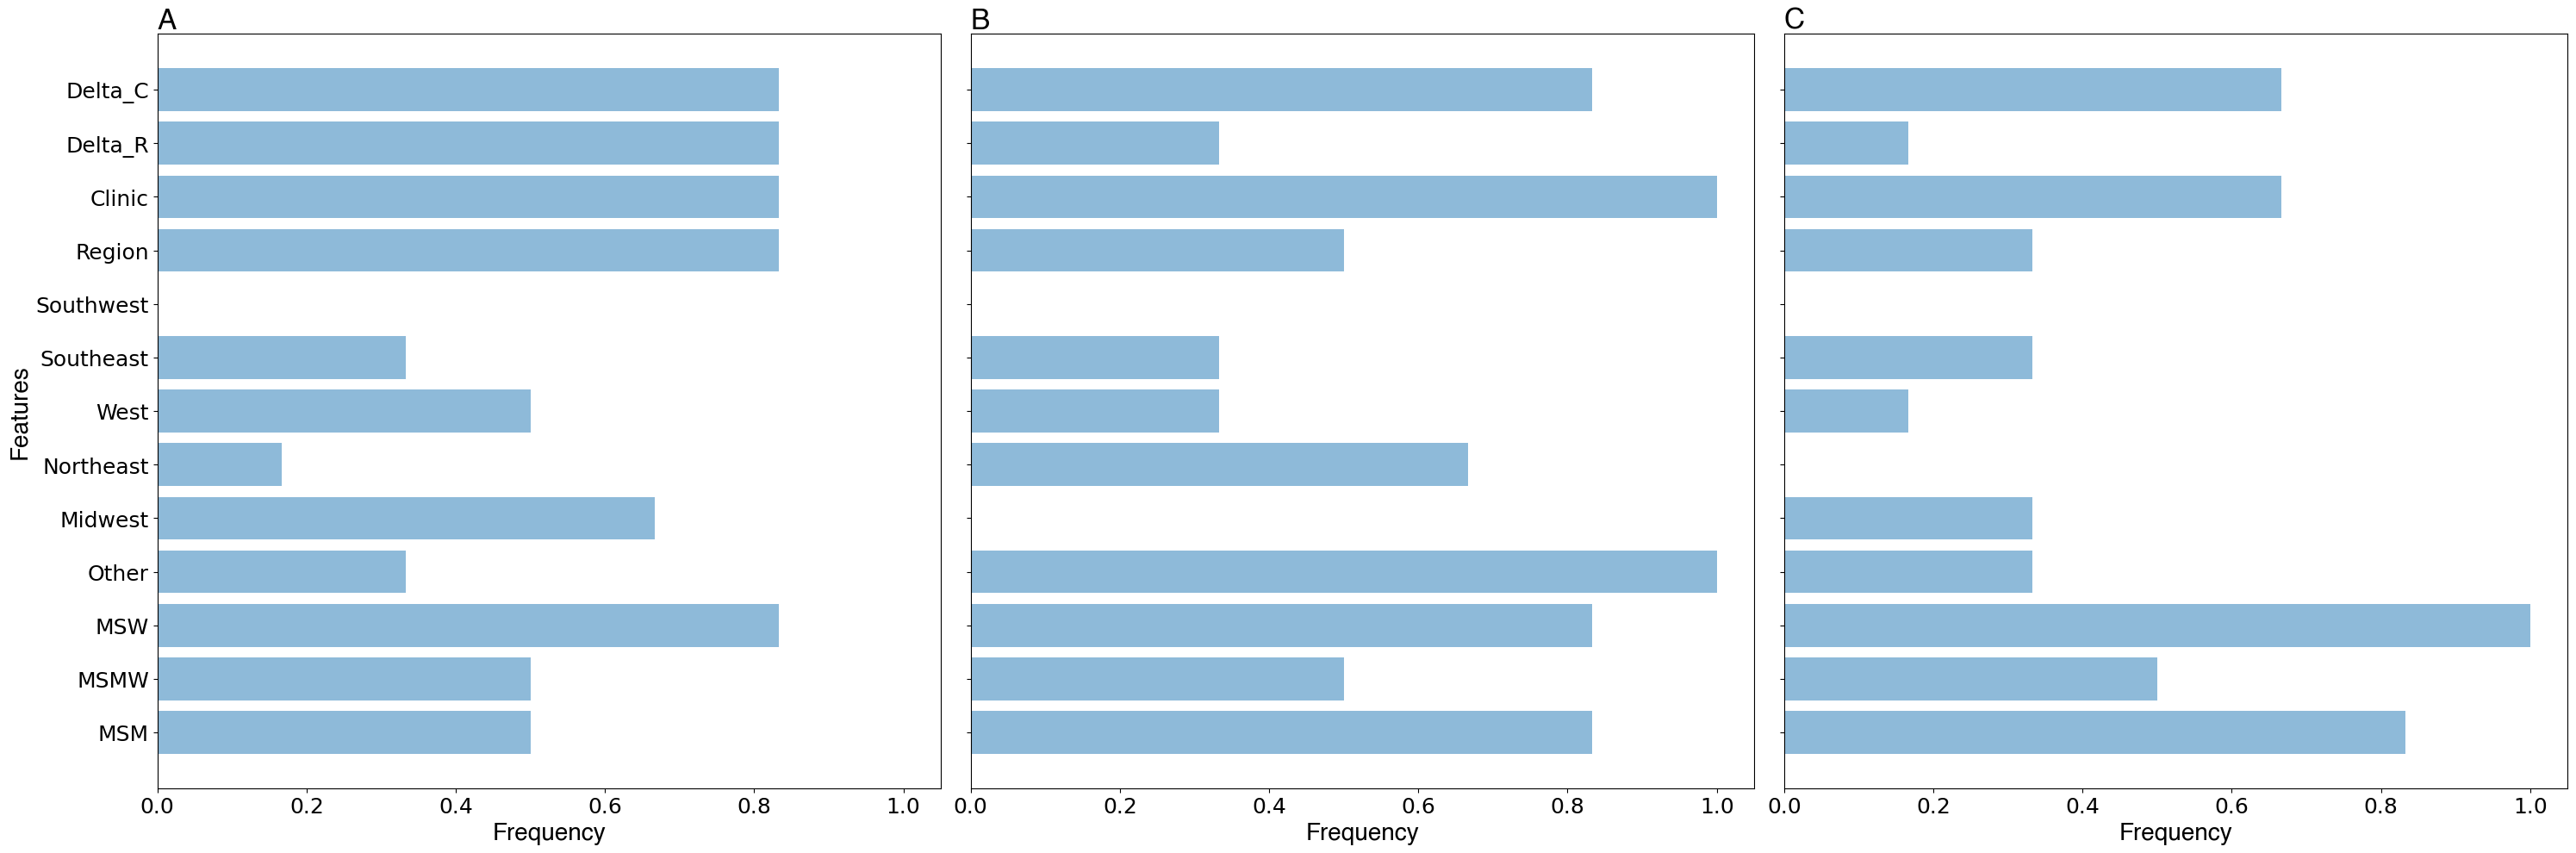

In [35]:
fig, axs = plt.subplots(1,3, figsize=(30, 10), facecolor='w', edgecolor='k', sharex = 'all', sharey = 'all')

axs[0].barh(y = PI_dataframe_nn["variable"], width =PI_dataframe_nn["value"]/6,alpha = 0.5)#c8b6ff") # xmin = min(feature_names_by_importance), xmax = max(feature_names_by_importance))
axs[1].barh(y = PI_dataframe_lr["variable"], width =PI_dataframe_lr["value"]/6,alpha = 0.5)#c8b6ff") # xmin = min(feature_names_by_importance), xmax = max(feature_names_by_importance))
axs[2].barh(y = PI_dataframe_rf["variable"], width =PI_dataframe_rf["value"]/6,alpha = 0.5)#c8b6ff") # xmin = min(feature_names_by_importance), xmax = max(feature_names_by_importance))
axs[0].set_xlabel('Frequency', fontsize = 20, **hfont)
axs[1].set_xlabel('Frequency', fontsize = 20, **hfont)
axs[2].set_xlabel('Frequency', fontsize = 20, **hfont)
axs[0].set_ylabel('Features', fontsize = 20, **hfont)

axs[0].set_yticklabels( PI_dataframe_nn["variable"],fontsize = 18)
axs[0].tick_params(axis='x', labelsize=18)
axs[1].tick_params(axis='x', labelsize=18)
axs[2].tick_params(axis='x', labelsize=18)

axs[0].text(axs[0].get_xlim()[0] , axs[0].get_ylim()[1] + .1, "A", fontsize = 24, **hfont)
axs[1].text(axs[0].get_xlim()[0] , axs[0].get_ylim()[1] + .1, "B", fontsize = 24, **hfont)
axs[2].text(axs[0].get_xlim()[0] , axs[0].get_ylim()[1] + .1, "C", fontsize = 24, **hfont)
plt.tight_layout()

#plt.savefig('Graphs/Features_by_frequency_all_models.png', dpi = 300)


In [122]:
oversample = RandomOverSampler(sampling_strategy="minority", random_state=10)


def get_test_train_data(CIP_data_no_drop, year, feature_names, years_train, model_type):

    train_data = CIP_data_no_drop.loc[CIP_data_no_drop["YEAR"].isin(years_train)]
    X_train = train_data[
        feature_names
    ]  # need to consider all columns BEFORE feature engineering
    y_train = 1 - train_data["Susceptible"]
    # test
    test_data = CIP_data_no_drop.loc[CIP_data_no_drop["YEAR"].isin([year])]
    X_test = test_data[feature_names]
    y_test = 1 - test_data["Susceptible"]
    cipro_R_prev = y_test.sum() / len(y_test)
    if (model_type == 1) | (model_type == 2):
        X_train, y_train = oversample.fit_resample(X_train, y_train)
        # X_test, y_test = oversample.fit_resample(X_test, y_test)
        print("Oversample")
    return (test_data, train_data, X_train, y_train, X_test, y_test, cipro_R_prev)


Oversample
Oversample
Oversample
Oversample
Oversample
Oversample
Oversample
Oversample
Oversample
Oversample
Oversample
Oversample


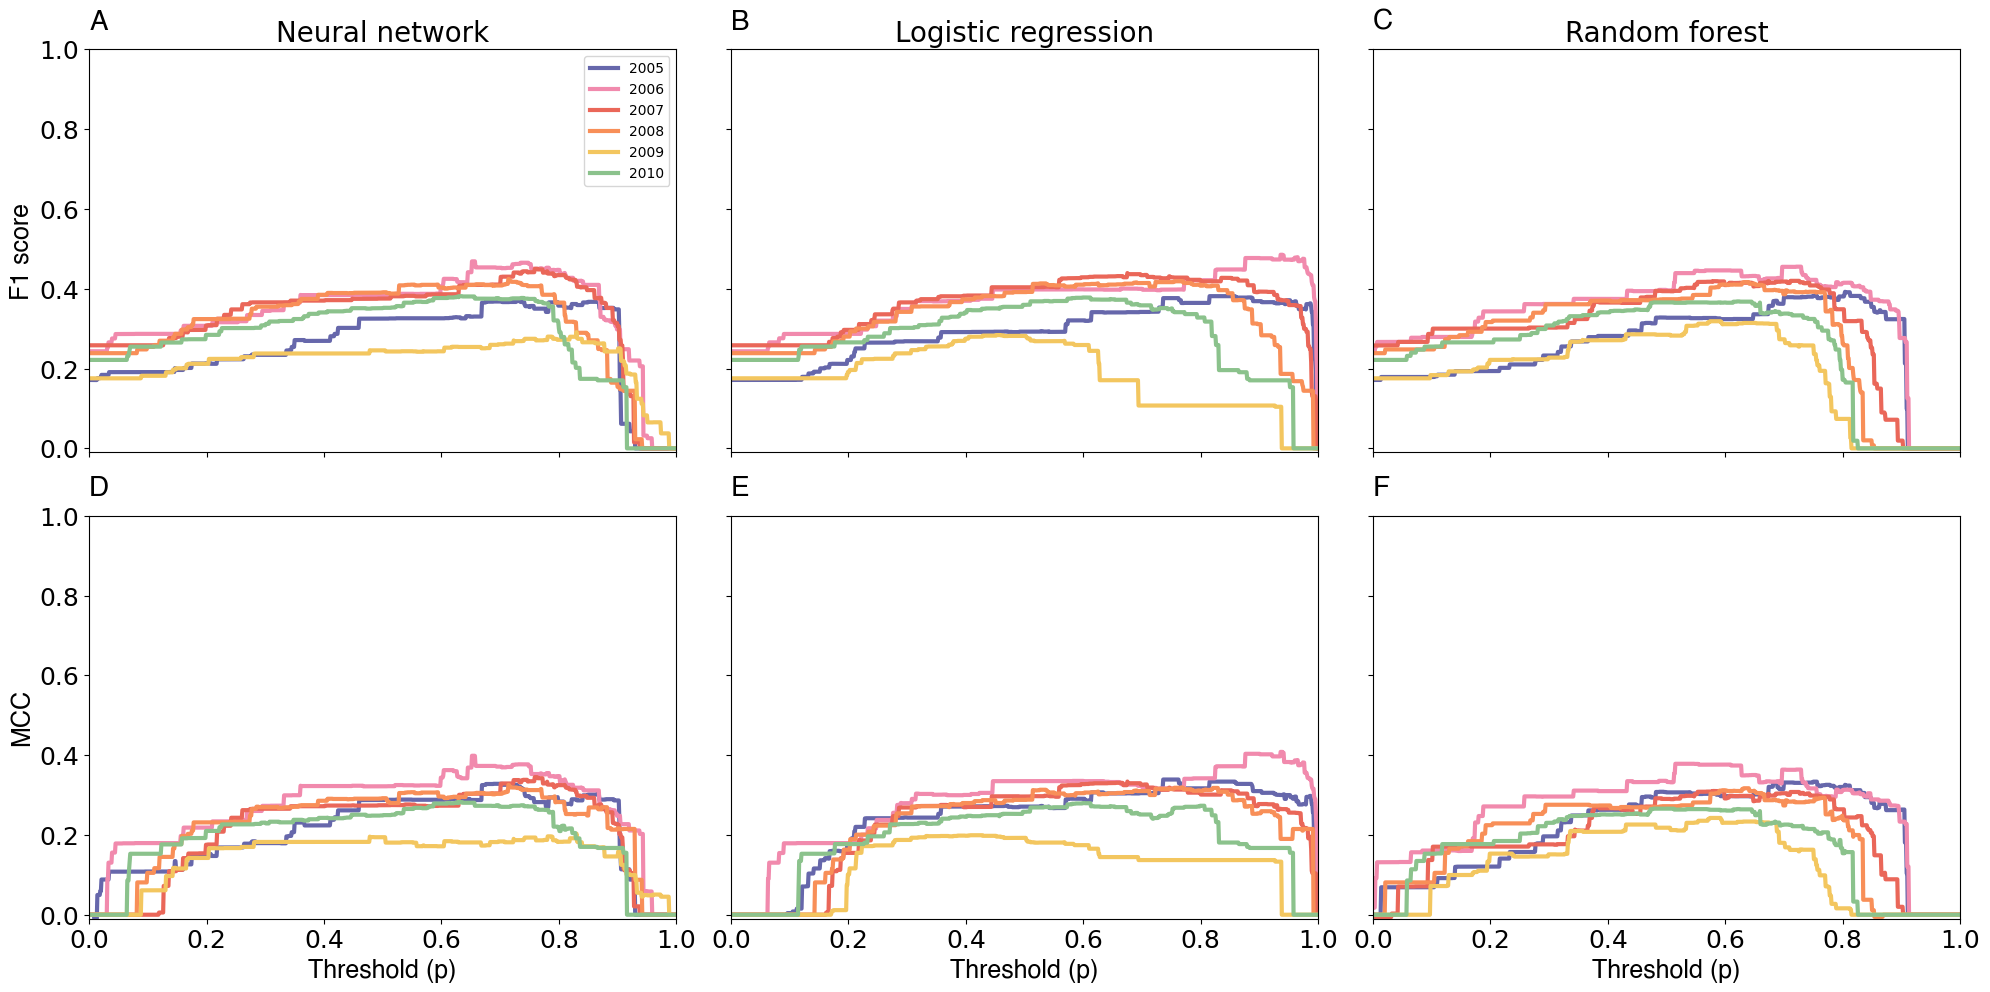

In [129]:
###### Performance criteria by year and model 
def f1_mcc_score_threshold(threshold_seq, y_predict_proba, y_test):

    f1_score_seq = []
    mcc_score_seq = []
    for threshold in threshold_seq:

        y_predict = np.where(y_predict_proba[:, 1] > threshold, 1, 0)

        f1_score_seq.append(f1_score(y_test, y_predict))
        mcc_score_seq.append(matthews_corrcoef(y_test, y_predict))
    return(f1_score_seq, mcc_score_seq)

## set up for figure 
threshold_seq = np.linspace(0,1,1001)

### calculate scores 
fig, axs = plt.subplots(2,3, figsize=(20, 10), facecolor='w', edgecolor='k', sharex = 'all', sharey = 'all')
colors = ["#6667ab", "#f18aad", "#ea6759", "#f88f58", "#f3c65f", "#8bc28c"]
labels = ["A", "B", "C", "D", "E", "F" ]

test_years = [2005, 2006, 2007, 2008, 2009, 2010]

axs[0,0].set_ylabel('F1 score', fontsize = 18, **hfont)
axs[1,0].set_ylabel('MCC', fontsize = 18, **hfont)
axs[1,0].set_xlabel("Threshold (p)", fontsize = 18, **hfont)
axs[1,1].set_xlabel("Threshold (p)", fontsize = 18, **hfont)
axs[1,2].set_xlabel("Threshold (p)", fontsize = 18, **hfont)

axs[0,0].set_yticks(np.linspace(0,1,6), fontsize=18,**hfont)
axs[1,0].set_yticks(np.linspace(0,1,6), fontsize=18,**hfont)
axs[1,0].set_xticks(np.linspace(0,1,6), fontsize=18,**hfont)
axs[1,1].set_xticks(np.linspace(0,1,6), fontsize=18,**hfont)
axs[1,2].set_xticks(np.linspace(0,1,6), fontsize=18,**hfont)

axs[0,0].tick_params(axis='both', labelsize=18)
axs[0,1].tick_params(axis='both', labelsize=18)
axs[0,2].tick_params(axis='both', labelsize=18)
axs[1,0].tick_params(axis='both', labelsize=18)
axs[1,1].tick_params(axis='both', labelsize=18)
axs[1,2].tick_params(axis='both', labelsize=18)

axs[0,0].set_ylim([0-.010,1])
axs[0,0].set_xlim([0, 1])

axs = axs.ravel()

for i in range(3):
    x = 0

    if i == 0:
        for year in test_years: 
            years_train = np.array(range(year - 5, year))

            # first do for all clinics 

            model_nn = MLPClassifier(solver = best_hyperparameters_by_year_nn[year]['solver'], activation = best_hyperparameters_by_year_nn[year]['activation'], max_iter = 5000 ,hidden_layer_sizes= best_hyperparameters_by_year_nn[year]['hidden_layer_sizes'], alpha =  best_hyperparameters_by_year_nn[year]['alpha'], random_state=10, learning_rate = 'adaptive' )

            test_data, train_data, X_train, y_train, X_test, y_test, cipro_R_prev =  get_test_train_data(CIP_data_no_drop = CIP_data_no_drop, year = year, feature_names = best_features_by_year_nn[year], years_train = years_train, model_type = 2)

            ## fit model w/hyperparameters 
            model_fit = model_nn.fit(X_train, y_train)
            y_predict_test = model_fit.predict(X_test)
            y_predict_proba = model_fit.predict_proba(X_test)
            f1_score_for_year, mcc_score_for_year = f1_mcc_score_threshold(threshold_seq, y_predict_proba, y_test)
            axs[i].plot(threshold_seq, f1_score_for_year, color = colors[x], linewidth = 3, label = year)
            axs[i + 3].plot(threshold_seq, mcc_score_for_year, color = colors[x], linewidth = 3)

            x += 1
        axs[i].text(axs[i].get_xlim()[0] , axs[i].get_ylim()[1] + 0.05, labels[i], fontsize = 20, **hfont)
        axs[i+3].text(axs[i + 3].get_xlim()[0] , axs[i + 3].get_ylim()[1] + 0.05, labels[i + 3], fontsize = 20, **hfont)
        axs[i].set_title("Neural network",fontsize=20)
        axs[i].legend()


    if i == 1:
        for year in test_years: 
            years_train = np.array(range(year - 5, year))

            # first do for all clinics 

            model_lr = LogisticRegression(class_weight = 'balanced', max_iter=4000, solver = best_hyperparameters_by_year_lr[year]['solver'], C = best_hyperparameters_by_year_lr[year]['C'], penalty = best_hyperparameters_by_year_lr[year]['penalty'])

test_data, train_data, X_train, y_train, X_test, y_test, cipro_R_prev  =  get_test_train_data(CIP_data_no_drop = CIP_data_no_drop, year = year, feature_names = best_features_by_year_lr[year],years_train = years_train, model_type = 0)

            ## fit model w/hyperparameters 
            model_fit_train = model_lr.fit(X_train, y_train)
            y_predict_test = model_fit_train.predict(X_test)
            y_predict_proba = model_fit_train.predict_proba(X_test)
            f1_score_for_year, mcc_score_for_year = f1_mcc_score_threshold(threshold_seq, y_predict_proba, y_test)
            axs[i].plot(threshold_seq, f1_score_for_year, color = colors[x], linewidth = 3, label = year)
            axs[i + 3].plot(threshold_seq, mcc_score_for_year, color = colors[x], linewidth = 3, label = year)

            x += 1
   
        axs[i].text(axs[i].get_xlim()[0] , axs[i].get_ylim()[1] + 0.05, labels[i], fontsize = 20, **hfont)
        axs[i+3].text(axs[i + 3].get_xlim()[0] , axs[i + 3].get_ylim()[1] + 0.05, labels[i + 3], fontsize = 20, **hfont)
        axs[i].set_title("Logistic regression",fontsize=20)

    
    if i == 2:
        for year in test_years: 
            years_train = np.array(range(year - 5, year))

            model_rf = RandomForestClassifier(n_estimators = best_hyperparameters_by_year_rf[year]['n_estimators'], min_samples_split = best_hyperparameters_by_year_rf[year]['min_samples_split'], min_samples_leaf=best_hyperparameters_by_year_rf[year]['min_samples_leaf'], max_features = 'sqrt', max_depth = best_hyperparameters_by_year_rf[year]['max_depth'], random_state = 10)

            test_data, train_data, X_train, y_train, X_test, y_test, cipro_R_prev =  get_test_train_data(CIP_data_no_drop = CIP_data_no_drop, year = year, feature_names =best_features_by_year_rf[year],years_train = years_train,model_type = 1)
        
            model_fit_train = model_rf.fit(X_train, y_train)
            y_predict_test = model_fit_train.predict(X_test)
            y_predict_proba = model_fit_train.predict_proba(X_test)
            f1_score_for_year, mcc_score_for_year = f1_mcc_score_threshold(threshold_seq, y_predict_proba, y_test)

            axs[i].plot(threshold_seq, f1_score_for_year, color = colors[x], linewidth = 3, label = year)
            axs[i + 3].plot(threshold_seq, mcc_score_for_year, color = colors[x], linewidth = 3, label = year)

            x += 1
        axs[i].text(axs[i].get_xlim()[0] , axs[i].get_ylim()[1] + 0.05, labels[i], fontsize = 20, **hfont)
        axs[i+3].text(axs[i + 3].get_xlim()[0] , axs[i + 3].get_ylim()[1] + 0.05, labels[i + 3], fontsize = 20, **hfont)
        axs[i].set_title("Random forest",fontsize=20)

plt.tight_layout()
#plt.savefig('Graphs/F1_MCC_score_all_years_all_models.png', dpi = 300)


In [21]:
###### stats for models


all_data = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007,2008, 2009,2010])]
print(len(all_data["CLINIC"].unique()))
# number of observations
print(len(all_data))
total_obs = len(all_data)
# number of resistant isolants 
print((1 - all_data['Susceptible']).sum())
# % resistance to cipro 
print((1 - all_data['Susceptible']).sum()/len(all_data))

print(all_data["CLINIC"].unique())



#####
## initial stats for regional data 
#####
west = ['POR', 'PHX', 'HON', 'SDG', 'SFO', 'ANC', 'SEA', 'DEN', 'LVG', 'ORA', 'LBC', 'SLC', 'LAX']
southwest = ['OKC','MIN', 'ALB', 'DAL']
midwest = ['KCY','CHI', 'PON', 'CIN', 'JAC', 'IND', 'STL','DTR', 'MIL', 'COL', 'CLE']
southeast = ['GRB', 'NOR','WDC','MIA', 'BHM','FBG','ATL', 'RIC']
northeast = ['BUF','BOS', 'CAM', 'NYC', 'BAL', 'PHI']

all_data['REGION'] = all_data['CLINIC'].apply(lambda x: 
    'West' if (x in west) else (
        'Southwest' if (x in southwest) else(
            'Midwest' if (x in midwest) else(
                'Southeast' if (x in southeast) else(
                    'Northeast' if (x in northeast) else 'Other'))))) #drug_combinations = ['TetI']



regions = all_data["REGION"].unique()
reistance_by_region = []
#reistance_by_year_all = pd.DataFrame()
for region in regions:
    CIP_data_region = all_data.loc[all_data['REGION'] == region]

    #CIP_data_region_year = CIP_data_region.loc[CIP_data_region['YEAR'] == 2007]

    reistance_by_region.append(1 - CIP_data_region["Susceptible"].sum()/len(CIP_data_region))
print(reistance_by_region) 
print(regions) 
#####
## initial stats for gender data
#####

genders = all_data["GENDERSP"].unique()
resistance_by_gender = []
#reistance_by_year_all = pd.DataFrame()
for gender in genders:
    CIP_data_gender = all_data.loc[all_data['GENDERSP'] == gender]


    resistance_by_gender.append(1 - CIP_data_gender["Susceptible"].sum()/len(CIP_data_gender))
print(resistance_by_gender) 
print(genders) 


33
64445
5209
0.08082861354643495
['ALB' 'ANC' 'ATL' 'BAL' 'BHM' 'CHI' 'CIN' 'CLE' 'DAL' 'DEN' 'DTR' 'FBG'
 'GRB' 'HON' 'KCY' 'LAX' 'LBC' 'LVG' 'MIA' 'MIN' 'NOR' 'NYC' 'OKC' 'ORA'
 'PHI' 'PHX' 'POR' 'RIC' 'SDG' 'SEA' 'SFO' 'SLC' 'STL']
[0.04585930543187888, 0.14943432490280872, 0.05128636287203636, 0.0771204561653599, 0.01647265539204923]
['Southwest' 'West' 'Southeast' 'Northeast' 'Midwest']
[0.04321767847678071, 0.2363968907178784, 0.17713787085514832, 0.04528650646950094]
['MSW' 'MSM' 'MSMW' 'Oth/Unk/Missing']


/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_88221/2828617774.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_data['REGION'] = all_data['CLINIC'].apply(lambda x:


Oversample


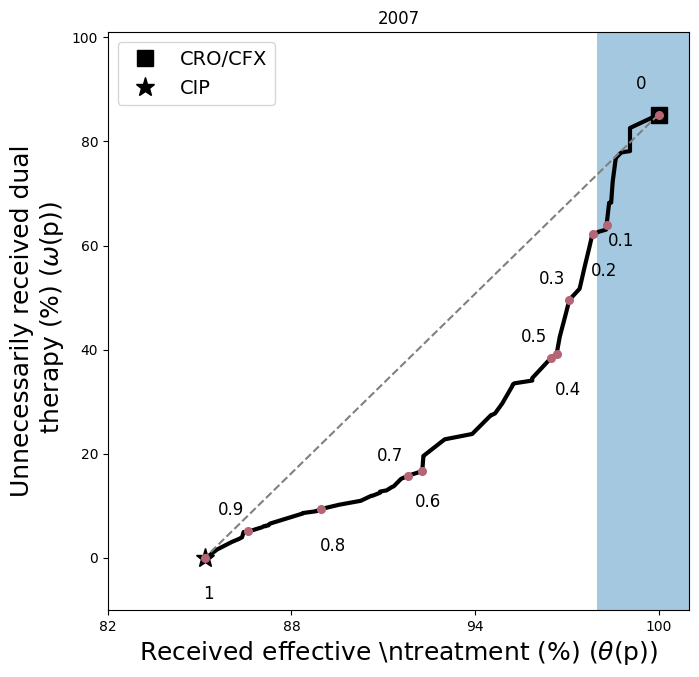

In [103]:
###### Effect of threshold on year-by-year for neural network - 2007 only - CONFERENCE PROPOSAL
polygon_important0 = Polygon([(98,110), (110,110), (110,-10), (98,-10)], alpha = 0.4)

fig, axs = plt.subplots(figsize=(7.5, 7.5), facecolor='w', edgecolor='k', sharex = 'all', sharey = 'all')
text_for_graph = ['0', '0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8','0.9', '1']
indices = [0,100,200,300,400,500,600,700,800,900,1000]
#indices = [0,10,30,50,70,90,100]

axs.set_ylabel("Unnecessarily received dual\n therapy (%) ($\omega$(p))", fontsize = 18)
axs.set_xlabel(r'Received effective \ntreatment (%) ($\theta$(p))', fontsize = 18)

axs.set_yticks(np.linspace(0,100,6), fontsize=18,**hfont)
axs.set_xticks(np.linspace(70,100,6), fontsize=18,**hfont)

axs.set_ylim([0-10,101])
axs.set_xlim([82, 101])

years = [2007]
threshold_seq = np.linspace(0,1,1001)

for year in years:
    years_train = np.array(range(year - 5, year))
    
    model_nn = MLPClassifier(solver = 'lbfgs', activation = 'tanh', max_iter = 3000 ,hidden_layer_sizes= best_hyperparameters_by_year_nn[year]['hidden_layer_sizes'], alpha =  best_hyperparameters_by_year_nn[year]['alpha'], random_state=10, learning_rate = 'adaptive' )

    test_data, train_data, X_train, y_train, X_test, y_test, cipro_R_prev  =  get_test_train_data(CIP_data_no_drop = CIP_data_no_drop, year = year, feature_names = best_features_by_year_rf[year],years_train = years_train, model_type = 1)
   
    ## fit model
    model_fit_train = model_nn.fit(X_train, y_train)
    y_predict_test = model_fit_train.predict(X_test)
    y_predict_proba = model_fit_train.predict_proba(X_test)
    
    ## get sesnitivity and specificity
    sensitivity_threshold, specificity_threshold, get_effective_threshold, incorrectly_get_X_threshold = effective_unnecessary_threshold(threshold_seq, y_predict_proba, y_test, cipro_R_prev)

    #plot
    axs.plot(get_effective_threshold, incorrectly_get_X_threshold, color = "black", linewidth = 3)
    axs.plot(100, (1 - cipro_R_prev)*100, marker='s', ls='none', ms=12, color = "black", label = "CRO/CFX")
    axs.plot((1-cipro_R_prev)*100, 0, marker='*', ls='none', ms=14, color = "black", label = "CIP")
    axs.plot([100, (1-cipro_R_prev)*100], [(1-cipro_R_prev)*100, 0], color = "#808080", linestyle="--")
    axs.set_title(year,fontsize=12)
    x = 0
    for index in indices:
        axs.plot(get_effective_threshold[index], incorrectly_get_X_threshold[index], marker='.', ls='none', ms=11, color = "#b56576")
        if index in (300, 500, 700, 900):
            if year == 2009 & index == 700:
                axs.text(get_effective_threshold[index] , incorrectly_get_X_threshold[index] + 3, text_for_graph[x], size = 12)
            else:
                axs.text(get_effective_threshold[index] - 1, incorrectly_get_X_threshold[index] + 3, text_for_graph[x], size = 12)
        elif index in (200, 400, 800, 1000):
            axs.text(get_effective_threshold[index] - 0.05, incorrectly_get_X_threshold[index] - 8, text_for_graph[x], size = 12)
        elif index == 600:
            axs.text(get_effective_threshold[index] - 0.25, incorrectly_get_X_threshold[index] - 7, text_for_graph[x], size = 12)
        elif index == 100:
            if year == 2006:
                axs.text(get_effective_threshold[index] + 0.075, incorrectly_get_X_threshold[index]  +4, text_for_graph[x], size = 12)
            else:
                axs.text(get_effective_threshold[index] + 0.05 , incorrectly_get_X_threshold[index] -4, text_for_graph[x], size = 12)
        elif index == 0:
            axs.text(get_effective_threshold[index] - 0.75, incorrectly_get_X_threshold[index] + 5, text_for_graph[x], size = 12)
        
        x = x+1
axs.add_patch(polygon_important0)

axs.legend(prop={'size':14})
plt.savefig('Graphs/Percent_effective_unnecessary_all_neural_network_2007_fellowship.png')

Oversample


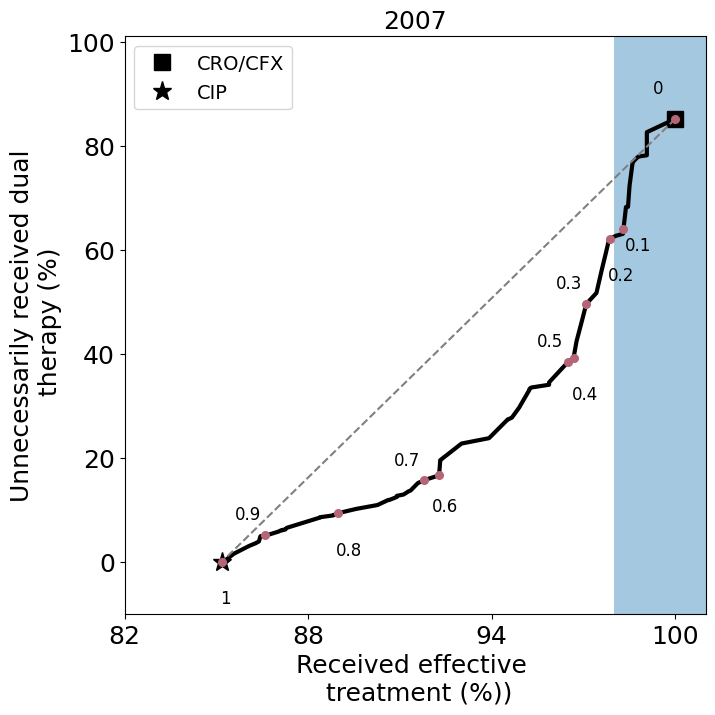

In [112]:
###### Effect of threshold on year-by-year for neural network - 2007 only - CONFERENCE PROPOSAL
polygon_important0 = Polygon([(98,110), (110,110), (110,-10), (98,-10)], alpha = 0.4)

fig, axs = plt.subplots(figsize=(7.5, 7.5), facecolor='w', edgecolor='k', sharex = 'all', sharey = 'all')
text_for_graph = ['0', '0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8','0.9', '1']
indices = [0,100,200,300,400,500,600,700,800,900,1000]
#indices = [0,10,30,50,70,90,100]
axs.tick_params(axis='both', which='major', labelsize=18)

axs.set_ylabel("Unnecessarily received dual\n therapy (%)", fontsize = 18)
axs.set_xlabel('Received effective \n treatment (%))', fontsize = 18)

axs.set_yticks(np.linspace(0,100,6), fontsize=18,**hfont)
axs.set_xticks(np.linspace(70,100,6), fontsize=18,**hfont)

axs.set_ylim([0-10,101])
axs.set_xlim([82, 101])

years = [2007]
threshold_seq = np.linspace(0,1,1001)

for year in years:
    years_train = np.array(range(year - 5, year))
    
    model_nn = MLPClassifier(solver = 'lbfgs', activation = 'tanh', max_iter = 3000 ,hidden_layer_sizes= best_hyperparameters_by_year_nn[year]['hidden_layer_sizes'], alpha =  best_hyperparameters_by_year_nn[year]['alpha'], random_state=10, learning_rate = 'adaptive' )

    test_data, train_data, X_train, y_train, X_test, y_test, cipro_R_prev  =  get_test_train_data(CIP_data_no_drop = CIP_data_no_drop, year = year, feature_names = best_features_by_year_rf[year],years_train = years_train, model_type = 1)
   
    ## fit model
    model_fit_train = model_nn.fit(X_train, y_train)
    y_predict_test = model_fit_train.predict(X_test)
    y_predict_proba = model_fit_train.predict_proba(X_test)
    
    ## get sesnitivity and specificity
    sensitivity_threshold, specificity_threshold, get_effective_threshold, incorrectly_get_X_threshold = effective_unnecessary_threshold(threshold_seq, y_predict_proba, y_test, cipro_R_prev)

    #plot
    axs.plot(get_effective_threshold, incorrectly_get_X_threshold, color = "black", linewidth = 3)
    axs.plot(100, (1 - cipro_R_prev)*100, marker='s', ls='none', ms=12, color = "black", label = "CRO/CFX")
    axs.plot((1-cipro_R_prev)*100, 0, marker='*', ls='none', ms=14, color = "black", label = "CIP")
    axs.plot([100, (1-cipro_R_prev)*100], [(1-cipro_R_prev)*100, 0], color = "#808080", linestyle="--")
    axs.set_title(year,fontsize=18)
    x = 0
    for index in indices:
        axs.plot(get_effective_threshold[index], incorrectly_get_X_threshold[index], marker='.', ls='none', ms=11, color = "#b56576")
        if index in (300, 500, 700, 900):
            if year == 2009 & index == 700:
                axs.text(get_effective_threshold[index] , incorrectly_get_X_threshold[index] + 3, text_for_graph[x], size = 12)
            else:
                axs.text(get_effective_threshold[index] - 1, incorrectly_get_X_threshold[index] + 3, text_for_graph[x], size = 12)
        elif index in (200, 400, 800, 1000):
            axs.text(get_effective_threshold[index] - 0.05, incorrectly_get_X_threshold[index] - 8, text_for_graph[x], size = 12)
        elif index == 600:
            axs.text(get_effective_threshold[index] - 0.25, incorrectly_get_X_threshold[index] - 7, text_for_graph[x], size = 12)
        elif index == 100:
            if year == 2006:
                axs.text(get_effective_threshold[index] + 0.075, incorrectly_get_X_threshold[index]  +4, text_for_graph[x], size = 12)
            else:
                axs.text(get_effective_threshold[index] + 0.05 , incorrectly_get_X_threshold[index] -4, text_for_graph[x], size = 12)
        elif index == 0:
            axs.text(get_effective_threshold[index] - 0.75, incorrectly_get_X_threshold[index] + 5, text_for_graph[x], size = 12)
        
        x = x+1
axs.add_patch(polygon_important0)

axs.legend(prop={'size':14})
plt.savefig('Graphs/Percent_effective_unnecessary_all_neural_network_2007_fellowship.png')

In [120]:
threshold_seq

array([0.   , 0.001, 0.002, ..., 0.998, 0.999, 1.   ])

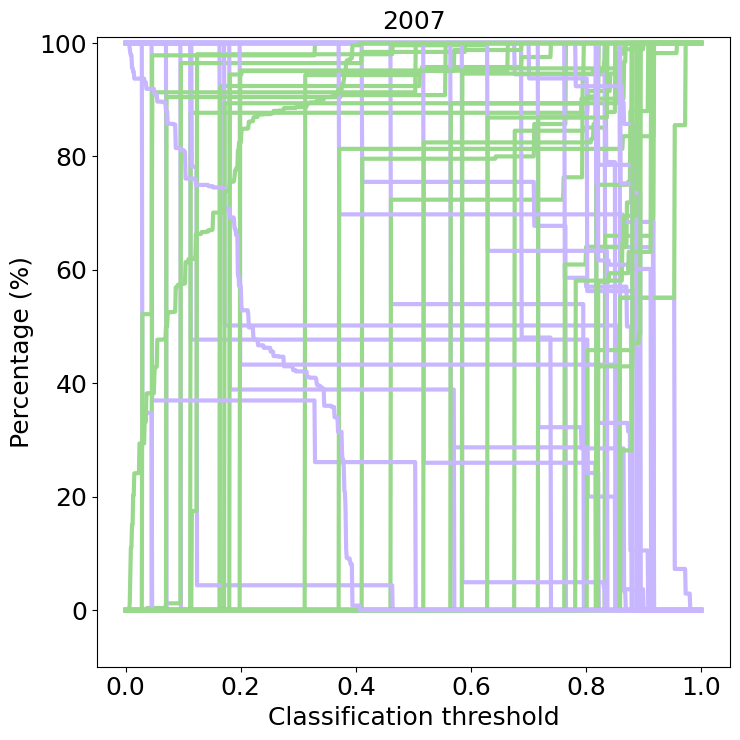

In [123]:
### Leave one out validation for MLP FELLOWSHIP 
polygon_important0 = Polygon([(98,110), (110,110), (110,-10), (98,-10)], alpha = 0.4)

from matplotlib.patches import Polygon
oversample = RandomOverSampler(sampling_strategy = 0.5,random_state=42)
fig, axs = plt.subplots(figsize=(7.5, 7.5), facecolor='w', edgecolor='k', sharex = 'all', sharey = 'all')

polygon_important0 = Polygon([(95,100), (100,100), (100,0), (95,0)], alpha = 0.4)
threshold_seq = np.linspace(0,1,1001)

text_for_graph = ['0', '0.2', '0.4', '0.6', '0.8', '1']
indices = [0,20,40,60,80,100]

axs.tick_params(axis='both', which='major', labelsize=18)

axs.set_ylabel("Percentage (%)", fontsize = 18)
axs.set_xlabel('Classification threshold', fontsize = 18)

axs.set_yticks(np.linspace(0,100,6), labelsize=18,**hfont)
axs.set_xticks(np.linspace(0,1,6), fontsize=18,**hfont)

test_years = [2007]
axs.set_ylim([0-10,101])


fig.subplots_adjust(hspace = .15, wspace=.1)
i = 0

for year in test_years: 
    years_train = np.array(range(year - 5, year))

    # first do for all clinics 

    CIP_data_training_years = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin(years_train)]
    CIP_data_testing_years = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([year])]


    test_data, train_data, X_train, y_train, X_test, y_test, cipro_R_prev  =  get_test_train_data(CIP_data_no_drop = CIP_data_no_drop, year = year, feature_names = best_features_by_year_lr[year],years_train = years_train, model_type = 0)

    model_nn = MLPClassifier(solver = 'lbfgs', activation = 'tanh', max_iter = 5000 ,hidden_layer_sizes= best_hyperparameters_by_year_nn[year]['hidden_layer_sizes'], alpha =  best_hyperparameters_by_year_nn[year]['alpha'], random_state=10, learning_rate = 'adaptive' )

    ## fit model
    model_fit_train = model_nn.fit(X_train, y_train)
    y_predict_test = model_fit_train.predict(X_test)
    y_predict_proba = model_fit_train.predict_proba(X_test)
 
    senstivitity_threshold_all, specificity_threshold_all, get_effective_threshold_all, incorrectly_get_X_threshold_all = effective_unnecessary_threshold(threshold_seq, y_predict_proba, y_test, cipro_R_prev)


    clinics = CIP_data_testing_years["CLINIC"].unique()
    for clinic in clinics: 
        train_data = CIP_data_training_years.loc[CIP_data_training_years['CLINIC'] != clinic]
          #train data - does not have clinic
        X_train = train_data[ best_features_by_year_nn[year]]
        y_train = 1 - train_data['Susceptible']
        X_train, y_train = oversample.fit_resample(X_train,y_train)

          #test data - has clinic 
        test_data = CIP_data_testing_years.loc[CIP_data_testing_years['CLINIC'] == clinic]
        X_test = test_data[ best_features_by_year_nn[year]]
        y_test = 1 - test_data['Susceptible']
        cipro_R = y_test.sum()/len(y_test)

        if cipro_R > 0: 
          #print(cipro_R)
          try:
          # test 
              X_test, y_test = oversample.fit_resample(X_test,y_test)

              model_fit_train = model_nn.fit(X_train, y_train)
              y_predict_test = model_fit_train.predict(X_test)
              sensitivity_threshold_clinic, specificity_threshold_clinic, get_effective_threshold_clinic, incorrectly_get_X_threshold_clinic = effective_unnecessary_threshold(threshold_seq, y_predict_proba, y_test, cipro_R_prev)

              axs.plot(threshold_seq, sensitivity_threshold_clinic,color = "#c8b6ff", alpha = 0.3, linewidth = 3)
              axs.plot(threshold_seq, specificity_threshold_clinic,color = "#99d98c", alpha = 0.3,linewidth = 3)


          
          except ValueError:
            #try:
              oversample = RandomOverSampler(sampling_strategy = 'minority',random_state=1)
          #train data - does not have clinic
              X_train, y_train = oversample.fit_resample(X_train,y_train)

          #test data - has clinic 

              X_test, y_test = oversample.fit_resample(X_test,y_test)
            # test 
              model_fit_train = model_nn.fit(X_train, y_train)
              y_predict_test = model_fit_train.predict(X_test)
              y_predict_proba = model_fit_train.predict_proba(X_test)
              #y_test.astype(y_predict_test.dtype)
              sensitivity_threshold_clinic, specificity_threshold_clinic, get_effective_threshold_clinic, incorrectly_get_X_threshold_clinic = effective_unnecessary_threshold(threshold_seq, y_predict_proba, y_test, cipro_R)

              axs.plot(threshold_seq, sensitivity_threshold_clinic,color = "#c8b6ff", linewidth = 3)
              axs.plot(threshold_seq, specificity_threshold_clinic,color = "#99d98c", linewidth = 3)


    axs.plot(threshold_seq, senstivitity_threshold_all, color = "#c8b6ff", label = r"Sensitivity",linewidth = 3)
    axs.plot(threshold_seq, specificity_threshold_all,color = "#99d98c", label = r"Specificity", linewidth = 3)

    axs.set_title(year,fontsize=18)


    i += 1   #

#axs.add_patch(polygon_important0)
plt.tight_layout()

plt.savefig("Graphs/LOOCV_sensitivity_specificity_all_workflow_paper_neural_network_fellowship.png", dpi = 300)

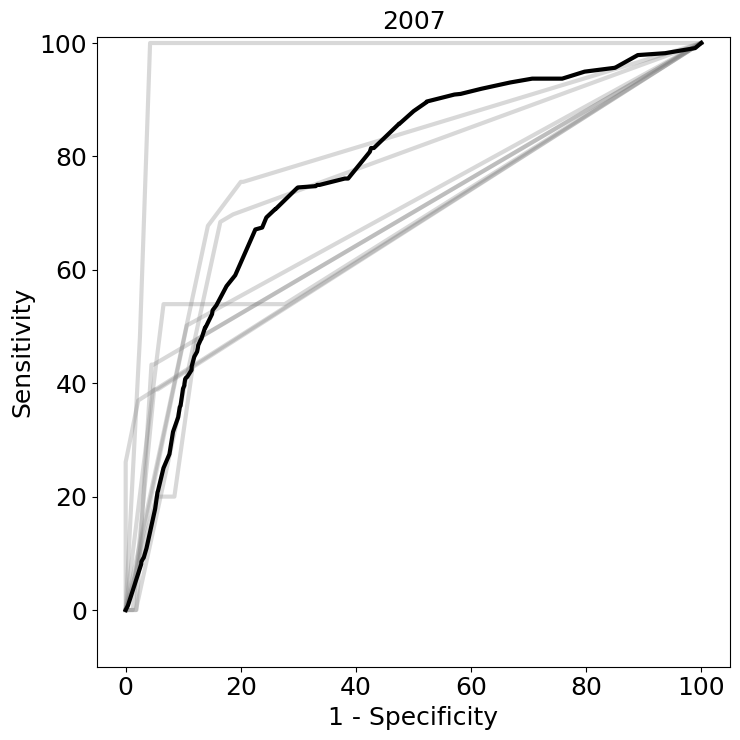

In [9]:
### Leave one out validation for MLP FELLOWSHIP 
#polygon_important0 = Polygon([(98,110), (110,110), (110,-10), (98,-10)], alpha = 0.4)

#from matplotlib.patches import Polygon
oversample = RandomOverSampler(sampling_strategy = 0.5,random_state=42)
fig, axs = plt.subplots(figsize=(7.5, 7.5), facecolor='w', edgecolor='k', sharex = 'all', sharey = 'all')

#polygon_important0 = Polygon([(95,100), (100,100), (100,0), (95,0)], alpha = 0.4)
threshold_seq = np.linspace(0,1,1001)

text_for_graph = ['0', '0.2', '0.4', '0.6', '0.8', '1']
indices = [0,20,40,60,80,100]

axs.tick_params(axis='both', which='major', labelsize=18)

axs.set_xlabel("1 - Specificity", fontsize = 18)
axs.set_ylabel('Sensitivity', fontsize = 18)

axs.set_yticks(np.linspace(0,100,6), labelsize=18,**hfont)
axs.set_xticks(np.linspace(100,0,6), fontsize=18,**hfont)

test_years = [2007]
axs.set_ylim([0-10,101])

fig.subplots_adjust(hspace = .15, wspace=.1)
i = 0

for year in test_years: 
    years_train = np.array(range(year - 5, year))

    # first do for all clinics 

    CIP_data_training_years = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin(years_train)]
    CIP_data_testing_years = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([year])]


    test_data, train_data, X_train, y_train, X_test, y_test, cipro_R_prev  =  get_test_train_data(CIP_data_no_drop = CIP_data_no_drop, year = year, feature_names = best_features_by_year_lr[year],years_train = years_train, model_type = 0)

    model_nn = MLPClassifier(solver = 'lbfgs', activation = 'tanh', max_iter = 5000 ,hidden_layer_sizes= best_hyperparameters_by_year_nn[year]['hidden_layer_sizes'], alpha =  best_hyperparameters_by_year_nn[year]['alpha'], random_state=10, learning_rate = 'adaptive' )

    ## fit model
    model_fit_train = model_nn.fit(X_train, y_train)
    y_predict_test = model_fit_train.predict(X_test)
    y_predict_proba = model_fit_train.predict_proba(X_test)
 
    senstivitity_threshold_all, specificity_threshold_all, get_effective_threshold_all, incorrectly_get_X_threshold_all = effective_unnecessary_threshold(threshold_seq, y_predict_proba, y_test, cipro_R_prev)


    clinics = CIP_data_testing_years["CLINIC"].unique()
    for clinic in clinics: 
        train_data = CIP_data_training_years.loc[CIP_data_training_years['CLINIC'] != clinic]
          #train data - does not have clinic
        X_train = train_data[ best_features_by_year_nn[year]]
        y_train = 1 - train_data['Susceptible']
        X_train, y_train = oversample.fit_resample(X_train,y_train)

          #test data - has clinic 
        test_data = CIP_data_testing_years.loc[CIP_data_testing_years['CLINIC'] == clinic]
        X_test = test_data[ best_features_by_year_nn[year]]
        y_test = 1 - test_data['Susceptible']
        cipro_R = y_test.sum()/len(y_test)

        if cipro_R > 0: 
          #print(cipro_R)
          try:
          # test 
              X_test, y_test = oversample.fit_resample(X_test,y_test)

              model_fit_train = model_nn.fit(X_train, y_train)
              y_predict_test = model_fit_train.predict(X_test)
              sensitivity_threshold_clinic, specificity_threshold_clinic, get_effective_threshold_clinic, incorrectly_get_X_threshold_clinic = effective_unnecessary_threshold(threshold_seq, y_predict_proba, y_test, cipro_R_prev)
              if metrics.roc_auc_score(y_test, y_predict_test) > 0.55:
                  axs.plot(100 - np.array(specificity_threshold_clinic), sensitivity_threshold_clinic,color = "grey", alpha = 0.3, linewidth = 3)



          
          except ValueError:
            #try:
              oversample = RandomOverSampler(sampling_strategy = 'minority',random_state=1)
          #train data - does not have clinic
              X_train, y_train = oversample.fit_resample(X_train,y_train)

          #test data - has clinic 

              X_test, y_test = oversample.fit_resample(X_test,y_test)
            # test 
              model_fit_train = model_nn.fit(X_train, y_train)
              y_predict_test = model_fit_train.predict(X_test)
              y_predict_proba = model_fit_train.predict_proba(X_test)
              #y_test.astype(y_predict_test.dtype)
              sensitivity_threshold_clinic, specificity_threshold_clinic, get_effective_threshold_clinic, incorrectly_get_X_threshold_clinic = effective_unnecessary_threshold(threshold_seq, y_predict_proba, y_test, cipro_R)
              if metrics.roc_auc_score(y_test, y_predict_test) > 0.55:
                  axs.plot(100 - np.array(specificity_threshold_clinic), sensitivity_threshold_clinic,color = "grey", alpha = 0.3, linewidth = 3)


    axs.plot(100-np.array(specificity_threshold_all), senstivitity_threshold_all, color = "black",linewidth = 3)

    axs.set_title(year,fontsize=18)


    i += 1   #

#axs.add_patch(polygon_important0)
plt.tight_layout()

plt.savefig("Graphs/LOOCV_sensitivity_specificity_auROC_all_workflow_paper_neural_network_fellowship.png", dpi = 300)

In [46]:
#### now try bootstrapping
import pickle
iterations = 100
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=10)
## am keeping the test data the same - only changing the training data
oversample = RandomOverSampler(sampling_strategy="minority", random_state=10)
def effective_unnecessary_bootstrap(model, train_data, feature_names, test_data, y_test, cipro_R):
      #1. Find apparent model performance
        #2. (A) Sample all individuals from training data w/replacement
          sample_train = train_data.sample(frac = 1, replace=True) ##(a) sample n individuals with replacement
          
          X_sample_train = sample_train[feature_names]
          y_sample_train = 1 - sample_train['Susceptible']

          if model_type in [1,2]:
            X_sample_train, y_sample_train = oversample.fit_resample(X_sample_train,y_sample_train)
            # need original test data - without any feature selection 
 
          X_test_for_bootstrap = test_data[feature_names]
        #  (B) Develop predictive model and find apparent performance of new sample data
          #best_hyperparameters1 = get_best_hyperparameters(model_nn, cv, space, X_train, y_train)
          #model_nn = MLPClassifier(solver = best_hyperparameters1['solver'], activation = best_hyperparameters1['activation'], max_iter = 5000 ,hidden_layer_sizes= best_hyperparameters1['hidden_layer_sizes'], alpha =  best_hyperparameters1['alpha'], random_state=337, learning_rate =best_hyperparameters1['learning_rate'])

          model_fit = model.fit(X_sample_train, y_sample_train)
          important_features_sample = get_best_features(feature_names, model_fit, X_test_for_bootstrap, y_test)
          while len(important_features_sample) == 0:

              sample_test = test_data.sample(frac = 1, replace=True) ##(a) sample n individuals with replacement
              X_sample_train = sample_train[feature_names]
              y_sample_train = 1 - sample_train['Susceptible']

              if model_type in [1,2]:
                X_sample_train, y_sample_train = oversample.fit_resample(X_sample_train,y_sample_train)
              model_fit = model.fit(X_sample_train, y_sample_train)
              important_features_sample = get_best_features(feature_names, model_fit, X_test_for_bootstrap, y_test)
        #  

          X_sample_train = X_sample_train[important_features_sample]
          X_test_for_bootstrap = X_test_for_bootstrap[important_features_sample]
          #best_hyperparameters2 = get_best_hyperparameters(model_fit, cv, space[model_type], X_sample_train, y_sample_train)
          #if model_type == 0:
          #        model = LogisticRegression(class_weight = 'balanced', max_iter=4000, solver = best_hyperparameters2['solver'], C = best_hyperparameters2['C'], penalty = best_hyperparameters2['penalty'])

          #elif model_type == 1:
          #        model = RandomForestClassifier(n_estimators = best_hyperparameters2['n_estimators'], min_samples_split = best_hyperparameters2['min_samples_split'], min_samples_leaf=best_hyperparameters2['min_samples_leaf'], max_features = 'sqrt', max_depth = best_hyperparameters2['max_depth'], random_state = 10)

          #elif model_type == 2:
          #    model = MLPClassifier(solver = best_hyperparameters2['solver'], activation = best_hyperparameters2['activation'], max_iter = 5000 ,hidden_layer_sizes= best_hyperparameters2['hidden_layer_sizes'], alpha =  best_hyperparameters2['alpha'], random_state=337, learning_rate =best_hyperparameters2['learning_rate'])
    
          model_fit = model.fit(X_sample_train, y_sample_train)

          #y_sample_predict = model_fit.predict(X_test)
          y_bootstrap_predict_prob = model_fit.predict_proba(X_test_for_bootstrap) #predicting it on the real data
          sensitivity_threshold_sample, specificity_threshold, get_effective_threshold, incorrectly_get_X_threshold = effective_unnecessary_threshold(threshold_seq, y_bootstrap_predict_prob, y_test, cipro_R)

          return sensitivity_threshold_sample, specificity_threshold, get_effective_threshold, incorrectly_get_X_threshold


def effective_unnecessary_bootstrap_preloaded(test_data, y_test, cipro_R, j):
          #    model = MLPClassifier(solver = best_hyperparameters2['solver'], activation = best_hyperparameters2['activation'], max_iter = 5000 ,hidden_layer_sizes= best_hyperparameters2['hidden_layer_sizes'], alpha =  best_hyperparameters2['alpha'], random_state=337, learning_rate =best_hyperparameters2['learning_rate'])
          model_name = "CIP_bootstrap_no_dev_" + str(model_type) + "_" + str(year) + "_" + str(j) + ".sav" 
          X_data_name = "CIP_bootstrap_X_no_dev_" + str(model_type) + "_" + str(year) + "_" + str(j) + ".csv" 
          X_train_bootstrap = pd.read_csv(X_data_name)
          model_fit = pickle.load(open(model_name, 'rb'))
          X_test_for_bootstrap = test_data[X_train_bootstrap.columns[1:len(X_train_bootstrap.columns)]]
          #y_sample_predict = model_fit.predict(X_test)
          y_bootstrap_predict_prob = model_fit.predict_proba(X_test_for_bootstrap) #predicting it on the real data
          sensitivity_threshold_sample, specificity_threshold, get_effective_threshold, incorrectly_get_X_threshold = effective_unnecessary_threshold(threshold_seq, y_bootstrap_predict_prob, y_test, cipro_R)

          return sensitivity_threshold_sample, specificity_threshold, get_effective_threshold, incorrectly_get_X_threshold


In [89]:
model_type = 2
year = 2005 
j = 0
X_data_name = "CIP_bootstrap_X_" + str(model_type) + "_" + str(year) + "_" + str(j) + ".csv" 
X_train_bootstrap = pd.read_csv(X_data_name)
X_train_bootstrap.columns[1:len(X_train_bootstrap.columns)]

Index(['MSW', 'MSM', 'DELTA_CLINIC', 'PREV_CLINIC', 'West', 'Oth/Unk/Missing',
       'MSMW'],
      dtype='object')

In [7]:
#### now try bootstrapping
iterations = 100
## DO NOT SAMPLE THE TARGET DATA
def bootstrap_sensitivity_specificity(iterations, model, train_data, X_test, y_test, actual_sensitivity, actual_specificity):
      #1. Find apparent model performance
    for threshold in threshold_seq:
      bootstrapped_stats = []

      for i in range(iterations):
          #2. (A) Sample all individuals from training data w/replacement
            sample_train = train_data.sample(frac = 1, replace=True) ##(a) sample n individuals with replacement
            
            X_sample_train = sample_train[feature_names]
            y_sample_train = 1 - sample_train['Susceptible']
            cipro_R_sample = y_sample_test.sum()/len(y_sample_test)

            if model_type in [1,2]:
              X_sample_train, y_sample_train = oversample.fit_resample(X_sample_train,y_sample_train)

          #  (B) Develop predictive model and find apparent performance of new sample data
            #best_hyperparameters1 = get_best_hyperparameters(model_nn, cv, space, X_train, y_train)
            #model_nn = MLPClassifier(solver = best_hyperparameters1['solver'], activation = best_hyperparameters1['activation'], max_iter = 5000 ,hidden_layer_sizes= best_hyperparameters1['hidden_layer_sizes'], alpha =  best_hyperparameters1['alpha'], random_state=337, learning_rate =best_hyperparameters1['learning_rate'])
            # need original test data - without any feature selection 
            test_data, train_data, X_train, y_train, X_test, y_test, cipro_R_prev  =  get_test_train_data(CIP_data_no_drop = CIP_data_no_drop, year = year, feature_names = feature_names,years_train = years_train, model_type =model_type)

            model_fit = model.fit(X_sample_train, y_sample_train)
            important_features_sample = get_best_features(feature_names, model_fit, X_test, y_test)
            while len(important_features_sample) == 0:

                X_sample_train = sample_train[feature_names]
                y_sample_train = 1 - sample_train['Susceptible']
                cipro_R_sample = y_sample_test.sum()/len(y_sample_test)

                if model_type in [1,2]:
                  X_sample_train, y_sample_train = oversample.fit_resample(X_sample_train,y_sample_train)
                model_fit = model.fit(X_sample_train, y_sample_train)
                important_features_sample = get_best_features(feature_names, model_fit, X_test, y_test)
          #  
            X_sample_train = X_sample_train[important_features_sample]
            #best_hyperparameters2 = get_best_hyperparameters(model_nn, cv, space, X_sample_train, X_sample_test)
            #model_nn = MLPClassifier(solver = best_hyperparameters2['solver'], activation = best_hyperparameters2['activation'], max_iter = 5000 ,hidden_layer_sizes= best_hyperparameters2['hidden_layer_sizes'], alpha =  best_hyperparameters2['alpha'], random_state=337, learning_rate =best_hyperparameters1['learning_rate'])
      
            model_fit = model.fit(X_sample_train, y_sample_train)

          #  (C) Performance of predictive model on original sample (i.e. original training population, X_test, with new selected features)
            test_data, train_data, X_train, y_train, X_test, y_test, cipro_R_prev  =  get_test_train_data(CIP_data_no_drop = CIP_data_no_drop, year = year, feature_names = important_features_sample,years_train = years_train, model_type =model_type)
  
            y_bootstrap_predict_proba = model_fit.predict_proba(X_test)

            y_bootstrap_predict = np.where(y_bootstrap_predict_proba[:, 1] > threshold, 1, 0)

            tn_test, fp_test, fn_test, tp_test = confusion_matrix(y_true=y_test, y_pred=y_bootstrap_predict).ravel()

            sensitivity_test = tp_test / (tp_test + fn_test)
            specificity_test = tn_test / (tn_test + fp_test)

          ### (D) Calculate estimate fo variance  by getting (B) - (D) 
            difference_sensitivity = actual_sensitivity[threshold] - sensitivity_test ## according to https://ocw.mit.edu/courses/18-05-introduction-to-probability-and-statistics-spring-2014/resources/mit18_05s14_reading24/
            difference_specificity = actual_specificity[threshold] - specificity_test ## according to https://ocw.mit.edu/courses/18-05-introduction-to-probability-and-statistics-spring-2014/resources/mit18_05s14_reading24/



            bootstrapped_stats.append(
            {

                'Difference_specificity': difference_specificity, 
                'Difference_sensitivity': difference_sensitivity#,
            }
          )


    bootstrapped_stats = pd.DataFrame(bootstrapped_stats)
    ## Step 3: Get average optimization

    lower_quartile_specificity.append(np.percentile(bootstrapped_stats["Difference_specificity"], 2.5))
    upper_quartile_specificity = np.percentile(bootstrapped_stats["Difference_specificity"], 97.5)
    lower_quartile_sensitivity.append(np.percentile(bootstrapped_stats["Difference_sensitivity"], 2.5))
    upper_quartile_sensitivity = np.percentile(bootstrapped_stats["Difference_sensitivity"], 97.5)
 ## Step 4: Get optimization-corrected performance

    return lower_quartile_specificity, upper_quartile_specificity,lower_quartile_sensitivity,upper_quartile_sensitivity


def bootstrap_sensitivity_specificity_preloaded(iterations,  y_test, actual_sensitivity, actual_specificity):
      #1. Find apparent model performance
    lower_quartile_specificity_all = []
    upper_quartile_specificity_all = []
    lower_quartile_sensitivity_all = []
    upper_quartile_sensitivity_all = []
    for threshold in threshold_seq:
      bootstrapped_stats = []

      for j in range(iterations):
            model_name = "CIP_bootstrap_no_dev_" + str(model_type) + "_" + str(year) + "_" + str(j) + ".sav" 
            X_data_name = "CIP_bootstrap_X_no_dev_" + str(model_type) + "_" + str(year) + "_" + str(j) + ".csv" 
            X_train_bootstrap = pd.read_csv(X_data_name)
            model_fit = pickle.load(open(model_name, 'rb'))
            X_test_for_bootstrap = test_data[X_train_bootstrap.columns[1:len(X_train_bootstrap.columns)]]
            #y_sample_predict = model_fit.predict(X_test)
            y_bootstrap_predict_prob = model_fit.predict_proba(X_test_for_bootstrap) #predicting it on the real data

            y_bootstrap_predict = np.where(y_bootstrap_predict_prob[:, 1] > threshold, 1, 0)

            tn_test, fp_test, fn_test, tp_test = confusion_matrix(y_true=y_test, y_pred=y_bootstrap_predict).ravel()

            sensitivity_test = (tp_test / (tp_test + fn_test))*100
            specificity_test = (tn_test / (tn_test + fp_test))*100

          ### (D) Calculate estimate fo variance  by getting (B) - (D) 
            difference_sensitivity = sensitivity_test - actual_sensitivity[np.where(threshold_seq ==threshold)[0][0]] ## according to https://ocw.mit.edu/courses/18-05-introduction-to-probability-and-statistics-spring-2014/resources/mit18_05s14_reading24/
            difference_specificity = specificity_test - actual_specificity[np.where(threshold_seq ==threshold)[0][0]]  ## according to https://ocw.mit.edu/courses/18-05-introduction-to-probability-and-statistics-spring-2014/resources/mit18_05s14_reading24/


            bootstrapped_stats.append(
            {

                'Difference_specificity': difference_specificity, 
                'Difference_sensitivity': difference_sensitivity#,
            }
          )
      alpha = 0.05
      bootstrapped_stats = pd.DataFrame(bootstrapped_stats)

      upper_quartile_senstivity, lower_quartile_sensitivity = actual_sensitivity[np.where(threshold_seq ==threshold)[0][0]] - np.percentile(bootstrapped_stats["Difference_sensitivity"], [100 * (1 - alpha / 2.0), 100 * alpha / 2.0])
      upper_quartile_specificity, lower_quartile_specificity = actual_specificity[np.where(threshold_seq ==threshold)[0][0]] - np.percentile(bootstrapped_stats["Difference_specificity"], [100 * (1 - alpha / 2.0), 100 * alpha / 2.0])



      lower_quartile_specificity_all.append(lower_quartile_specificity)
      upper_quartile_specificity_all.append(upper_quartile_specificity)
      lower_quartile_sensitivity_all.append(lower_quartile_sensitivity)
      upper_quartile_sensitivity_all.append(upper_quartile_senstivity)
 ## Step 4: Get optimization-corrected performance

    return lower_quartile_specificity_all, upper_quartile_specificity_all,lower_quartile_sensitivity_all,upper_quartile_sensitivity_all



In [47]:
################################ Get hyperparameters and best features for each model  ###########################
#### Loop set up 
threshold_seq = np.linspace(0,1,1001)
test_years = [2005, 2006, 2007, 2008, 2009, 2010]  #np.array(range(2005, 2011))
oversample = RandomOverSampler(sampling_strategy = 0.5,random_state=10) #need for neural network and random forest
model_types = ["Logistic_regression",  "Random_forest", "Neural_network"]
i = 0

# logistic regression - random initial parameters
model_lr = LogisticRegression(class_weight = 'balanced', max_iter=4000, solver = "lbfgs", C = 0.27, penalty = 'l2')
# random forest - random initial parameters
model_rf = RandomForestClassifier(n_estimators = 171, min_samples_split = 1, min_samples_leaf=1, max_features = 'sqrt', max_depth = 89, random_state = 10)
# neural network - random parameters
model_nn = MLPClassifier(solver = 'lbfgs', activation = 'tanh', max_iter = 3000 ,hidden_layer_sizes= 12, alpha =1.291549665014884, random_state=10, learning_rate = 'adaptive' )
unfitted_models = [model_lr, model_rf, model_nn]
### Hyperparameter tuning
cv = RepeatedStratifiedKFold(n_splits=10,  n_repeats=10,random_state=1) ## 10-fold cross validations
# logistic regression 
space_lr = dict()
space_lr['solver'] = ['newton-cg', 'lbfgs', 'liblinear']
space_lr['penalty'] = ['l1', 'l2']
space_lr['C'] = np.arange(0, 100, .01)
best_hyperparameters_by_year_lr = {}
# random forest 
space_rf = dict()
space_rf['n_estimators'] = np.arange(100, 201, 1)
space_rf['max_depth'] = np.arange(1, 200, 1)
space_rf['min_samples_split'] = np.arange(1, 25, 1)
space_rf['min_samples_leaf'] = np.arange(1, 25, 1)
best_hyperparameters_by_year_rf = {}
# neural network 
space_nn = dict()
space_nn['solver'] = ['lbfgs', 'sgd', 'adam']
space_nn['activation'] = ['tanh', 'relu']
space_nn['alpha'] = np.logspace(-1, 1, 10)
space_nn['learning_rate'] = ['constant','adaptive']
space_nn['hidden_layer_sizes'] = [(4,), (6,), (8,), (10,), (12,), (13,), (14,)]
best_hyperparameters_by_year_nn = {}

space = [space_lr, space_rf, space_nn]
best_hyperparameters_by_year = [best_hyperparameters_by_year_lr, best_hyperparameters_by_year_rf,best_hyperparameters_by_year_nn]

### Feature Engineering
feature_names = ['MSM','MSMW', 'MSW', 'Oth/Unk/Missing','Northeast', 'Southeast', 'Southwest', 'West', 'Midwest','PREV_REGION', 'PREV_CLINIC', 'DELTA_REGION', 'DELTA_CLINIC']
best_features_by_year_lr = {}
best_features_by_year_rf = {}
best_features_by_year_nn = {}
best_features_by_year = [best_features_by_year_lr, best_features_by_year_rf, best_features_by_year_nn]

imporances_all_models = pd.DataFrame(0, index = feature_names, columns=np.arange(len(test_years)*3))
indices_for_importance = [6,12,0] ## need to be in correct order 
imporances_all_models2 = pd.DataFrame(0, index = feature_names, columns=np.arange(len(test_years)*3))

### ROC by year 
ROC_by_year_rf = {}
ROC_by_year_lr = {}
ROC_by_year_nn = {}

ROC_by_year = [ROC_by_year_lr, ROC_by_year_rf, ROC_by_year_nn]


############# data

#nn_data 

best_hyperparameters_by_year_lr = {2005: {'solver': 'liblinear', 'penalty': 'l1', 'C': 54.85}, 2006: {'solver': 'liblinear', 'penalty': 'l1', 'C': 8.65}, 2007: {'solver': 'liblinear', 'penalty': 'l1', 'C': 35.730000000000004}, 2008: {'solver': 'liblinear', 'penalty': 'l1', 'C': 35.730000000000004}, 2009: {'solver': 'liblinear', 'penalty': 'l1', 'C': 8.65}, 2010: {'solver': 'liblinear', 'penalty': 'l1', 'C': 8.65}}
best_hyperparameters_by_year_rf ={2005: {'n_estimators': 181, 'min_samples_split': 20, 'min_samples_leaf': 5, 'max_depth': 99}, 2006: {'n_estimators': 181, 'min_samples_split': 20, 'min_samples_leaf': 5, 'max_depth': 99}, 2007: {'n_estimators': 181, 'min_samples_split': 20, 'min_samples_leaf': 5, 'max_depth': 99}, 2008: {'n_estimators': 181, 'min_samples_split': 20, 'min_samples_leaf': 5, 'max_depth': 99}, 2009: {'n_estimators': 181, 'min_samples_split': 20, 'min_samples_leaf': 5, 'max_depth': 99}, 2010: {'n_estimators': 181, 'min_samples_split': 20, 'min_samples_leaf': 5, 'max_depth': 99}}
best_hyperparameters_by_year_nn ={2005: {'solver': 'adam', 'learning_rate': 'adaptive', 'hidden_layer_sizes': (13,), 'alpha': 0.12080421346773286, 'activation': 'relu'}, 2006: {'solver': 'adam', 'learning_rate': 'adaptive', 'hidden_layer_sizes': (13,), 'alpha': 0.12080421346773286, 'activation': 'relu'}, 2007: {'solver': 'adam', 'learning_rate': 'adaptive', 'hidden_layer_sizes': (13,), 'alpha': 0.12080421346773286, 'activation': 'relu'}, 2008: {'solver': 'adam', 'learning_rate': 'adaptive', 'hidden_layer_sizes': (13,), 'alpha': 0.12080421346773286, 'activation': 'relu'}, 2009: {'solver': 'adam', 'learning_rate': 'adaptive', 'hidden_layer_sizes': (13,), 'alpha': 0.12080421346773286, 'activation': 'relu'}, 2010: {'solver': 'adam', 'learning_rate': 'adaptive', 'hidden_layer_sizes': (13,), 'alpha': 0.12080421346773286, 'activation': 'relu'}}
best_features_by_year_lr = {2005: ['PREV_CLINIC', 'MSW', 'DELTA_CLINIC', 'PREV_REGION', 'MSM', 'Northeast', 'Oth/Unk/Missing'], 2006: ['DELTA_REGION', 'PREV_CLINIC', 'DELTA_CLINIC', 'MSW', 'PREV_REGION', 'Oth/Unk/Missing', 'MSM', 'Southwest', 'Southeast'], 2007: ['MSW', 'PREV_CLINIC', 'MSM', 'Oth/Unk/Missing'], 2008: ['PREV_CLINIC', 'DELTA_CLINIC', 'West', 'MSW', 'MSM', 'PREV_REGION', 'MSMW', 'Oth/Unk/Missing'], 2009: ['PREV_CLINIC', 'Oth/Unk/Missing', 'DELTA_CLINIC'], 2010: ['MSW', 'MSM', 'DELTA_CLINIC', 'PREV_CLINIC', 'Oth/Unk/Missing', 'West', 'Southwest', 'MSMW', 'DELTA_REGION', 'Southeast', 'PREV_REGION', 'Northeast']}
best_features_by_year_rf ={2005: ['MSW', 'DELTA_CLINIC', 'MSM', 'PREV_CLINIC', 'West', 'PREV_REGION', 'DELTA_REGION', 'Oth/Unk/Missing', 'MSMW'], 2006: ['MSW', 'MSM', 'DELTA_CLINIC', 'PREV_CLINIC', 'MSMW', 'Northeast', 'Southeast', 'Oth/Unk/Missing'], 2007: ['MSW', 'PREV_CLINIC', 'MSM', 'Oth/Unk/Missing', 'DELTA_CLINIC', 'Southeast', 'MSMW', 'Northeast'], 2008: ['MSW', 'PREV_CLINIC', 'MSM', 'West', 'Northeast', 'DELTA_CLINIC', 'Oth/Unk/Missing', 'DELTA_REGION', 'Southwest'], 2009: ['PREV_CLINIC', 'MSW', 'DELTA_REGION', 'Oth/Unk/Missing', 'West', 'Northeast', 'Southeast'], 2010: ['MSW', 'DELTA_CLINIC', 'MSM', 'PREV_CLINIC', 'PREV_REGION', 'Oth/Unk/Missing', 'West', 'Southeast', 'MSMW', 'DELTA_REGION', 'Northeast']}
best_features_by_year_nn ={2005: ['MSM', 'DELTA_CLINIC', 'MSW', 'Southwest', 'MSMW', 'DELTA_REGION', 'Oth/Unk/Missing'], 2006: ['DELTA_CLINIC', 'MSM', 'PREV_CLINIC', 'MSW', 'DELTA_REGION', 'PREV_REGION', 'MSMW', 'Northeast', 'Oth/Unk/Missing'], 2007: ['PREV_CLINIC', 'MSW', 'MSM', 'Southwest', 'MSMW'], 2008: ['MSM', 'DELTA_CLINIC', 'PREV_CLINIC', 'Northeast', 'MSW', 'MSMW'], 2009: ['PREV_CLINIC', 'MSM', 'DELTA_CLINIC', 'Southeast', 'DELTA_REGION', 'Oth/Unk/Missing', 'Southwest', 'West', 'Northeast'], 2010: ['MSM', 'MSW', 'PREV_CLINIC', 'DELTA_CLINIC', 'PREV_REGION', 'Southeast', 'MSMW', 'Southwest', 'Oth/Unk/Missing', 'Northeast', 'West']}
ROC_by_year_lr = {2005: 0.7322853685805495, 2006: 0.7423710317796873, 2007: 0.7048918256421187, 2008: 0.6968498187602681, 2009: 0.639172181709682, 2010: 0.6797716960932587}
ROC_by_year_rf ={2005: 0.7586099894081821, 2006: 0.7418094620985698, 2007: 0.7033306886765269, 2008: 0.6939654992567867, 2009: 0.679491422061069, 2010: 0.6840913725423555}
ROC_by_year_nn ={2005: 0.7372748012808253, 2006: 0.7324350027761852, 2007: 0.6936770334581981, 2008: 0.7043116801835867, 2009: 0.6705138326697341, 2010: 0.6835202587500921}



In [102]:
#### now try bootstrapping
iterations = 100
## DO NOT SAMPLE THE TARGET DATA
def bootstrap_auROC(iterations, model, train_data, X_test, y_test, ROC_actual):
      #1. Find apparent model performance
    bootstrapped_stats = []
    for i in range(iterations):
        #2. (A) Sample all individuals from training data w/replacement
          sample_train = train_data.sample(frac = 1, replace=True) ##(a) sample n individuals with replacement
          
          X_sample_train = sample_train[feature_names]
          y_sample_train = 1 - sample_train['Susceptible']

          if model_type in [1,2]:
            X_sample_train, y_sample_train = oversample.fit_resample(X_sample_train,y_sample_train)

        #  (B) Develop predictive model and find apparent performance of new sample data
          #best_hyperparameters1 = get_best_hyperparameters(model_nn, cv, space, X_train, y_train)
          #model_nn = MLPClassifier(solver = best_hyperparameters1['solver'], activation = best_hyperparameters1['activation'], max_iter = 5000 ,hidden_layer_sizes= best_hyperparameters1['hidden_layer_sizes'], alpha =  best_hyperparameters1['alpha'], random_state=337, learning_rate =best_hyperparameters1['learning_rate'])
          # need original test data - without any feature selection 
          test_data, train_data, X_train, y_train, X_test, y_test, cipro_R_prev  =  get_test_train_data(CIP_data_no_drop = CIP_data_no_drop, year = year, feature_names = feature_names,years_train = years_train, model_type =model_type)

          model_fit = model.fit(X_sample_train, y_sample_train)
          important_features_sample = get_best_features(feature_names, model_fit, X_test, y_test)
          while len(important_features_sample) == 0:
              X_sample_train = sample_train[feature_names]
              y_sample_train = 1 - sample_train['Susceptible']
              if model_type in [1,2]:
                X_sample_train, y_sample_train = oversample.fit_resample(X_sample_train,y_sample_train)
              model_fit = model.fit(X_sample_train, y_sample_train)
              important_features_sample = get_best_features(feature_names, model_fit, X_test, y_test)
        #  
          X_sample_train = X_sample_train[important_features_sample]
          #best_hyperparameters2 = get_best_hyperparameters(model_nn, cv, space, X_sample_train, X_sample_test)
          #model_nn = MLPClassifier(solver = best_hyperparameters2['solver'], activation = best_hyperparameters2['activation'], max_iter = 5000 ,hidden_layer_sizes= best_hyperparameters2['hidden_layer_sizes'], alpha =  best_hyperparameters2['alpha'], random_state=337, learning_rate =best_hyperparameters1['learning_rate'])
    
          model_fit = model.fit(X_sample_train, y_sample_train)

        #  (C) Performance of predictive model on original sample (i.e. original training population, X_test, with new selected features)
          test_data, train_data, X_train, y_train, X_test, y_test, cipro_R_prev  =  get_test_train_data(CIP_data_no_drop = CIP_data_no_drop, year = year, feature_names = important_features_sample,years_train = years_train, model_type =model_type)
 
          y_bootstrap_predict = model_fit.predict(X_test)
          ROC_AUC_bootstrap_test_performance = metrics.roc_auc_score(y_test, y_bootstrap_predict) 
        ### (D) Calculate estimate fo variance  by getting (B) - (D) 

          difference = ROC_AUC_bootstrap_test_performance - ROC_actual ## according to https://ocw.mit.edu/courses/18-05-introduction-to-probability-and-statistics-spring-2014/resources/mit18_05s14_reading24/

          bootstrapped_stats.append(
          {

              'Difference': difference#,
          }
        )


    bootstrapped_stats = pd.DataFrame(bootstrapped_stats)
    ## Step 3: Get average optimization

    lower_quartile = np.percentile(bootstrapped_stats["Difference"], 2.5)
    upper_quartile = np.percentile(bootstrapped_stats["Difference"], 97.5)
 ## Step 4: Get optimization-corrected performance

    return lower_quartile, upper_quartile

In [43]:
# need to get the perecent of MSM, CAL (not MSM to not double count), and HI 

CAL_HI_MSM_by_year = []
for year in test_years:
    year_data = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'] == year]
    MSM = year_data['MSM'].sum()
    HI_CAL =  len(year_data[(year_data['CLINIC'].isin(['HON', 'SDG', 'SFO', 'ORA', 'LAX', 'LBC']))]['Susceptible']) - year_data[(year_data['CLINIC'].isin(['HON', 'SDG', 'SFO', 'ORA', 'LAX', 'LBC'])) & (year_data['MSM'] == 0)]['Susceptible'].sum()
    CAL_HI_MSM_by_year.append((MSM + HI_CAL)/(len(year_data)) * 100)



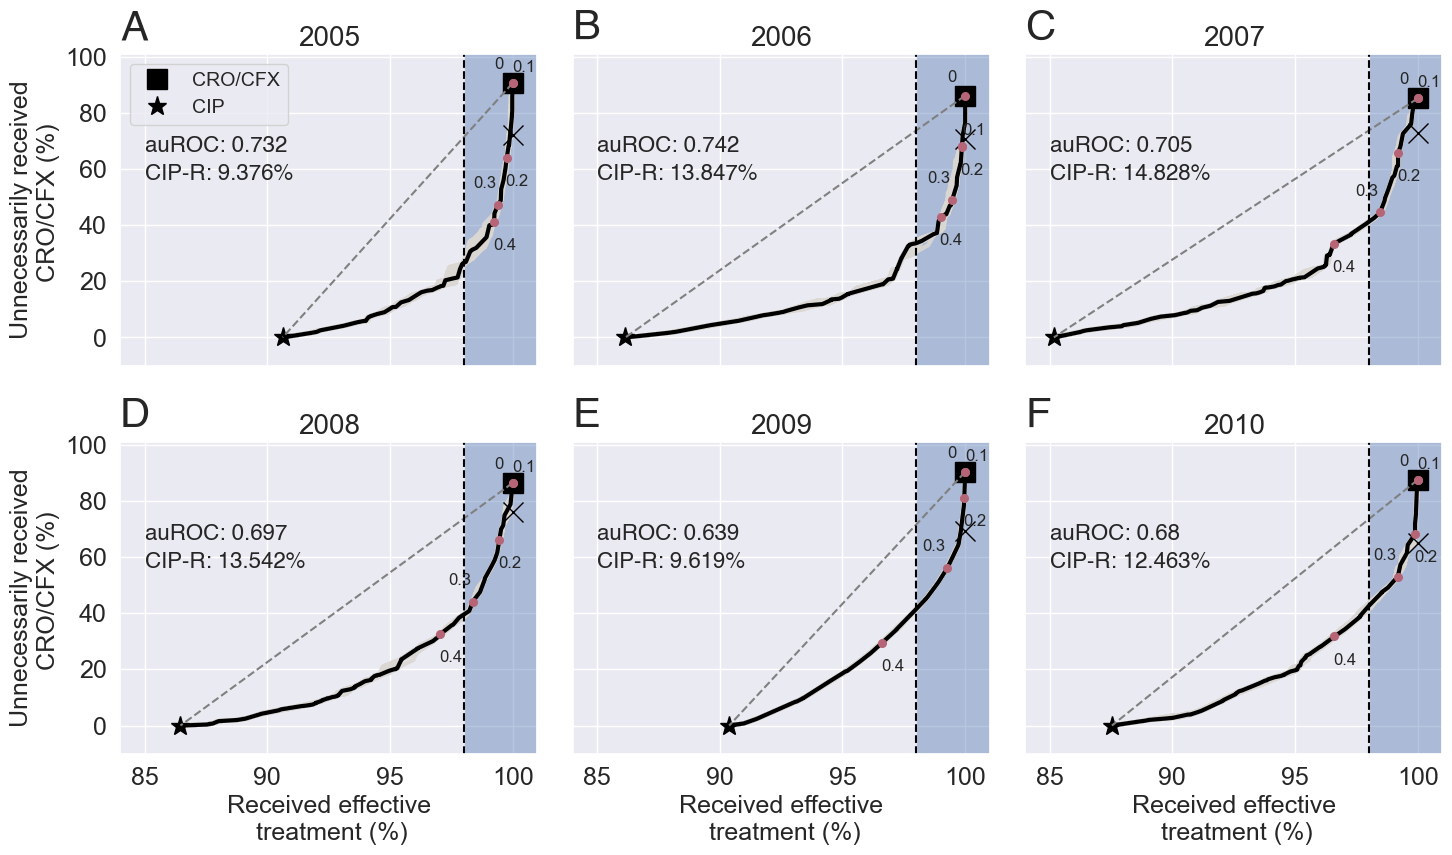

In [51]:
###### Effect of threshold on year-by-year for logistic regression with bootstrapping
feature_names = ['MSM','MSMW', 'MSW', 'Oth/Unk/Missing','Northeast', 'Southeast', 'Southwest', 'West', 'Midwest','PREV_REGION', 'PREV_CLINIC', 'DELTA_REGION', 'DELTA_CLINIC']
iterations = 100
from matplotlib.patches import Polygon
polygon_important0 = Polygon([(98,110), (110,110), (110,-10), (98,-10)], alpha = 0.4)
polygon_important1 = Polygon([(98,110), (110,110), (110,-10), (98,-10)], alpha = 0.4)
polygon_important2 = Polygon([(98,110), (110,110), (110,-10), (98,-10)], alpha = 0.4)
polygon_important3 = Polygon([(98,110), (110,110), (110,-10), (98,-10)], alpha = 0.4)
polygon_important4 = Polygon([(98,110), (110,110), (110,-10), (98,-10)], alpha = 0.4)
polygon_important5 = Polygon([(98,110), (110,110), (110,-10), (98,-10)], alpha = 0.4)

fig, axs = plt.subplots(2,3, figsize=(15, 9), facecolor='w', edgecolor='k', sharex = 'all', sharey = 'all')

text_for_graph = ['0', '0.1', '0.2', '0.3', '0.4'] #, '0.5', '0.6', '0.7', '0.8', '0.9', '1']
indices = [0, 100, 200, 300, 400] #, 500, 600, 700, 800, 900, 1000]
axs[0,0].tick_params(axis='both', which='major', labelsize=18)
axs[1,0].tick_params(axis='both', which='major', labelsize=18)
axs[1,1].tick_params(axis='both', which='major', labelsize=18)
axs[1,2].tick_params(axis='both', which='major', labelsize=18)

axs[0,0].set_ylabel("Unnecessarily received\n  CRO/CFX (%)", fontsize = 18)
axs[1,0].set_ylabel("Unnecessarily received\n  CRO/CFX (%)", fontsize = 18)
axs[1,0].set_xlabel("Received effective\n treatment (%)", fontsize = 18)
axs[1,1].set_xlabel("Received effective\n treatment (%)", fontsize = 18)
axs[1,2].set_xlabel("Received effective\n treatment (%)", fontsize = 18)

axs[0,0].set_yticks(np.linspace(0,100,6), labelsize=18,**hfont)
axs[1,0].set_yticks(np.linspace(0,100,6), fontsize=18,**hfont)
axs[1,0].set_xticks([85, 90, 95, 100], fontsize=18,**hfont)
axs[1,1].set_xticks([85, 90, 95, 100], fontsize=18,**hfont)
axs[1,2].set_xticks([85, 90, 95, 100], fontsize=18,**hfont)


axs[0,0].set_ylim([0-10,101])
axs[0,0].set_xlim([84, 101])
axs = axs.ravel()
threshold_seq = np.linspace(0,1,1001)
unneccessary_treatment_98_efficacy_lr = []
i = 0
years = [2005, 2006, 2007, 2008, 2009, 2010]
for year in years:
    model_type = 0
    years_train = np.array(range(year - 5, year))
    
    model_lr = LogisticRegression(class_weight = 'balanced', max_iter=4000, solver = best_hyperparameters_by_year_lr[year]['solver'], C = best_hyperparameters_by_year_lr[year]['C'], penalty = best_hyperparameters_by_year_lr[year]['penalty'])

    test_data, train_data, X_train, y_train, X_test, y_test, cipro_R_prev  =  get_test_train_data(CIP_data_no_drop = CIP_data_no_drop, year = year, feature_names = best_features_by_year_lr[year],years_train = years_train, model_type = 0)
    ## fit model
    model_fit_train = model_lr.fit(X_train, y_train)
    y_predict_test = model_fit_train.predict(X_test)
    y_predict_proba = model_fit_train.predict_proba(X_test)
    
    ## get sesnitivity and specificity
    sensitivity_threshold, specificity_threshold, get_effective_threshold, incorrectly_get_X_threshold = effective_unnecessary_threshold(threshold_seq, y_predict_proba, y_test, cipro_R_prev)
    unneccessary_treatment_98_efficacy_lr.append(incorrectly_get_X_threshold[get_effective_threshold.index(min([x for x in get_effective_threshold if x >= 98]))] )

    #plot
    for j in range(iterations):
        #sensitivity_threshold_sample, specificity_threshold_sample, get_effective_threshold_sample, incorrectly_get_X_threshold_sample = effective_unnecessary_bootstrap( model_lr, train_data, test_data)
        sensitivity_threshold_sample, specificity_threshold_sample, get_effective_threshold_sample, incorrectly_get_X_threshold_sample = effective_unnecessary_bootstrap_preloaded(test_data, y_test, cipro_R_prev, j)

        axs[i].plot(get_effective_threshold_sample, incorrectly_get_X_threshold_sample, color = "#DBD7D2", linewidth = 3, alpha=0.9)

    axs[i].plot(get_effective_threshold, incorrectly_get_X_threshold, color = "black", linewidth = 3)
    axs[i].plot(100, (1 - cipro_R_prev)*100, marker='s', ls='none', ms=14, color = "black", label = "CRO/CFX")
    axs[i].plot((1-cipro_R_prev)*100, 0, marker='*', ls='none', ms=14, color = "black", label = "CIP")
    
    axs[i].plot(100, (100-CAL_HI_MSM_by_year[i]), marker='x', ls='none', ms=14, color = "black")

    axs[i].plot([100, (1-cipro_R_prev)*100], [(1-cipro_R_prev)*100, 0], color = "#808080", linestyle="--")
    axs[i].text(axs[i].get_xlim()[0] , axs[i].get_ylim()[1] + 5, labels[i], fontsize = 30, **hfont)
    axs[i].set_title(year,fontsize=20)  
    axs[i].text(axs[i].get_xlim()[0] + 1 , axs[i].get_ylim()[1] - 35, f'auROC: {round(ROC_by_year_lr[year], 3)}', fontsize = 16, **hfont)
    axs[i].text(axs[i].get_xlim()[0] + 1 , axs[i].get_ylim()[1] - 45, f'CIP-R: {round(cipro_R_prev*100, 3)}%', fontsize = 16, **hfont)
    axs[i].axvline(x = 98, color = 'black', linestyle="--")
    x = 0
    for index in indices:
        axs[i].plot(get_effective_threshold[index], incorrectly_get_X_threshold[index], marker='.', ls='none', ms=11, color = "#b56576")
        if index in (300, 500, 700, 900):
            if year == 2009 & index == 700:
                axs[i].text(get_effective_threshold[index] , incorrectly_get_X_threshold[index] + 6, text_for_graph[x], size = 12)
            else:
                axs[i].text(get_effective_threshold[index] - 1, incorrectly_get_X_threshold[index] + 6, text_for_graph[x], size = 12)
        elif index in (200, 400, 800, 1000):
            axs[i].text(get_effective_threshold[index] - 0.05, incorrectly_get_X_threshold[index] - 10, text_for_graph[x], size = 12)
        elif index == 600:
            axs[i].text(get_effective_threshold[index] - 0.25, incorrectly_get_X_threshold[index] - 7, text_for_graph[x], size = 12)
        elif index == 100:
            axs[i].text(get_effective_threshold[index] , incorrectly_get_X_threshold[index]  +4, text_for_graph[x], size = 12)
        elif index == 0:
            axs[i].text(get_effective_threshold[index] - 0.75, incorrectly_get_X_threshold[index] + 5, text_for_graph[x], size = 12)
        
        x = x+1
    i += 1

plt.tight_layout()
axs[0].legend(prop={'size':14})
axs[0].add_patch(polygon_important0)
axs[1].add_patch(polygon_important1)
axs[2].add_patch(polygon_important2)
axs[3].add_patch(polygon_important3)
axs[4].add_patch(polygon_important4)
axs[5].add_patch(polygon_important5)
#plt.savefig('Graphs/Percent_effective_unnecessary_all_logistic_regression_2005_2010_bootstrap.png', dpi = 300)

Oversample
Oversample
Oversample
Oversample
Oversample
Oversample


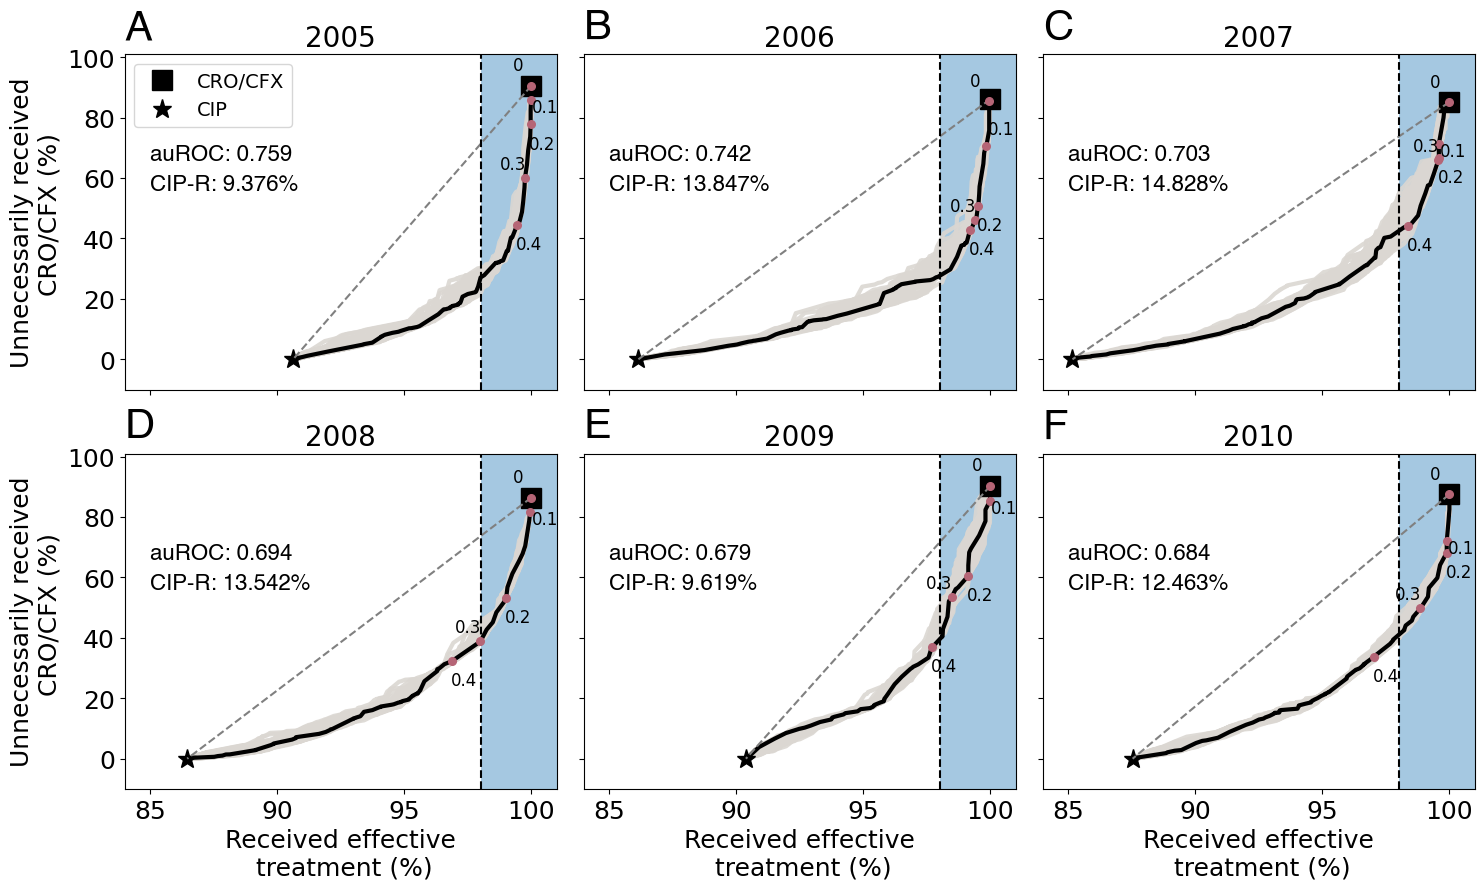

In [43]:
###### Effect of threshold on year-by-year for random forest model with bootstrap
from matplotlib.patches import Polygon
iterations = 100
fig, axs = plt.subplots(2,3, figsize=(15, 9), facecolor='w', edgecolor='k', sharex = 'all', sharey = 'all')
polygon_important0 = Polygon([(98,110), (110,110), (110,-10), (98,-10)], alpha = 0.4)
polygon_important1 = Polygon([(98,110), (110,110), (110,-10), (98,-10)], alpha = 0.4)
polygon_important2 = Polygon([(98,110), (110,110), (110,-10), (98,-10)], alpha = 0.4)
polygon_important3 = Polygon([(98,110), (110,110), (110,-10), (98,-10)], alpha = 0.4)
polygon_important4 = Polygon([(98,110), (110,110), (110,-10), (98,-10)], alpha = 0.4)
polygon_important5 = Polygon([(98,110), (110,110), (110,-10), (98,-10)], alpha = 0.4)

axs[0,0].tick_params(axis='both', which='major', labelsize=18)
axs[1,0].tick_params(axis='both', which='major', labelsize=18)
axs[1,1].tick_params(axis='both', which='major', labelsize=18)
axs[1,2].tick_params(axis='both', which='major', labelsize=18)

axs[0,0].set_ylabel("Unnecessarily received\n  CRO/CFX (%)", fontsize = 18)
axs[1,0].set_ylabel("Unnecessarily received\n  CRO/CFX (%)", fontsize = 18)
axs[1,0].set_xlabel("Received effective\n treatment (%)", fontsize = 18)
axs[1,1].set_xlabel("Received effective\n treatment (%)", fontsize = 18)
axs[1,2].set_xlabel("Received effective\n treatment (%)", fontsize = 18)

axs[0,0].set_yticks(np.linspace(0,100,6), labelsize=18,**hfont)
axs[1,0].set_yticks(np.linspace(0,100,6), fontsize=18,**hfont)
axs[1,0].set_xticks([85, 90, 95, 100], fontsize=18,**hfont)
axs[1,1].set_xticks([85, 90, 95, 100], fontsize=18,**hfont)
axs[1,2].set_xticks([85, 90, 95, 100], fontsize=18,**hfont)

axs[0,0].set_ylim([0-10,101])
axs[0,0].set_xlim([84, 101])

axs = axs.ravel()

cip_R_all_years = []
threshold_seq = np.linspace(0,1,1001)
unneccessary_treatment_98_efficacy_rf = []
i = 0
for year in years:
    model_type =1 
    years_train = np.array(range(year - 5, year))
    
    test_data, train_data, X_train, y_train, X_test, y_test, cipro_R_prev  =  get_test_train_data(CIP_data_no_drop = CIP_data_no_drop, year = year, feature_names = best_features_by_year_rf[year],years_train = years_train, model_type = 1)
    cip_R_all_years.append(cipro_R_prev)
    model_rf = RandomForestClassifier(n_estimators = best_hyperparameters_by_year_rf[year]['n_estimators'], min_samples_split = best_hyperparameters_by_year_rf[year]['min_samples_split'], min_samples_leaf=best_hyperparameters_by_year_rf[year]['min_samples_leaf'], max_features = 'sqrt', max_depth = best_hyperparameters_by_year_rf[year]['max_depth'], random_state = 10)
    
    ## fit model
    model_fit_train = model_rf.fit(X_train, y_train)
    y_predict_test = model_fit_train.predict(X_test)
    y_predict_proba = model_fit_train.predict_proba(X_test)
    
    #plot
    sensitivity_threshold, specificity_threshold, get_effective_threshold, incorrectly_get_X_threshold = effective_unnecessary_threshold(threshold_seq, y_predict_proba, y_test, cipro_R_prev)
    unneccessary_treatment_98_efficacy_rf.append(incorrectly_get_X_threshold[get_effective_threshold.index(min([x for x in get_effective_threshold if x >= 98]))] )

    for j in range(iterations):
        #sensitivity_threshold_sample, specificity_threshold_sample, get_effective_threshold_sample, incorrectly_get_X_threshold_sample = effective_unnecessary_bootstrap( model_rf, train_data, feature_names, test_data, y_test, cipro_R_prev)
        sensitivity_threshold_sample, specificity_threshold_sample, get_effective_threshold_sample, incorrectly_get_X_threshold_sample = effective_unnecessary_bootstrap_preloaded(test_data, y_test, cipro_R_prev, j)

        axs[i].plot(get_effective_threshold_sample, incorrectly_get_X_threshold_sample, color = "#DBD7D2", linewidth = 3, alpha=0.9)

    axs[i].plot(get_effective_threshold, incorrectly_get_X_threshold, color = "black", linewidth = 3)
    axs[i].plot(100, (1 - cipro_R_prev)*100, marker='s', ls='none', ms=14, color = "black", label = "CRO/CFX")
    axs[i].plot((1-cipro_R_prev)*100, 0, marker='*', ls='none', ms=14, color = "black", label = "CIP")
    axs[i].plot([100, (1-cipro_R_prev)*100], [(1-cipro_R_prev)*100, 0], color = "#808080", linestyle="--")
    axs[i].text(axs[i].get_xlim()[0] , axs[i].get_ylim()[1] + 5, labels[i], fontsize = 30, **hfont)
    axs[i].set_title(year,fontsize=20)  
    axs[i].text(axs[i].get_xlim()[0] + 1 , axs[i].get_ylim()[1] - 35, f'auROC: {round(ROC_by_year_rf[year], 3)}', fontsize = 16, **hfont)
    axs[i].text(axs[i].get_xlim()[0] + 1 , axs[i].get_ylim()[1] - 45, f'CIP-R: {round(cipro_R_prev*100, 3)}%', fontsize = 16, **hfont)
    axs[i].axvline(x = 98, color = 'black', linestyle="--")
    x = 0
    for index in indices:
        axs[i].plot(get_effective_threshold[index], incorrectly_get_X_threshold[index], marker='.', ls='none', ms=11, color = "#b56576")
        if index in (300, 500, 700, 900):
            if year == 2009 & index == 700:
                axs[i].text(get_effective_threshold[index] , incorrectly_get_X_threshold[index] + 3, text_for_graph[x], size = 12)
            else:
                axs[i].text(get_effective_threshold[index] - 1, incorrectly_get_X_threshold[index] + 3, text_for_graph[x], size = 12)
        elif index in (200, 400, 800, 1000):
            axs[i].text(get_effective_threshold[index] - 0.05, incorrectly_get_X_threshold[index] - 8, text_for_graph[x], size = 12)
        elif index == 600:
            axs[i].text(get_effective_threshold[index] - 0.25, incorrectly_get_X_threshold[index] - 7, text_for_graph[x], size = 12)
        elif index == 100:
            if year == 2006:
                axs[i].text(get_effective_threshold[index] + 0.075, incorrectly_get_X_threshold[index]  +4, text_for_graph[x], size = 12)
            else:
                axs[i].text(get_effective_threshold[index] + 0.05 , incorrectly_get_X_threshold[index] -4, text_for_graph[x], size = 12)
        elif index == 0:
            axs[i].text(get_effective_threshold[index] - 0.75, incorrectly_get_X_threshold[index] + 5, text_for_graph[x], size = 12)
        
        x = x+1
    i += 1

plt.tight_layout()

axs[0].legend(prop={'size':14})
axs[0].add_patch(polygon_important0)
axs[1].add_patch(polygon_important1)
axs[2].add_patch(polygon_important2)
axs[3].add_patch(polygon_important3)
axs[4].add_patch(polygon_important4)
axs[5].add_patch(polygon_important5)
plt.savefig('Graphs/Percent_effective_unnecessary_all_random_forest_2005_2010_bootstrap.png', dpi = 300)

Oversample


IndexError: list index out of range

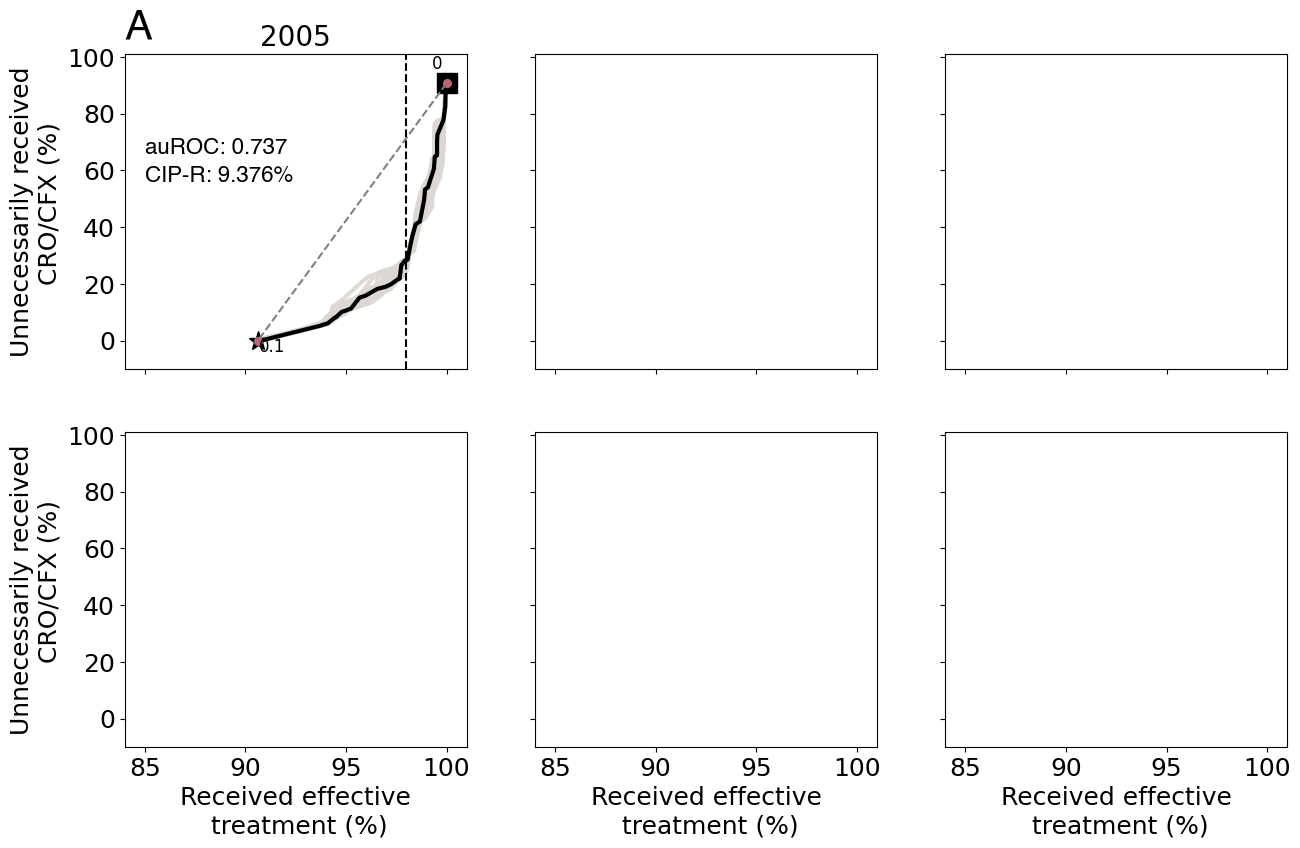

In [91]:
###### Effect of threshold on year-by-year for neural network
iterations = 50
fig, axs = plt.subplots(2,3, figsize=(15, 9), facecolor='w', edgecolor='k', sharex = 'all', sharey = 'all')
#text_for_graph = ['0', '0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8', '0.9', '1']
#indices = [0,10,20,30,40,50,60,70,80,90,100]
polygon_important0 = Polygon([(98,110), (110,110), (110,-10), (98,-10)], alpha = 0.4)
polygon_important1 = Polygon([(98,110), (110,110), (110,-10), (98,-10)], alpha = 0.4)
polygon_important2 = Polygon([(98,110), (110,110), (110,-10), (98,-10)], alpha = 0.4)
polygon_important3 = Polygon([(98,110), (110,110), (110,-10), (98,-10)], alpha = 0.4)
polygon_important4 = Polygon([(98,110), (110,110), (110,-10), (98,-10)], alpha = 0.4)
polygon_important5 = Polygon([(98,110), (110,110), (110,-10), (98,-10)], alpha = 0.4)

axs[0,0].tick_params(axis='both', which='major', labelsize=18)
axs[1,0].tick_params(axis='both', which='major', labelsize=18)
axs[1,1].tick_params(axis='both', which='major', labelsize=18)
axs[1,2].tick_params(axis='both', which='major', labelsize=18)

axs[0,0].set_ylabel("Unnecessarily received\n  CRO/CFX (%)", fontsize = 18)
axs[1,0].set_ylabel("Unnecessarily received\n  CRO/CFX (%)", fontsize = 18)
axs[1,0].set_xlabel("Received effective\n treatment (%)", fontsize = 18)
axs[1,1].set_xlabel("Received effective\n treatment (%)", fontsize = 18)
axs[1,2].set_xlabel("Received effective\n treatment (%)", fontsize = 18)

axs[0,0].set_yticks(np.linspace(0,100,6), labelsize=18,**hfont)
axs[1,0].set_yticks(np.linspace(0,100,6), fontsize=18,**hfont)
axs[1,0].set_xticks([85, 90, 95, 100], fontsize=18,**hfont)
axs[1,1].set_xticks([85, 90, 95, 100], fontsize=18,**hfont)
axs[1,2].set_xticks([85, 90, 95, 100], fontsize=18,**hfont)

axs[0,0].set_ylim([0-10,101])
axs[0,0].set_xlim([84, 101])

axs = axs.ravel()
threshold_seq = np.linspace(0,1,101)
unneccessary_treatment_98_efficacy_nn = []
unnecessary_treatment_98_efficacy_nn_line = []
years = [2005, 2006, 2007, 2008, 2009, 2010]
i = 0
for year in years:
    model_type = 2
    years_train = np.array(range(year - 5, year))
    
    model_nn = MLPClassifier(solver = best_hyperparameters_by_year_nn[year]['solver'], activation = best_hyperparameters_by_year_nn[year]['activation'], max_iter = 3000 ,hidden_layer_sizes= best_hyperparameters_by_year_nn[year]['hidden_layer_sizes'], alpha =  best_hyperparameters_by_year_nn[year]['alpha'], random_state=10, learning_rate = best_hyperparameters_by_year_nn[year]['learning_rate'] )

    test_data, train_data, X_train, y_train, X_test, y_test, cipro_R_prev  =  get_test_train_data(CIP_data_no_drop = CIP_data_no_drop, year = year, feature_names = best_features_by_year_nn[year],years_train = years_train, model_type = 2)
   
    ## fit model
    #model_fit_train = model_nn.fit(X_train, y_train)
    model_name = "CIP_nn_" + str(year) + ".sav" 
    model_fit_train = pickle.load(open(model_name, 'rb'))
    y_predict_test = model_fit_train.predict(X_test)
    y_predict_proba = model_fit_train.predict_proba(X_test)

    ## get sesnitivity and specificity
    sensitivity_threshold, specificity_threshold, get_effective_threshold, incorrectly_get_X_threshold = effective_unnecessary_threshold(threshold_seq, y_predict_proba, y_test, cipro_R_prev)
    #unneccessary_treatment_98_efficacy_nn.append(incorrectly_get_X_threshold[get_effective_threshold.index(min([x for x in get_effective_threshold if x >= 98]))] )
    #plot
    for j in range(iterations):
        #sensitivity_threshold_sample, specificity_threshold_sample, get_effective_threshold_sample, incorrectly_get_X_threshold_sample = effective_unnecessary_bootstrap( model_nn, train_data, test_data)
        sensitivity_threshold_sample, specificity_threshold_sample, get_effective_threshold_sample, incorrectly_get_X_threshold_sample = effective_unnecessary_bootstrap_preloaded(test_data, y_test, cipro_R_prev, j)
        axs[i].plot(get_effective_threshold_sample, incorrectly_get_X_threshold_sample, color = "#DBD7D2", linewidth = 3, alpha=0.9)
    unneccessary_treatment_98_efficacy_nn.append(incorrectly_get_X_threshold[get_effective_threshold.index(min([x for x in get_effective_threshold if x >= 98]))] )
    unnecessary_treatment_98_efficacy_nn_line.append(((1-cipro_R_prev)/cipro_R_prev)  * (0.98 + cipro_R_prev  - 1))
    axs[i].plot(get_effective_threshold, incorrectly_get_X_threshold, color = "black", linewidth = 3)
    axs[i].plot(100, (1 - cipro_R_prev)*100, marker='s', ls='none', ms=14, color = "black", label = "CRO/CFX")
    axs[i].plot((1-cipro_R_prev)*100, 0, marker='*', ls='none', ms=14, color = "black", label = "CIP")
    axs[i].plot([100, (1-cipro_R_prev)*100], [(1-cipro_R_prev)*100, 0], color = "#808080", linestyle="--")
    axs[i].text(axs[i].get_xlim()[0] , axs[i].get_ylim()[1] + 5, labels[i], fontsize = 30, **hfont)
    axs[i].set_title(year,fontsize=20)  
    axs[i].text(axs[i].get_xlim()[0] + 1 , axs[i].get_ylim()[1] - 35, f'auROC: {round(ROC_by_year_nn[year], 3)}', fontsize = 16, **hfont)
    axs[i].text(axs[i].get_xlim()[0] + 1 , axs[i].get_ylim()[1] - 45, f'CIP-R: {round(cipro_R_prev*100, 3)}%', fontsize = 16, **hfont)
    axs[i].axvline(x = 98, color = 'black', linestyle="--")
    x = 0
    for index in indices:
        axs[i].plot(get_effective_threshold[index], incorrectly_get_X_threshold[index], marker='.', ls='none', ms=11, color = "#b56576")
        if index in (300, 500, 700, 900):
            if year == 2009 & index == 700:
                axs[i].text(get_effective_threshold[index] , incorrectly_get_X_threshold[index] + 3, text_for_graph[x], size = 12)
            else:
                axs[i].text(get_effective_threshold[index] - 1, incorrectly_get_X_threshold[index] + 3, text_for_graph[x], size = 12)
        elif index in (200, 800, 1000):
            axs[i].text(get_effective_threshold[index] - 0.05, incorrectly_get_X_threshold[index] - 8, text_for_graph[x], size = 12)
        elif index == 400:
            if year == 2010:
                axs[i].text(get_effective_threshold[index] +0.3, incorrectly_get_X_threshold[index] - 5, text_for_graph[x], size = 12)

            else:
                axs[i].text(get_effective_threshold[index] , incorrectly_get_X_threshold[index] - 5, text_for_graph[x], size = 12)
        elif index == 100:
            if year == 2006:
                axs[i].text(get_effective_threshold[index] + 0.075, incorrectly_get_X_threshold[index]  +4, text_for_graph[x], size = 12)
            elif year == 2007:
                axs[i].text(get_effective_threshold[index] + 0.075, incorrectly_get_X_threshold[index]  -7, text_for_graph[x], size = 12)
            else:
                axs[i].text(get_effective_threshold[index] + 0.05 , incorrectly_get_X_threshold[index] -4, text_for_graph[x], size = 12)
        elif index == 0:
            axs[i].text(get_effective_threshold[index] - 0.75, incorrectly_get_X_threshold[index] + 5, text_for_graph[x], size = 12)
        
        x = x+1
    i += 1

plt.tight_layout()
axs[0].legend(prop={'size':14})
axs[0].add_patch(polygon_important0)
axs[1].add_patch(polygon_important1)
axs[2].add_patch(polygon_important2)
axs[3].add_patch(polygon_important3)
axs[4].add_patch(polygon_important4)
axs[5].add_patch(polygon_important5)
#plt.savefig('Graphs/Percent_effective_unnecessary_all_neural_network_2005_2010_bootstrap.png', dpi = 300)

In [39]:
CIP_prevalence_by_year = [9.376, 13.847, 14.828, 13.542, 9.619, 12.463]

In [86]:
np.mean(unnecessary_treatment_98_efficacy_nn_line)

0.7290894532356235

In [87]:
unnecessary_treatment_98_efficacy_nn_line

[0.7129230983733448,
 0.7370943442401912,
 0.7368402614932817,
 0.7368911906117369,
 0.715893845494487,
 0.7348939792006994]

In [88]:
(0.7129230983733448 - 28.255607552041315) + (0.7370943442401912 - 31.307490144546648) + (0.7368402614932817 - 42.66932933932434) + (0.7368911906117369 - 40.83522627992311) + (0.715893845494487 - 45.608108108108105) + (0.7348939792006994 - 43.54016523114783)

-227.84138993567763

In [89]:
-227.84138993567763/6

-37.9735649892796

In [46]:
unneccessary_treatment_98_efficacy_nn

[28.255607552041315,
 31.307490144546648,
 42.66932933932434,
 40.83522627992311,
 45.608108108108105,
 43.54016523114783]

In [55]:
def decrease_in_unnecessary(years, prevalences, unneccessary_treatment_98_efficacy):
    reduction = []
    for year in range(len(years)):
        unnecessary_line = ((100-prevalences[year])/prevalences[year])  * (98 + prevalences[year]  - 100)
        reduction.append(unnecessary_line - unneccessary_treatment_98_efficacy[year])
    return np.mean(reduction)

In [90]:
print(decrease_in_unnecessary(test_years, CIP_prevalence_by_year, unneccessary_treatment_98_efficacy_nn))
print(decrease_in_unnecessary(test_years, CIP_prevalence_by_year, unneccessary_treatment_98_efficacy_lr))
print(decrease_in_unnecessary(test_years, CIP_prevalence_by_year, unneccessary_treatment_98_efficacy_rf))


34.20631798151225
34.1623868833562
35.258705917775735


Oversample
Oversample
Oversample
Oversample
Oversample
Oversample


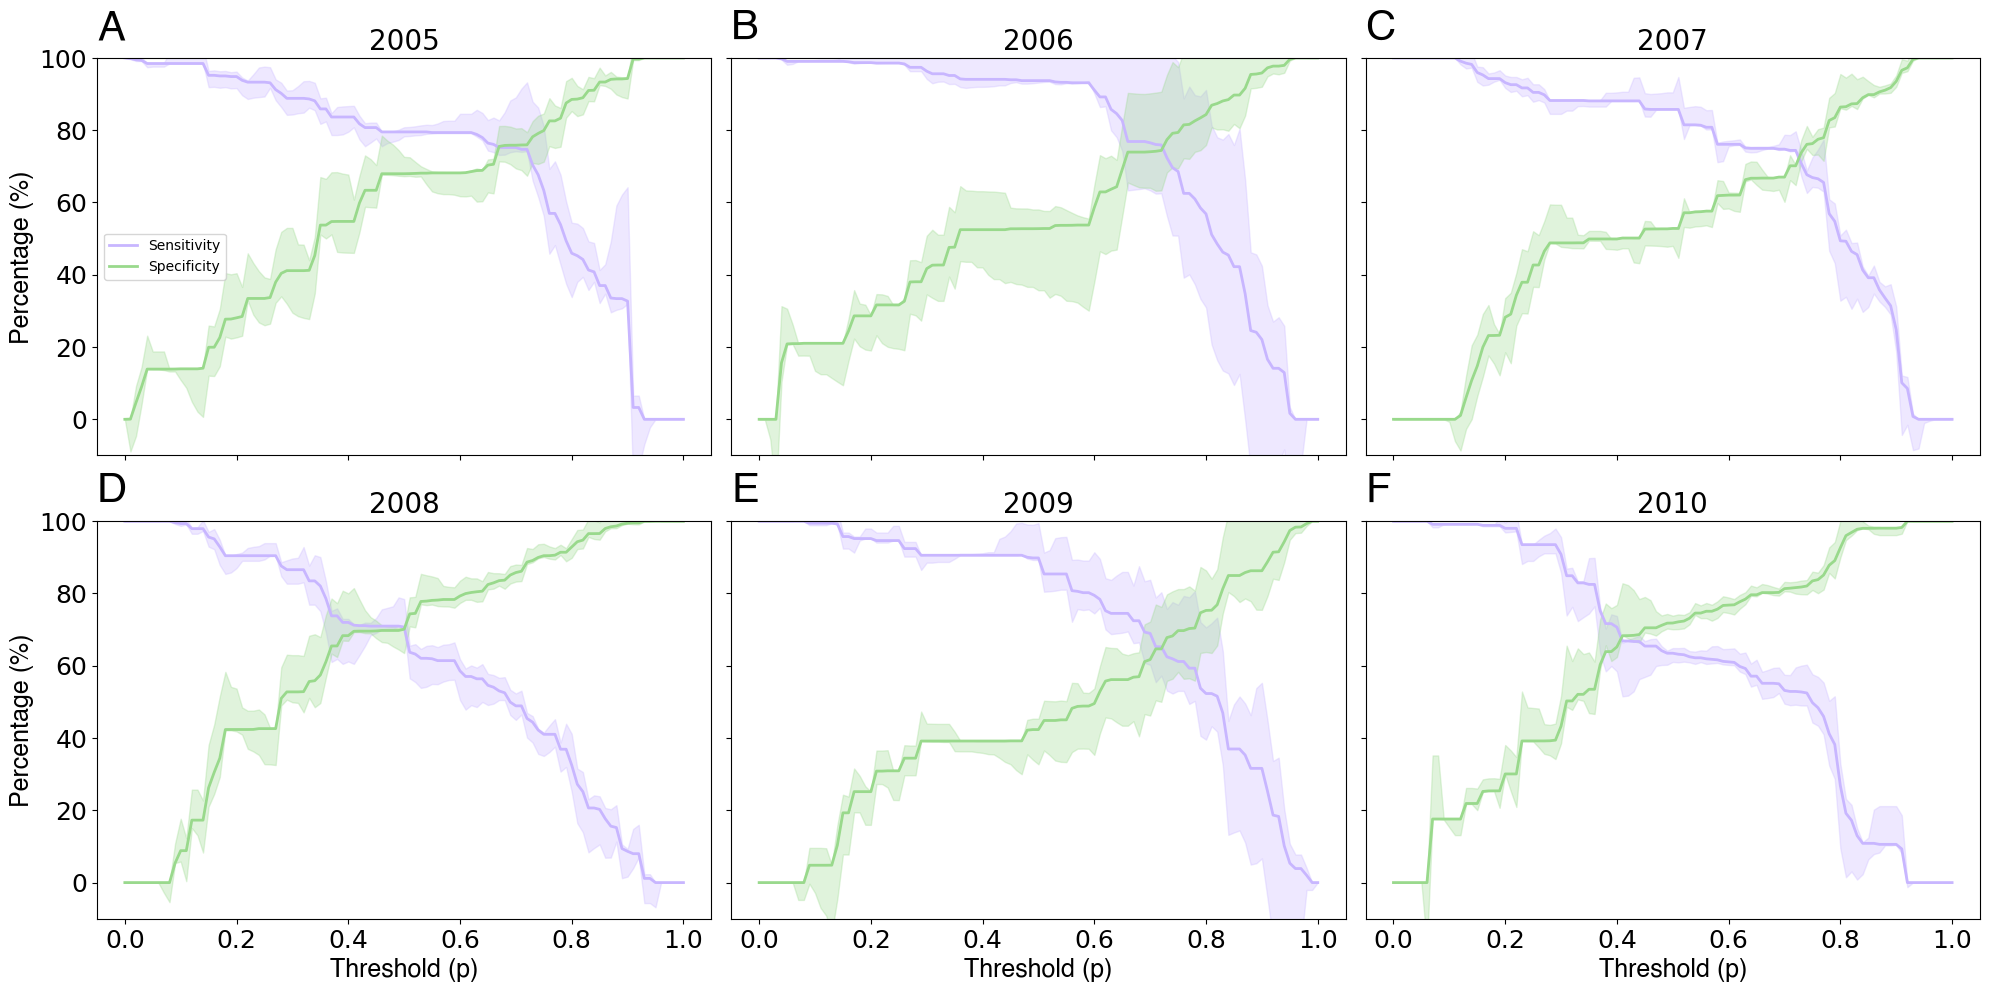

In [9]:
### NN Bootstrap sensitivity and specificity 
fig, axs = plt.subplots(2,3, figsize=(20, 10), facecolor='w', edgecolor='k', sharex = 'all', sharey = 'all')
labels = ["A", "B", "C", "D", "E", "F" ]
years = [2005, 2006, 2007, 2008, 2009, 2010]
axs[0,0].set_ylabel('Percentage (%)', fontsize=18,**hfont)
axs[1,0].set_ylabel('Percentage (%)', fontsize=18,**hfont)
axs[1,0].set_xlabel('Threshold (p)', fontsize=18,**hfont)
axs[1,1].set_xlabel('Threshold (p)', fontsize=18,**hfont)
axs[1,2].set_xlabel('Threshold (p)', fontsize=18,**hfont)

axs[0,0].set_yticks(np.linspace(0,100,6), fontsize=18,**hfont)
axs[1,0].set_yticks(np.linspace(0,100,6), fontsize=18,**hfont)
axs[1,0].set_xticks(np.linspace(0,1,6), fontsize=18,**hfont)
axs[1,1].set_xticks(np.linspace(0,1,6), fontsize=18,**hfont)
axs[1,2].set_xticks(np.linspace(0,1,6), fontsize=18,**hfont)

axs[0,0].set_ylim(-10, 100)
axs[0,1].set_ylim(-10, 100)
axs[0,2].set_ylim(-10, 100)
axs[1,0].set_ylim(-10, 100)
axs[1,1].set_ylim(-10, 100)
axs[1,2].set_ylim(-10, 100)
axs[0,0].tick_params(axis='both', which='major', labelsize=18)
axs[1,0].tick_params(axis='both', which='major', labelsize=18)
axs[1,1].tick_params(axis='both', which='major', labelsize=18)
axs[1,2].tick_params(axis='both', which='major', labelsize=18)
axs = axs.ravel()

threshold_seq = np.linspace(0,1,101)
years = [2005, 2006, 2007, 2008, 2009, 2010]
i = 0
for year in years:
    model_type = 2
    years_train = np.array(range(year - 5, year))
    important_features = best_features_by_year_nn[year]
    test_data, train_data, X_train, y_train, X_test, y_test, cipro_R_prev  =  get_test_train_data(CIP_data_no_drop = CIP_data_no_drop, year = year, feature_names = best_features_by_year_nn[year],years_train = years_train, model_type = 1)

    model_nn = MLPClassifier(solver = best_hyperparameters_by_year_nn[year]['solver'], activation = best_hyperparameters_by_year_nn[year]['activation'], max_iter = 3000 ,hidden_layer_sizes= best_hyperparameters_by_year_nn[year]['hidden_layer_sizes'], alpha =  best_hyperparameters_by_year_nn[year]['alpha'], random_state=10, learning_rate = best_hyperparameters_by_year_nn[year]['learning_rate'] )
    
    ## fit model
    model_fit_train = model_nn.fit(X_train, y_train)
    y_predict_test = model_fit_train.predict(X_test)
    y_predict_proba = model_fit_train.predict_proba(X_test)
    
    ## get sesnitivity and specificity
    sensitivity_threshold, specificity_threshold, get_effective_threshold, incorrectly_get_X_threshold = effective_unnecessary_threshold(threshold_seq, y_predict_proba, y_test, cipro_R_prev)
    lower_quartile_specificity, upper_quartile_specificity,lower_quartile_sensitivity,upper_quartile_sensitivity = bootstrap_sensitivity_specificity_preloaded(iterations,  y_test, sensitivity_threshold, specificity_threshold)
    #sensitivity_lower_CI = np.subtract(sensitivity_threshold,lower_quartile_sensitivity)
    #sensitivity_upper_CI = np.subtract(sensitivity_threshold,upper_quartile_sensitivity)
    #specificity_lower_CI = np.subtract(specificity_threshold,lower_quartile_specificity)
    #specificity_upper_CI = np.subtract(specificity_threshold,upper_quartile_specificity)

    #plot
    axs[i].plot(threshold_seq, sensitivity_threshold, color = "#c8b6ff", label = r"Sensitivity", linewidth = 2)
    axs[i].fill_between(threshold_seq, lower_quartile_sensitivity, upper_quartile_sensitivity, color = "#c8b6ff", alpha = 0.3)

    axs[i].plot(threshold_seq, specificity_threshold, color = "#99d98c", label = r"Specificity", linewidth = 2)
    axs[i].fill_between(threshold_seq, lower_quartile_specificity, upper_quartile_specificity, color = "#99d98c", alpha = 0.3)
    axs[i].set_title(year,fontsize=20)

    axs[i].text(axs[i].get_xlim()[0] , axs[i].get_ylim()[1] + 5, labels[i], fontsize = 30, **hfont)
    i += 1
axs[0].legend()
plt.tight_layout()

plt.savefig("Graphs/Sensitivity_specificity_all_workflow_paper_neural_network_2005_2010_bootstrap.png", dpi = 300)


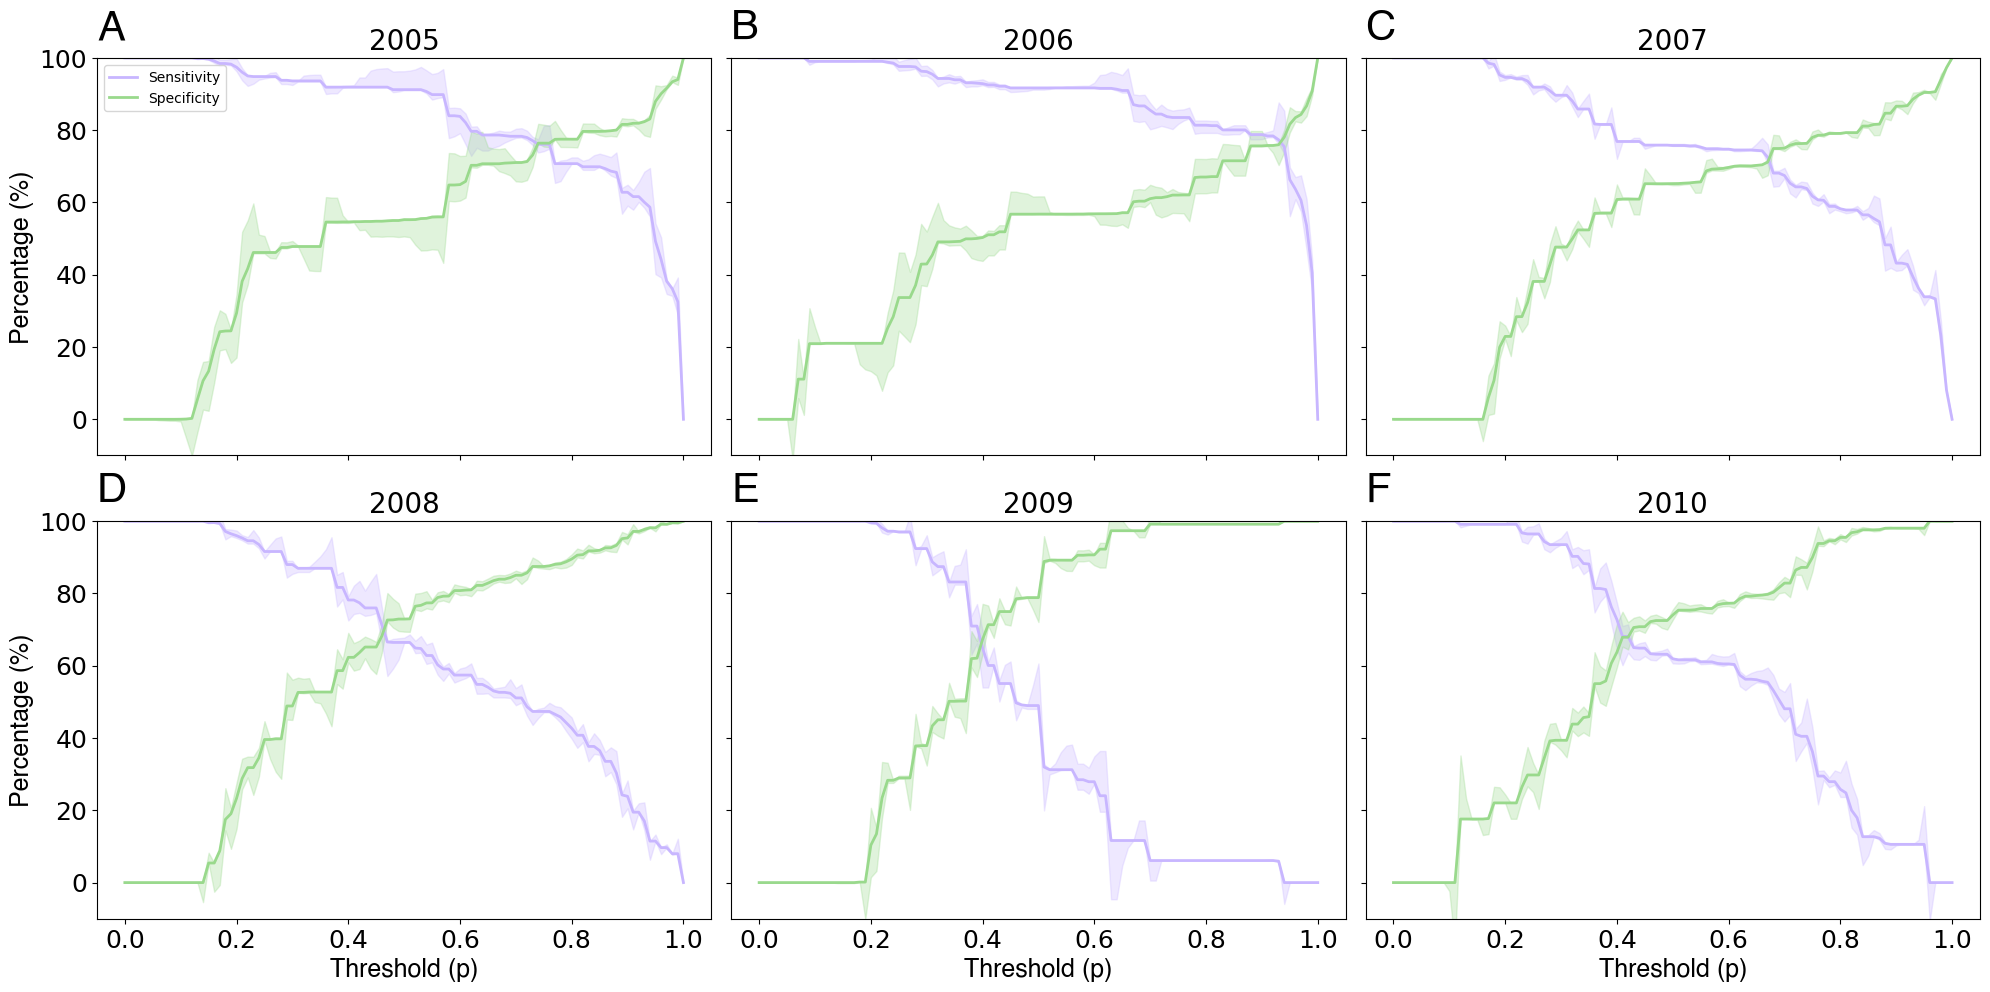

In [11]:
### LR Bootstrap sensitivity and specificity 
fig, axs = plt.subplots(2,3, figsize=(20, 10), facecolor='w', edgecolor='k', sharex = 'all', sharey = 'all')
labels = ["A", "B", "C", "D", "E", "F" ]
years = [2005, 2006, 2007, 2008, 2009, 2010]
axs[0,0].set_ylabel('Percentage (%)', fontsize=18,**hfont)
axs[1,0].set_ylabel('Percentage (%)', fontsize=18,**hfont)
axs[1,0].set_xlabel('Threshold (p)', fontsize=18,**hfont)
axs[1,1].set_xlabel('Threshold (p)', fontsize=18,**hfont)
axs[1,2].set_xlabel('Threshold (p)', fontsize=18,**hfont)

axs[0,0].set_yticks(np.linspace(0,100,6), fontsize=18,**hfont)
axs[1,0].set_yticks(np.linspace(0,100,6), fontsize=18,**hfont)
axs[1,0].set_xticks(np.linspace(0,1,6), fontsize=18,**hfont)
axs[1,1].set_xticks(np.linspace(0,1,6), fontsize=18,**hfont)
axs[1,2].set_xticks(np.linspace(0,1,6), fontsize=18,**hfont)
axs[0,0].set_ylim(-10, 100)
axs[0,1].set_ylim(-10, 100)
axs[0,2].set_ylim(-10, 100)
axs[1,0].set_ylim(-10, 100)
axs[1,1].set_ylim(-10, 100)
axs[1,2].set_ylim(-10, 100)
axs[0,0].tick_params(axis='both', which='major', labelsize=18)
axs[1,0].tick_params(axis='both', which='major', labelsize=18)
axs[1,1].tick_params(axis='both', which='major', labelsize=18)
axs[1,2].tick_params(axis='both', which='major', labelsize=18)
axs = axs.ravel()

threshold_seq = np.linspace(0,1,101)
years = [2005, 2006, 2007, 2008, 2009, 2010]

i = 0
for year in years:
    model_type = 0
    years_train = np.array(range(year - 5, year))
    important_features = best_features_by_year_lr[year]
    test_data, train_data, X_train, y_train, X_test, y_test, cipro_R_prev  =  get_test_train_data(CIP_data_no_drop = CIP_data_no_drop, year = year, feature_names = best_features_by_year_lr[year],years_train = years_train, model_type = 0)

    model_lr = LogisticRegression(class_weight = 'balanced', max_iter=4000, solver = best_hyperparameters_by_year_lr[year]['solver'], C = best_hyperparameters_by_year_lr[year]['C'], penalty = best_hyperparameters_by_year_lr[year]['penalty'])
    
    ## fit model
    model_fit_train = model_lr.fit(X_train, y_train)
    y_predict_test = model_fit_train.predict(X_test)
    y_predict_proba = model_fit_train.predict_proba(X_test)
    
    ## get sesnitivity and specificity
    sensitivity_threshold, specificity_threshold, get_effective_threshold, incorrectly_get_X_threshold = effective_unnecessary_threshold(threshold_seq, y_predict_proba, y_test, cipro_R_prev)
    lower_quartile_specificity, upper_quartile_specificity,lower_quartile_sensitivity,upper_quartile_sensitivity = bootstrap_sensitivity_specificity_preloaded(iterations,  y_test, sensitivity_threshold, specificity_threshold)
    #sensitivity_lower_CI = np.subtract(sensitivity_threshold,lower_quartile_sensitivity)
    #sensitivity_upper_CI = np.subtract(sensitivity_threshold,upper_quartile_sensitivity)
    #specificity_lower_CI = np.subtract(specificity_threshold,lower_quartile_specificity)
    #specificity_upper_CI = np.subtract(specificity_threshold,upper_quartile_specificity)

    #plot
    axs[i].plot(threshold_seq, sensitivity_threshold, color = "#c8b6ff", label = r"Sensitivity", linewidth = 2)
    axs[i].fill_between(threshold_seq, lower_quartile_sensitivity, upper_quartile_sensitivity, color = "#c8b6ff", alpha = 0.3)

    axs[i].plot(threshold_seq, specificity_threshold, color = "#99d98c", label = r"Specificity", linewidth = 2)
    axs[i].fill_between(threshold_seq, lower_quartile_specificity, upper_quartile_specificity, color = "#99d98c", alpha = 0.3)
    axs[i].set_title(year,fontsize=20)

    axs[i].text(axs[i].get_xlim()[0] , axs[i].get_ylim()[1] + 5, labels[i], fontsize = 30, **hfont)
    i += 1
axs[0].legend()
plt.tight_layout()

plt.savefig("Graphs/Sensitivity_specificity_all_workflow_paper_logistic_regression_2005_2010_bootstrap.png", dpi = 300)

Oversample
Oversample
Oversample
Oversample
Oversample
Oversample


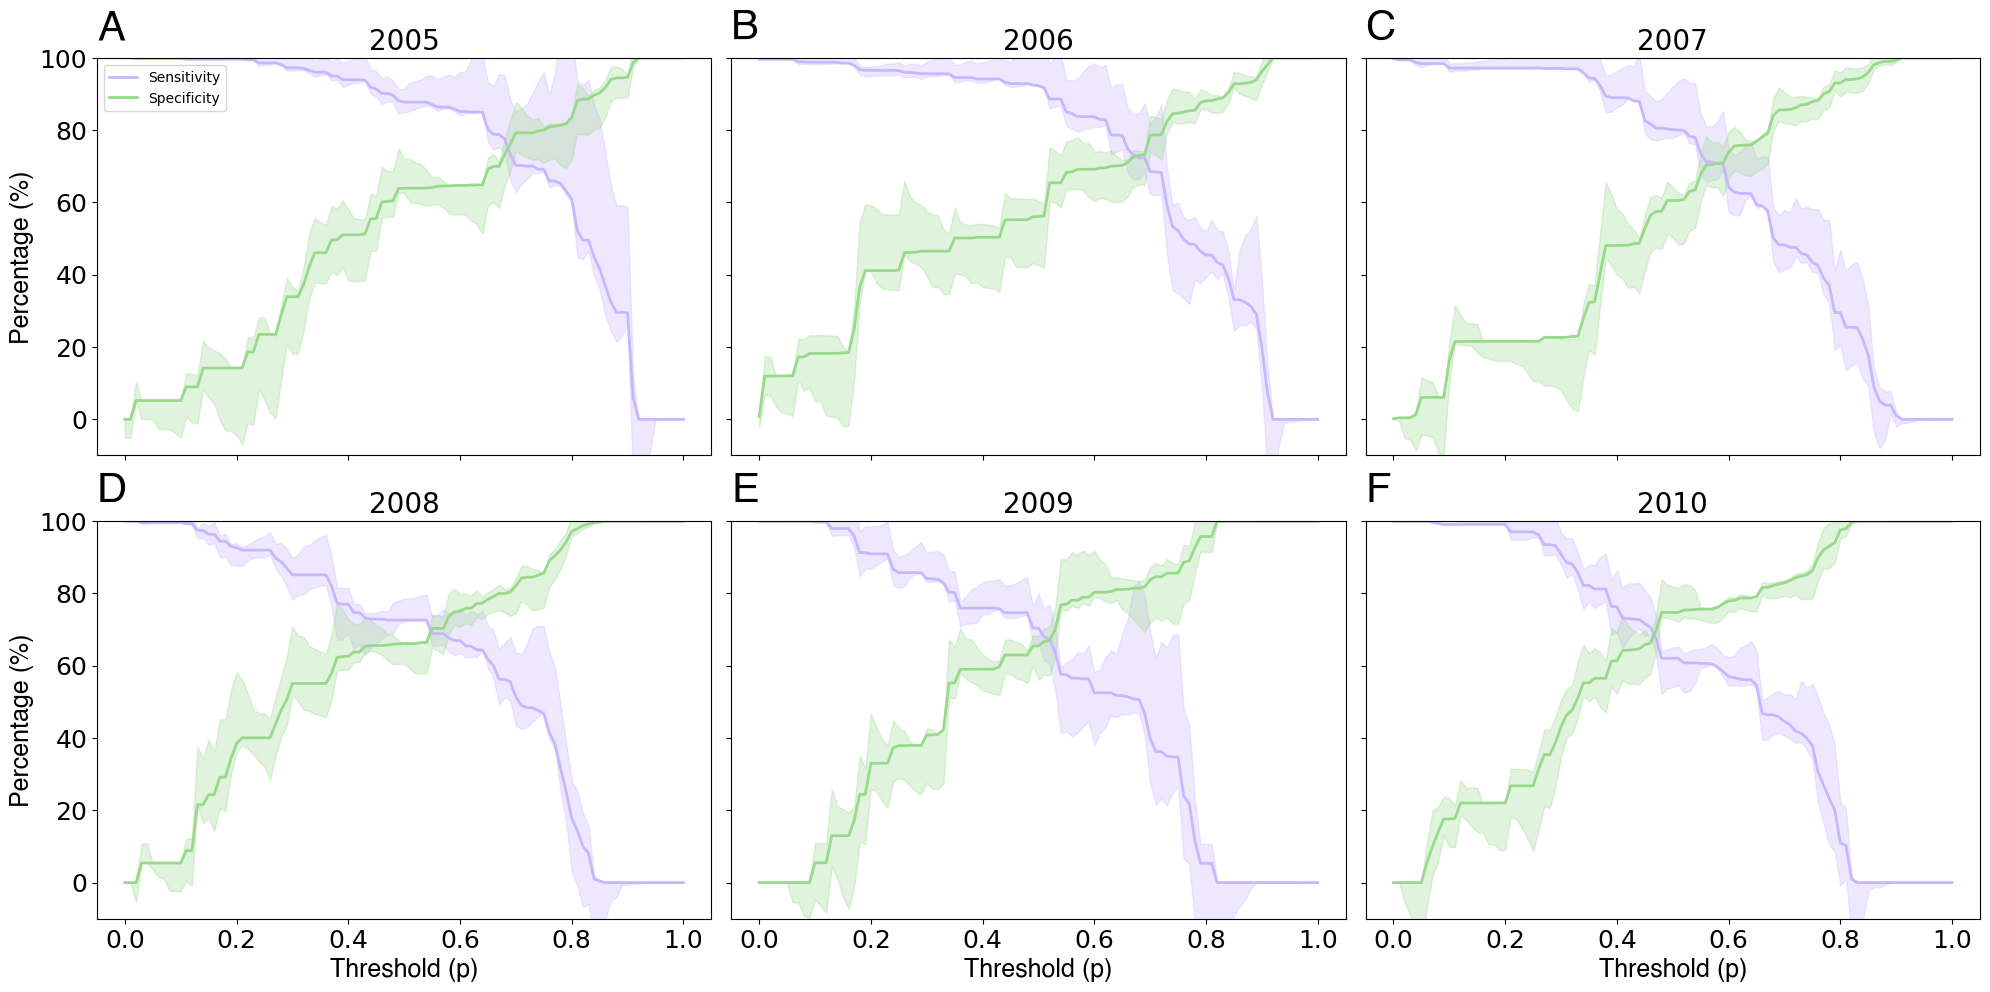

In [12]:
### RF Bootstrap sensitivity and specificity 
fig, axs = plt.subplots(2,3, figsize=(20, 10), facecolor='w', edgecolor='k', sharex = 'all', sharey = 'all')
labels = ["A", "B", "C", "D", "E", "F" ]
years = [2005, 2006, 2007, 2008, 2009, 2010]
axs[0,0].set_ylabel('Percentage (%)', fontsize=18,**hfont)
axs[1,0].set_ylabel('Percentage (%)', fontsize=18,**hfont)
axs[1,0].set_xlabel('Threshold (p)', fontsize=18,**hfont)
axs[1,1].set_xlabel('Threshold (p)', fontsize=18,**hfont)
axs[1,2].set_xlabel('Threshold (p)', fontsize=18,**hfont)

axs[0,0].set_yticks(np.linspace(0,100,6), fontsize=18,**hfont)
axs[1,0].set_yticks(np.linspace(0,100,6), fontsize=18,**hfont)
axs[1,0].set_xticks(np.linspace(0,1,6), fontsize=18,**hfont)
axs[1,1].set_xticks(np.linspace(0,1,6), fontsize=18,**hfont)
axs[1,2].set_xticks(np.linspace(0,1,6), fontsize=18,**hfont)

axs[0,0].tick_params(axis='both', which='major', labelsize=18)
axs[1,0].tick_params(axis='both', which='major', labelsize=18)
axs[1,1].tick_params(axis='both', which='major', labelsize=18)
axs[1,2].tick_params(axis='both', which='major', labelsize=18)
axs[0,0].set_ylim(-10, 100)
axs[0,1].set_ylim(-10, 100)
axs[0,2].set_ylim(-10, 100)
axs[1,0].set_ylim(-10, 100)
axs[1,1].set_ylim(-10, 100)
axs[1,2].set_ylim(-10, 100)
axs = axs.ravel()

threshold_seq = np.linspace(0,1,101)
years = [2005, 2006, 2007, 2008, 2009, 2010]
i = 0
for year in years:
    model_type = 1
    years_train = np.array(range(year - 5, year))
    
    test_data, train_data, X_train, y_train, X_test, y_test, cipro_R_prev  =  get_test_train_data(CIP_data_no_drop = CIP_data_no_drop, year = year, feature_names = best_features_by_year_rf[year],years_train = years_train, model_type = 1)

    model_rf = RandomForestClassifier(n_estimators = best_hyperparameters_by_year_rf[year]['n_estimators'], min_samples_split = best_hyperparameters_by_year_rf[year]['min_samples_split'], min_samples_leaf=best_hyperparameters_by_year_rf[year]['min_samples_leaf'], max_features = 'sqrt', max_depth = best_hyperparameters_by_year_rf[year]['max_depth'], random_state = 10)
    
    ## fit model
    model_fit_train = model_rf.fit(X_train, y_train)
    y_predict_test = model_fit_train.predict(X_test)
    y_predict_proba = model_fit_train.predict_proba(X_test)
    
    ## get sesnitivity and specificity
    sensitivity_threshold, specificity_threshold, get_effective_threshold, incorrectly_get_X_threshold = effective_unnecessary_threshold(threshold_seq, y_predict_proba, y_test, cipro_R_prev)
    lower_quartile_specificity, upper_quartile_specificity,lower_quartile_sensitivity,upper_quartile_sensitivity = bootstrap_sensitivity_specificity_preloaded(iterations,  y_test, sensitivity_threshold, specificity_threshold)
    #sensitivity_lower_CI = np.subtract(sensitivity_threshold,lower_quartile_sensitivity)
    #sensitivity_upper_CI = np.subtract(sensitivity_threshold,upper_quartile_sensitivity)
    #specificity_lower_CI = np.subtract(specificity_threshold,lower_quartile_specificity)
    #specificity_upper_CI = np.subtract(specificity_threshold,upper_quartile_specificity)

    #plot
    axs[i].plot(threshold_seq, sensitivity_threshold, color = "#c8b6ff", label = r"Sensitivity", linewidth = 2)
    axs[i].fill_between(threshold_seq, lower_quartile_sensitivity, upper_quartile_sensitivity, color = "#c8b6ff", alpha = 0.3)

    axs[i].plot(threshold_seq, specificity_threshold, color = "#99d98c", label = r"Specificity", linewidth = 2)
    axs[i].fill_between(threshold_seq, lower_quartile_specificity, upper_quartile_specificity, color = "#99d98c", alpha = 0.3)
    axs[i].set_title(year,fontsize=20)

    axs[i].text(axs[i].get_xlim()[0] , axs[i].get_ylim()[1] + 5, labels[i], fontsize = 30, **hfont)
    i += 1
axs[0].legend()
plt.tight_layout()

plt.savefig("Graphs/Sensitivity_specificity_all_workflow_paper_random_forest_2005_2010_bootstrap.png", dpi = 300)

In [150]:
year = 2009
model_type = 2
years_train = np.array(range(year - 5, year))
    
test_data, train_data, X_train, y_train, X_test, y_test, cipro_R_prev  =  get_test_train_data(CIP_data_no_drop = CIP_data_no_drop, year = year, feature_names = best_features_by_year_nn[year],years_train = years_train, model_type = 1)

model_nn = MLPClassifier(solver = best_hyperparameters_by_year_nn[year]['solver'], activation = best_hyperparameters_by_year_nn[year]['activation'], max_iter = 3000 ,hidden_layer_sizes= best_hyperparameters_by_year_nn[year]['hidden_layer_sizes'], alpha =  best_hyperparameters_by_year_nn[year]['alpha'], random_state=10, learning_rate = best_hyperparameters_by_year_nn[year]['learning_rate'] )
    
    ## fit model
model_fit_train = model_nn.fit(X_train, y_train)
y_predict_test = model_fit_train.predict(X_test)
y_predict_proba = model_fit_train.predict_proba(X_test)
    
    ## get sesnitivity and specificity
sensitivity_threshold, specificity_threshold, get_effective_threshold, incorrectly_get_X_threshold = effective_unnecessary_threshold(threshold_seq, y_predict_proba, y_test, cipro_R_prev)
 

for threshold in threshold_seq:
      bootstrapped_stats = []

      for j in range(iterations):
            model_name = "CIP_bootstrap_" + str(model_type) + "_" + str(year) + "_" + str(j) + ".sav" 
            X_data_name = "CIP_bootstrap_X_" + str(model_type) + "_" + str(year) + "_" + str(j) + ".csv" 
            X_train_bootstrap = pd.read_csv(X_data_name)
            model_fit = pickle.load(open(model_name, 'rb'))
            X_test_for_bootstrap = test_data[X_train_bootstrap.columns[1:len(X_train_bootstrap.columns)]]
            #y_sample_predict = model_fit.predict(X_test)
            y_bootstrap_predict_prob = model_fit.predict_proba(X_test_for_bootstrap) #predicting it on the real data

            y_bootstrap_predict = np.where(y_bootstrap_predict_prob[:, 1] > threshold, 1, 0)

            tn_test, fp_test, fn_test, tp_test = confusion_matrix(y_true=y_test, y_pred=y_bootstrap_predict).ravel()

            sensitivity_test = (tp_test / (tp_test + fn_test))*100
            specificity_test = (tn_test / (tn_test + fp_test))*100

          ###  Calculate estimate 
            difference_sensitivity = sensitivity_test - sensitivity_threshold[np.where(threshold_seq ==threshold)[0][0]] ## according to https://ocw.mit.edu/courses/18-05-introduction-to-probability-and-statistics-spring-2014/resources/mit18_05s14_reading24/
            difference_specificity = specificity_test - specificity_threshold[np.where(threshold_seq ==threshold)[0][0]]  ## according to https://ocw.mit.edu/courses/18-05-introduction-to-probability-and-statistics-spring-2014/resources/mit18_05s14_reading24/

            bootstrapped_stats.append(
            {

                'Difference_specificity': difference_specificity, 
                'Difference_sensitivity': difference_sensitivity#,
            }
          )


      bootstrapped_stats = pd.DataFrame(bootstrapped_stats)

      lower_quartile_specificity.append(np.percentile(bootstrapped_stats["Difference_specificity"], 2.5))
      upper_quartile_specificity.append(np.percentile(bootstrapped_stats["Difference_specificity"], 97.5))
      lower_quartile_sensitivity.append(np.percentile(bootstrapped_stats["Difference_sensitivity"], 2.5))
      upper_quartile_sensitivity.append(np.percentile(bootstrapped_stats["Difference_sensitivity"], 97.5))
 ## Step 4: Get optimization-corrected performance




Oversample


Oversample


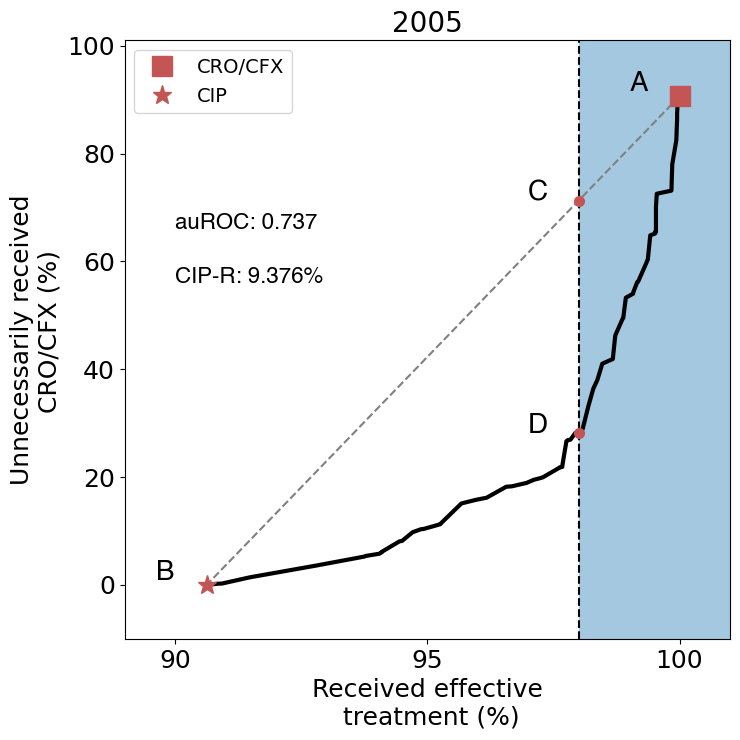

In [92]:
### Make sample graph showing the calculation being done 

###### Effect of threshold on year-by-year for neural network
fig, axs = plt.subplots(figsize=(7.5, 7.5), facecolor='w', edgecolor='k', sharex = 'all', sharey = 'all')
#text_for_graph = ['0', '0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8', '0.9', '1']
#indices = [0,10,20,30,40,50,60,70,80,90,100]
polygon_important0 = Polygon([(98,110), (110,110), (110,-10), (98,-10)], alpha = 0.4)

axs.tick_params(axis='both', which='major', labelsize=18)

axs.set_ylabel("Unnecessarily received\n  CRO/CFX (%)", fontsize = 18)
axs.set_xlabel("Received effective\n treatment (%)", fontsize = 18)

axs.set_yticks(np.linspace(0,100,6), labelsize=18,**hfont)
axs.set_xticks([85, 90, 95, 100], fontsize=18,**hfont)

axs.set_ylim([0-10,101])
axs.set_xlim([89, 101])

threshold_seq = np.linspace(0,1,1001)
unneccessary_treatment_98_efficacy_nn = []
years = [2005]
i = 0
for year in years:
    model_type = 2
    years_train = np.array(range(year - 5, year))
    
    model_nn = MLPClassifier(solver = best_hyperparameters_by_year_nn[year]['solver'], activation = best_hyperparameters_by_year_nn[year]['activation'], max_iter = 3000 ,hidden_layer_sizes= best_hyperparameters_by_year_nn[year]['hidden_layer_sizes'], alpha =  best_hyperparameters_by_year_nn[year]['alpha'], random_state=10, learning_rate = best_hyperparameters_by_year_nn[year]['learning_rate'] )

    test_data, train_data, X_train, y_train, X_test, y_test, cipro_R_prev  =  get_test_train_data(CIP_data_no_drop = CIP_data_no_drop, year = year, feature_names = best_features_by_year_nn[year],years_train = years_train, model_type = 2)
   
    ## fit model
    #model_fit_train = model_nn.fit(X_train, y_train)
    model_name = "CIP_nn_" + str(year) + ".sav" 
    model_fit_train = pickle.load(open(model_name, 'rb'))
    y_predict_test = model_fit_train.predict(X_test)
    y_predict_proba = model_fit_train.predict_proba(X_test)

    ## get sesnitivity and specificity
    sensitivity_threshold, specificity_threshold, get_effective_threshold, incorrectly_get_X_threshold = effective_unnecessary_threshold(threshold_seq, y_predict_proba, y_test, cipro_R_prev)
    #unneccessary_treatment_98_efficacy_nn.append(incorrectly_get_X_threshold[get_effective_threshold.index(min([x for x in get_effective_threshold if x >= 98]))] )
    unneccessary_treatment_98_efficacy_nn.append(incorrectly_get_X_threshold[get_effective_threshold.index(min([x for x in get_effective_threshold if x >= 98]))] )
    unnecessary_line = ((1-cipro_R_prev)/cipro_R_prev)  * (.98 + cipro_R_prev  - 1)


    axs.plot(get_effective_threshold, incorrectly_get_X_threshold, color = "black", linewidth = 3)
    axs.axvline(x = 98, color = 'black', linestyle="--")
    axs.plot([100, (1-cipro_R_prev)*100], [(1-cipro_R_prev)*100, 0], color = "#808080", linestyle="--")

    axs.plot(100, (1 - cipro_R_prev)*100, marker='s', ls='none', ms=14, color = "#c45555", label = "CRO/CFX")
    axs.text(100 - 1, (1 - cipro_R_prev)*100 + 1, "A",fontsize = 20, **hfont, color = "black")
    axs.text( (1 - cipro_R_prev)*100 - 1, 0 + 1,  "B", fontsize = 20, **hfont, color = "black")
    axs.text( 98 - 1,unnecessary_line*100,  "C", fontsize = 20, **hfont, color = "black")
    axs.plot(98,unnecessary_line*100, marker='.', color = "#c45555", ms=14)
    axs.plot( 98,incorrectly_get_X_threshold[get_effective_threshold.index(min([x for x in get_effective_threshold if x >= 98]))], marker='.', color = "#c45555", ms=14)

    axs.text( 98 - 1,incorrectly_get_X_threshold[get_effective_threshold.index(min([x for x in get_effective_threshold if x >= 98]))] ,  "D", fontsize = 20, **hfont, color = "black")
    axs.plot((1-cipro_R_prev)*100, 0, marker='*', ls='none', ms=14, color = "#c45555", label = "CIP")
    axs.set_title(year,fontsize=20)  
    axs.text(axs.get_xlim()[0] + 1 , axs.get_ylim()[1] - 35, f'auROC: {round(ROC_by_year_nn[year], 3)}', fontsize = 16, **hfont)
    axs.text(axs.get_xlim()[0] + 1 , axs.get_ylim()[1] - 45, f'CIP-R: {round(cipro_R_prev*100, 3)}%', fontsize = 16, **hfont)

    i += 1

plt.tight_layout()
axs.legend(prop={'size':14})
axs.add_patch(polygon_important0)

plt.savefig('Graphs/Illustrating_calculation_reduction_unnecessary.png', dpi = 300)

In [ ]:
best_features_by_year_lr = {2005: ['PREV_CLINIC', 'MSW', 'DELTA_CLINIC', 'PREV_REGION', 'MSM', 'Northeast', 'Oth/Unk/Missing'], 2006: ['DELTA_REGION', 'PREV_CLINIC', 'DELTA_CLINIC', 'MSW', 'PREV_REGION', 'Oth/Unk/Missing', 'MSM', 'Southwest', 'Southeast'], 2007: ['MSW', 'PREV_CLINIC', 'MSM', 'Oth/Unk/Missing'], 2008: ['PREV_CLINIC', 'DELTA_CLINIC', 'West', 'MSW', 'MSM', 'PREV_REGION', 'MSMW', 'Oth/Unk/Missing'], 2009: ['PREV_CLINIC', 'Oth/Unk/Missing', 'DELTA_CLINIC'], 2010: ['MSW', 'MSM', 'DELTA_CLINIC', 'PREV_CLINIC', 'Oth/Unk/Missing', 'West', 'Southwest', 'MSMW', 'DELTA_REGION', 'Southeast', 'PREV_REGION', 'Northeast']}
best_features_by_year_rf ={2005: ['MSW', 'DELTA_CLINIC', 'MSM', 'PREV_CLINIC', 'West', 'PREV_REGION', 'DELTA_REGION', 'Oth/Unk/Missing', 'MSMW'], 2006: ['MSW', 'MSM', 'DELTA_CLINIC', 'PREV_CLINIC', 'MSMW', 'Northeast', 'Southeast', 'Oth/Unk/Missing'], 2007: ['MSW', 'PREV_CLINIC', 'MSM', 'Oth/Unk/Missing', 'DELTA_CLINIC', 'Southeast', 'MSMW', 'Northeast'], 2008: ['MSW', 'PREV_CLINIC', 'MSM', 'West', 'Northeast', 'DELTA_CLINIC', 'Oth/Unk/Missing', 'DELTA_REGION', 'Southwest'], 2009: ['PREV_CLINIC', 'MSW', 'DELTA_REGION', 'Oth/Unk/Missing', 'West', 'Northeast', 'Southeast'], 2010: ['MSW', 'DELTA_CLINIC', 'MSM', 'PREV_CLINIC', 'PREV_REGION', 'Oth/Unk/Missing', 'West', 'Southeast', 'MSMW', 'DELTA_REGION', 'Northeast']}
best_features_by_year_nn ={2005: ['MSM', 'DELTA_CLINIC', 'MSW', 'Southwest', 'MSMW', 'DELTA_REGION', 'Oth/Unk/Missing'], 2006: ['DELTA_CLINIC', 'MSM', 'PREV_CLINIC', 'MSW', 'DELTA_REGION', 'PREV_REGION', 'MSMW', 'Northeast', 'Oth/Unk/Missing'], 2007: ['PREV_CLINIC', 'MSW', 'MSM', 'Southwest', 'MSMW'], 2008: ['MSM', 'DELTA_CLINIC', 'PREV_CLINIC', 'Northeast', 'MSW', 'MSMW'], 2009: ['PREV_CLINIC', 'MSM', 'DELTA_CLINIC', 'Southeast', 'DELTA_REGION', 'Oth/Unk/Missing', 'Southwest', 'West', 'Northeast'], 2010: ['MSM', 'MSW', 'PREV_CLINIC', 'DELTA_CLINIC', 'PREV_REGION', 'Southeast', 'MSMW', 'Southwest', 'Oth/Unk/Missing', 'Northeast', 'West']}


In [15]:
test_years = [2005, 2006, 2007, 2008, 2009, 2010]  #np.array(range(2005, 2011))

feature_names = ['MSM','MSMW', 'MSW', 'Oth/Unk/Missing','Northeast', 'Southeast', 'Southwest', 'West', 'Midwest','PREV_REGION', 'PREV_CLINIC', 'DELTA_REGION', 'DELTA_CLINIC']
imporances_all_models = pd.DataFrame(0, index = feature_names, columns=np.arange(len(test_years)*3))
for year in range(len(test_years) + 1): 
    imporances_all_models[year] = best_features_by_year_lr[test_years[year]]

ValueError: Length of values (7) does not match length of index (13)

NameError: name 'imporances_all_models' is not defined

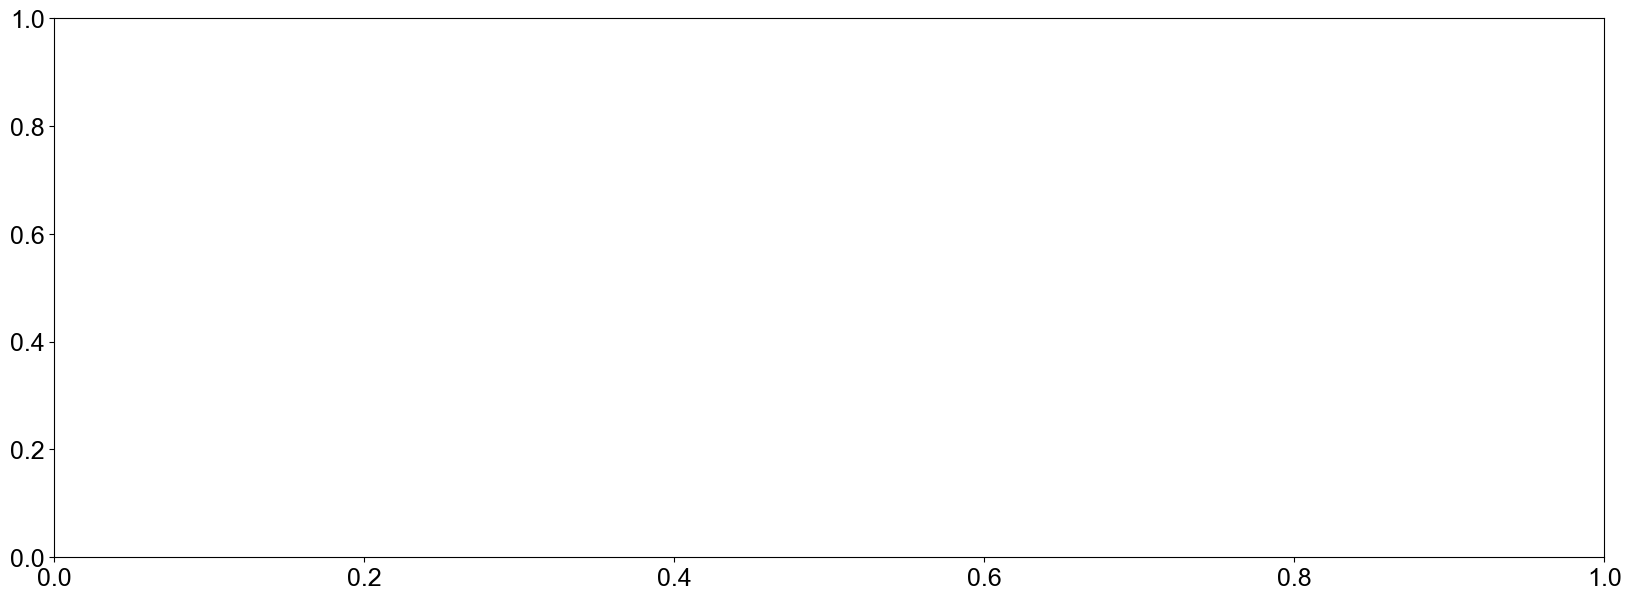

In [5]:
## Figure 1: Graph of important features

fig, ax = plt.subplots(figsize=(20,7))
sb.set(font_scale=1.8)
x_axis_labels = [2005,2006,2007,2008,2009,2010]*3
y_axis_labels =['MSM','MSMW', 'MSW', 'Missing','Northeast', 'Southeast', 'Southwest', 'West', 'Midwest','Regional CIP-R', 'Local CIP-R','Regional change in CIP-R', 'Local change in CIP-R']

ax.tick_params(axis='both', which='major', labelsize=18)

sb.heatmap(imporances_all_models,fmt="",cmap='vlag',linewidths=0.30,ax=ax, xticklabels = x_axis_labels, yticklabels = y_axis_labels, vmin =-abs(imporances_all_models.max()).max(), vmax = abs(imporances_all_models.max()).max())
ax.text((ax.get_xlim()[1])/18 * 1.5, (ax.get_ylim()[0]) + (ax.get_ylim()[0])*0.10, "Neural network", fontsize=20)
ax.text((ax.get_xlim()[1])/18 * 7.5, (ax.get_ylim()[0]) + (ax.get_ylim()[0])*0.10, "Logistic regression", fontsize=20)
ax.text((ax.get_xlim()[1])/18 * 13.5 , (ax.get_ylim()[0]) + (ax.get_ylim()[0])*0.10, "Random forest", fontsize=20)
ax.axvline((ax.get_xlim()[1])/18 * 6, color = "black", linewidth = 2)
ax.axvline((ax.get_xlim()[1])/18 * 12, color = "black", linewidth = 2)

plt.tight_layout()

/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_2648/541543975.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[row, col].set_xticklabels(labels =value_counts.index, rotation = 90, fontsize=12)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_2648/541543975.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[row, col].set_xticklabels(labels =value_counts.index, rotation = 90, fontsize=12)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_2648/541543975.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[row, col].set_xticklabels(labels =value_counts.index, rotation = 90, fontsize=12)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_2648/541543975.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[row, col].set_xticklabels(labels =value_counts.index, rotation = 90, fontsize=12)
/var/folders/d4/chxwf4hs

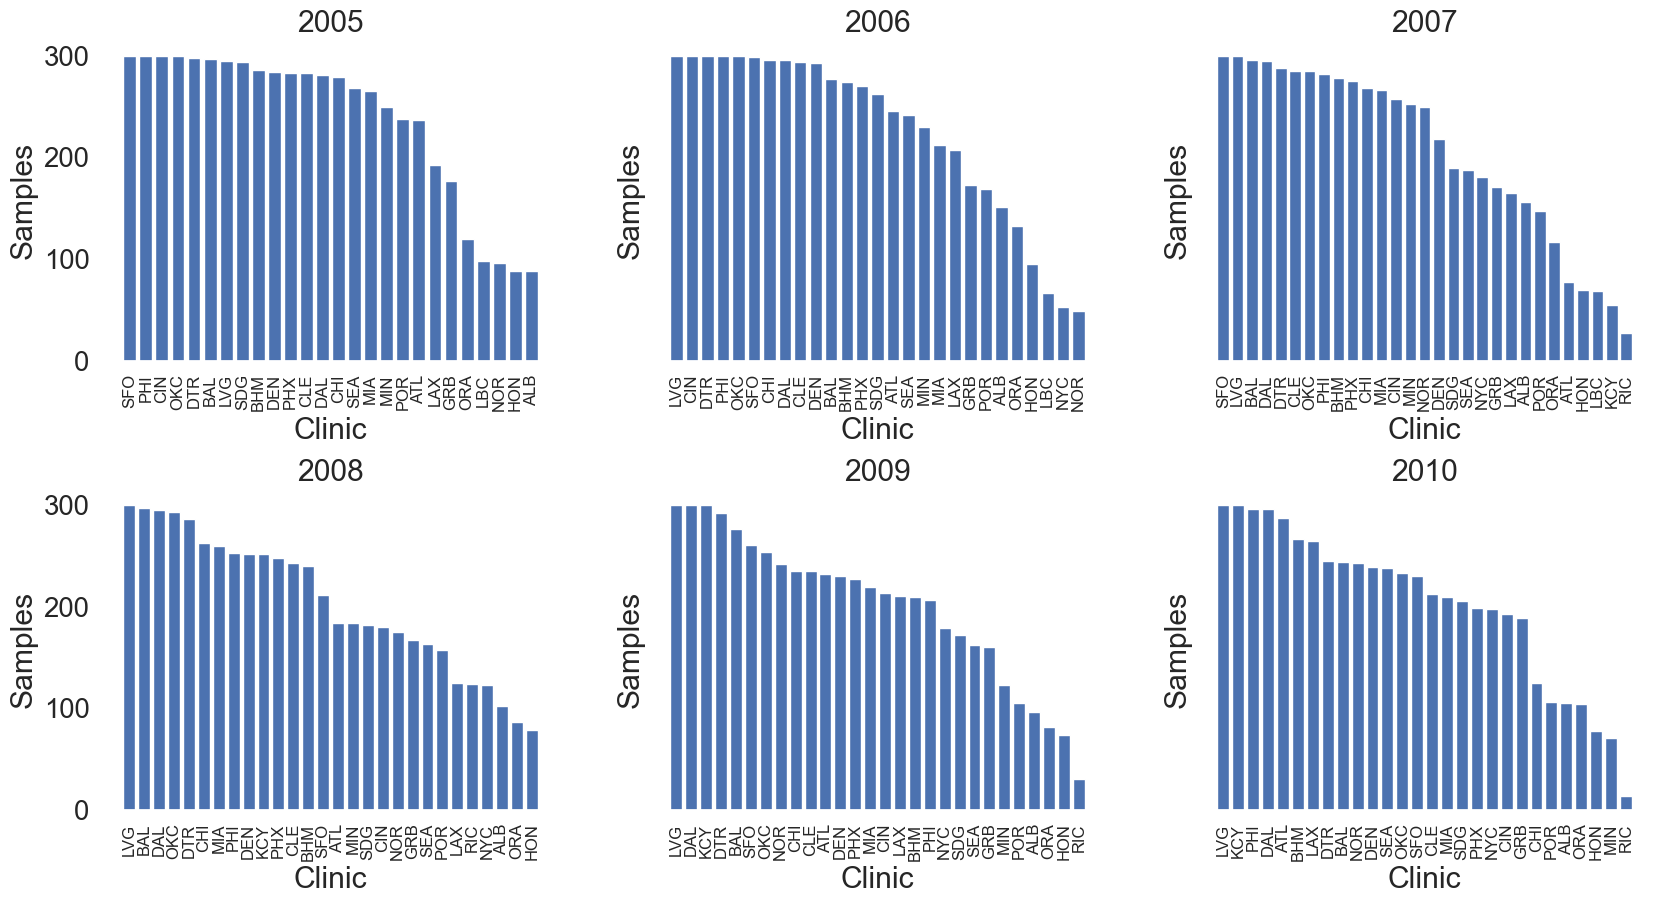

In [70]:

# Create histograms for each group
fig, axs = plt.subplots(2,3, figsize=(20, 10), facecolor='w', edgecolor='k', sharey = 'all')
fig.set_facecolor('white')
fig.subplots_adjust(wspace=0.2, hspace=0.4)

for i, year in enumerate(test_years):
    year_data = CIP_data_no_drop[CIP_data_no_drop['YEAR'] == year]
    value_counts = year_data['CLINIC'].value_counts()

    # Plot histogram on the respective subplot
    row = i // 3  # Calculate the row index
    col = i % 3   # Calculate the column index

    axs[row, col].set_facecolor('white')

    axs[row, col].bar(value_counts.index, value_counts.values)
    axs[row, col].set_xticklabels(labels =value_counts.index, rotation = 90, fontsize=12)
    axs[row, col].set_xlabel('Clinic')
    axs[row, col].set_ylabel('Samples')
    axs[row, col].set_title(f'{year}')


/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_2648/3104440474.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[row, col].set_xticklabels(labels =value_counts.index, rotation = 90, fontsize=12)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_2648/3104440474.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[row, col].set_xticklabels(labels =value_counts.index, rotation = 90, fontsize=12)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_2648/3104440474.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[row, col].set_xticklabels(labels =value_counts.index, rotation = 90, fontsize=12)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_2648/3104440474.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[row, col].set_xticklabels(labels =value_counts.index, rotation = 90, fontsize=12)
/var/folders/d4/chxw

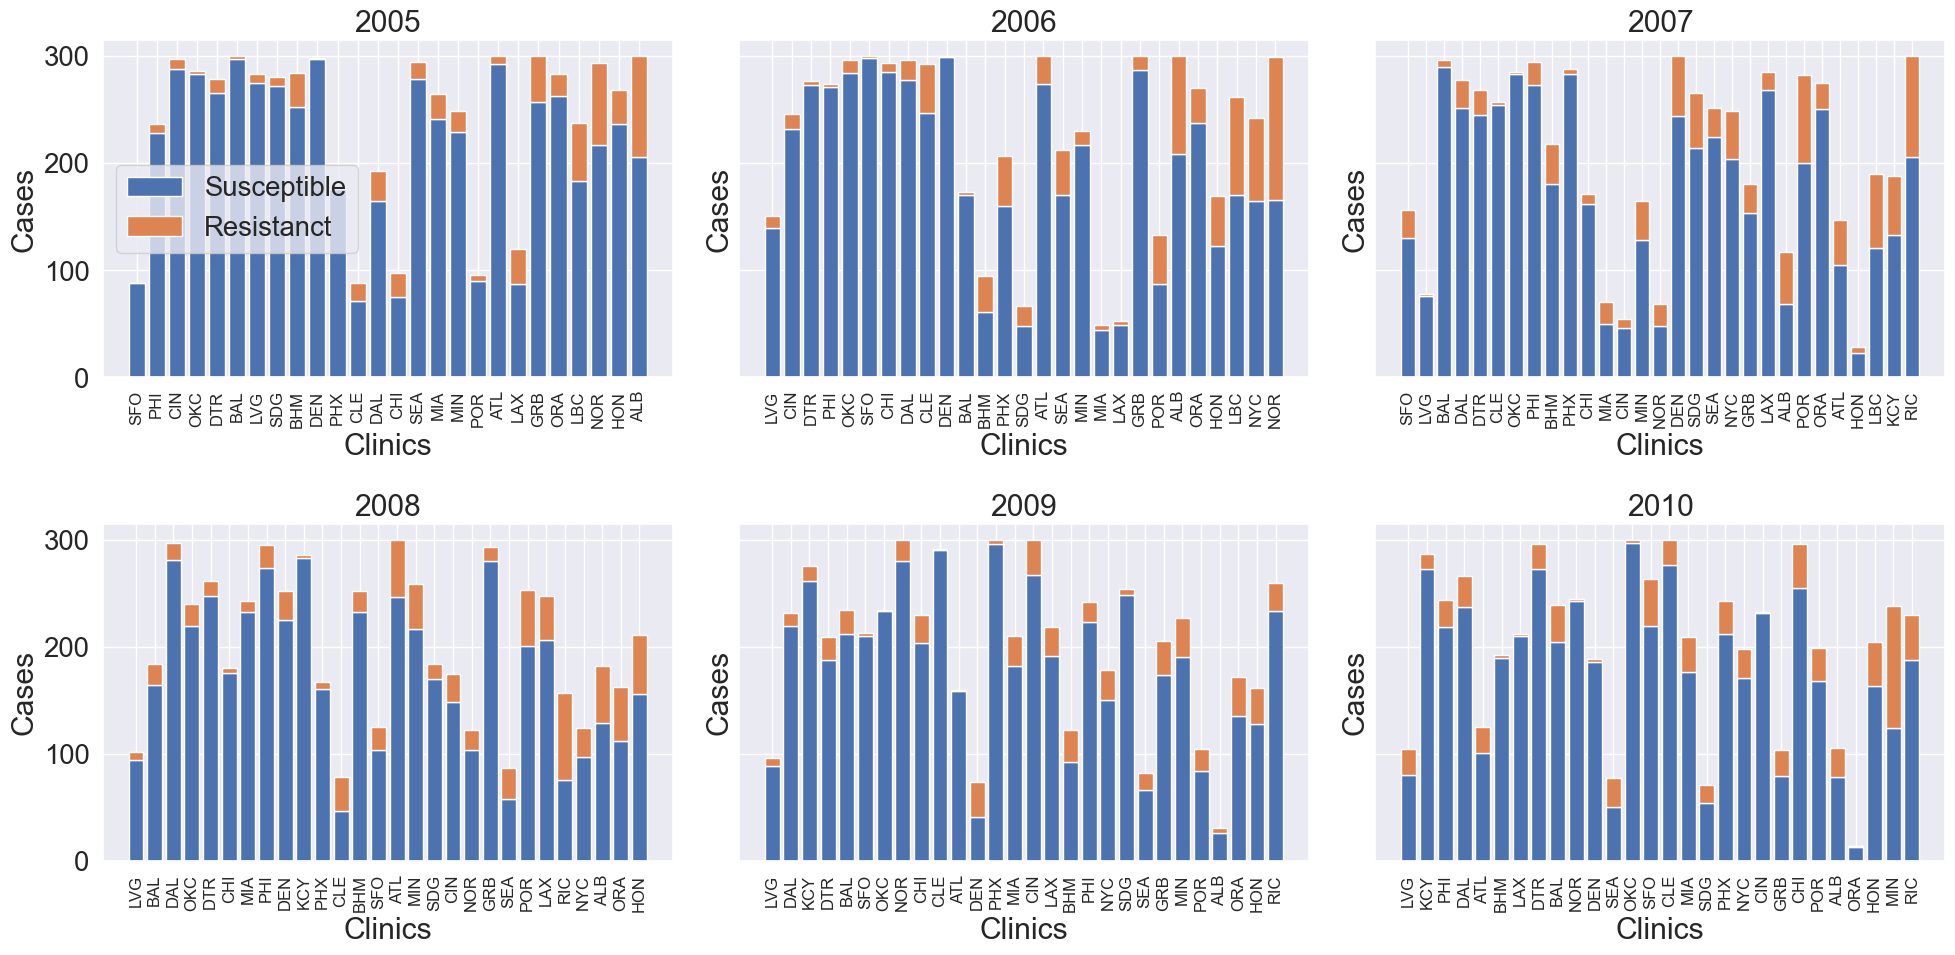

In [88]:
fig, axs = plt.subplots(2,3, figsize=(20, 10), facecolor='w', edgecolor='k', sharey = 'all')

for i, year in enumerate(test_years):
    year_data = CIP_data_no_drop[CIP_data_no_drop['YEAR'] == year]
    value_counts = year_data['CLINIC'].value_counts()
    cip_resistant = value_counts - year_data.groupby('CLINIC')['Susceptible'].sum()
    cip_susceptible = year_data.groupby('CLINIC')['Susceptible'].sum() 

    # Plot stacked bar chart on the respective subplot
    row = i // 3  # Calculate the row index
    col = i % 3   # Calculate the column index
    axs[row, col].bar(value_counts.index, cip_susceptible.values, label='Susceptible')
    axs[row, col].bar(value_counts.index, cip_resistant.values, bottom=cip_susceptible.values, label='Resistanct')
    axs[row, col].set_xticklabels(labels =value_counts.index, rotation = 90, fontsize=12)

    axs[row, col].set_xlabel('Clinics')
    axs[row, col].set_ylabel('Cases')
    axs[row, col].set_title(f'{year}')

axs[0, 0].legend()

plt.tight_layout()  # Adjust spacing between subplots
plt.show()

/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_2648/2970693691.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[row, col].set_xticklabels(labels =value_counts.index, rotation = 0, fontsize=14)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_2648/2970693691.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[row, col].set_xticklabels(labels =value_counts.index, rotation = 0, fontsize=14)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_2648/2970693691.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[row, col].set_xticklabels(labels =value_counts.index, rotation = 0, fontsize=14)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_2648/2970693691.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[row, col].set_xticklabels(labels =value_counts.index, rotation = 0, fontsize=14)
/var/folders/d4/chxwf4hs

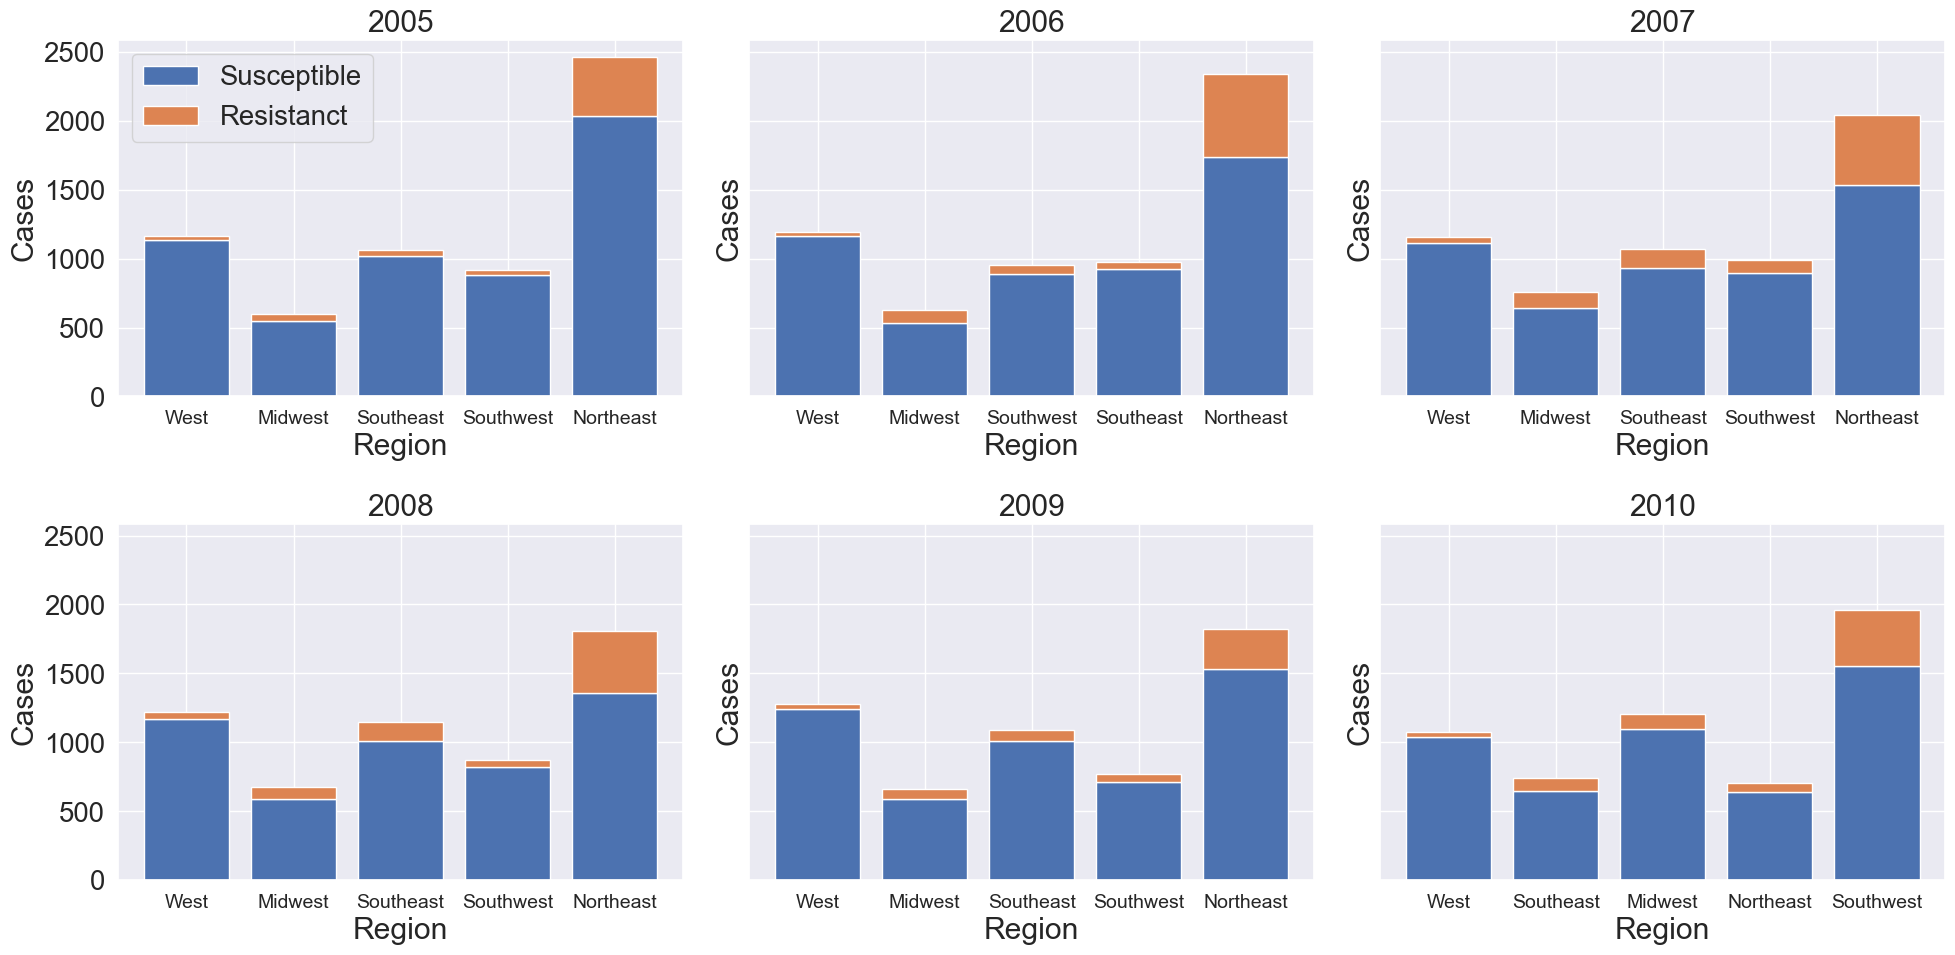

In [93]:
fig, axs = plt.subplots(2,3, figsize=(20, 10), facecolor='w', edgecolor='k', sharey = 'all')#, sharex = 'all')

for i, year in enumerate(test_years):
    year_data = CIP_data_no_drop[CIP_data_no_drop['YEAR'] == year]
    value_counts = year_data['REGION'].value_counts()
    cip_resistant = value_counts - year_data.groupby('REGION')['Susceptible'].sum()
    cip_susceptible = year_data.groupby('REGION')['Susceptible'].sum() 

    # Plot stacked bar chart on the respective subplot
    row = i // 3  # Calculate the row index
    col = i % 3   # Calculate the column index
    axs[row, col].bar(value_counts.index, cip_susceptible.values, label='Susceptible')
    axs[row, col].bar(value_counts.index, cip_resistant.values, bottom=cip_susceptible.values, label='Resistanct')
    axs[row, col].set_xticklabels(labels =value_counts.index, rotation = 0, fontsize=14)

    axs[row, col].set_xlabel('Region')
    axs[row, col].set_ylabel('Cases')
    axs[row, col].set_title(f'{year}')

axs[0, 0].legend()

plt.tight_layout()  # Adjust spacing between subplots
plt.show()